# Comparación de modelos OCR aplicados a bloques de texto científico. Notebook TrOCR

En esta sección se comparan tres enfoques de reconocimiento óptico de caracteres (OCR) aplicados a un conjunto real de recortes de texto extraídos de artículos científicos. Se evaluaron tanto la precisión como el rendimiento computacional de cada modelo sobre un total de 299 recortes clasificados manualmente como tipo `"text"` del dataset PubLayNet. Se utilizó como referencia un ground truth generado manualmente para cada imagen.

## Modelos evaluados

Los modelos considerados fueron:

- **Tesseract**: motor OCR tradicional, basado en visión clásica y segmentación heurística. Se utilizó con el parámetro `--psm 6` y `--psm 7`.
- **TrOCR** (`microsoft/trocr-base-stage1`): modelo transformer encoder-decoder entrenado para reconocimiento de texto impreso. Utilizado sin fine-tuning.

---

## Tratamiento TrOCR

A diferencia de Tesseract TrOCR no funciona con bloques de texto. Se requiere trabajar con bloques de texto de una sola línea. Para ello se implemento de manera previa un algoritmo de RLSA (`Run Length Smoothing Algoritm`) con el que detectar cada línea y aplicar TrOCR de manera esperada.

### Resultados obtenidos

#### Precisión (comparación con ground truth)

| Modelo           | WER promedio | CER promedio |
|------------------|--------------|--------------|
| **Tesseract**    | **0.13**   | **0.04**   |
| **TrOCR**        | **0.20**| **0.12** |

- **Tesseract** mostró un desempeño altamente efectivo sobre bloques completos, sin necesidad de segmentación previa. La tasa de error a nivel palabra (WER) se mantuvo en torno al 12%, mientras que el error por carácter (CER) fue menor al 5%.
- **TrOCR**, mostró un gran desempeño para considerar que se trabajo con un modelo sin fine-tuning. Sin embargo, sigue siendo una performance peor que la base de Tesseract para este caso.

---

#### Tiempo de inferencia

| Modelo           | Tiempo total (299 imágenes) | Tiempo por imagen | Dispositivo |
|------------------|-----------------------------|--------------------|-------------|
| **Tesseract**    | **~1 minuto**               | ~0.2 s             | CPU         |
| **TrOCR**| **~80 minutos**             | ~16.0 s promedio    | GPU         |

- **Tesseract** procesó el dataset completo en aproximadamente 1 minuto utilizando solo CPU.
- **TrOCR** requirió cerca de 80 minutos con aceleración por GPU. Su arquitectura resulta más pesada computacionalmente, la aplicación de RLSA y segmentación hacen más complejo el pipeline de trabajo.

---

### Conclusión

Para el caso específico de bloques de texto impresos extraídos de artículos científicos, **Tesseract sigue siendo la mejor opción** en términos de precisión, rendimiento y estabilidad general.

Un modelo moderno como **TrOCR** requiere segmentación precisa lo que hace más pesado computacionalment. Sin embargo, su versión sin fine-tunning no presentó diferencias grandes con un modelo con gran base como **Tesseract**, en un futuro puede ser interesante entrenar el modelo base para estos casos y comparar de manera más adecuada (fuera del alcance de este trabajo).

In [1]:
import cv2
import numpy as np
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt

# TrOCR

Ejemplo RLSA aplicado a un bloque de texto tipo `text`.

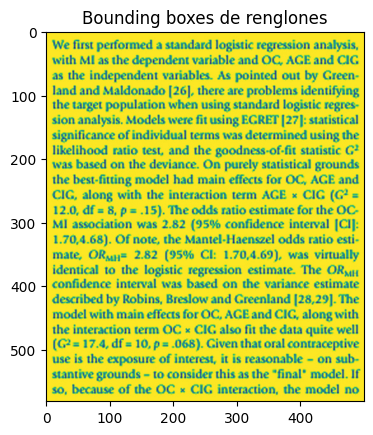

Tipo de dato: uint8
Mínimo: 0
Máximo: 255
Valores únicos: [  0 255]


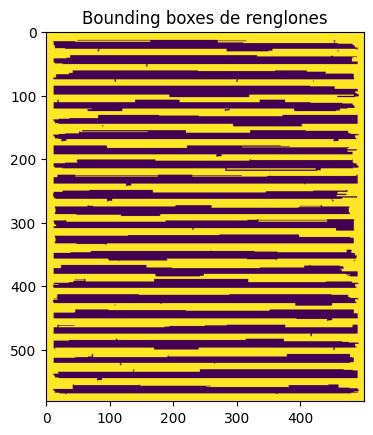

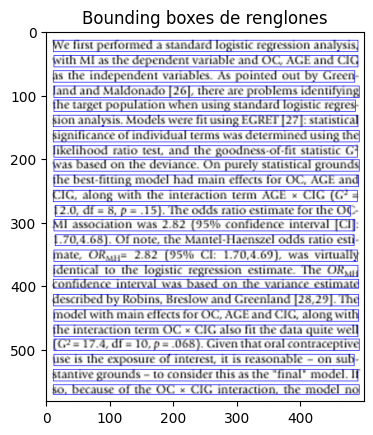

In [2]:
# --- Paso 1: Leer imagen binarizada ---
img_path = "D:\\Users\\Mauro\\TesisIA\\data\\regions\\text\\PMC1431532_00004_2861963.jpg"
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
plt.imshow(img)
plt.title("Bounding boxes de renglones")
plt.show()
# Binarización (por si no lo está aún)
_, binary = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY)

# --- Paso 2: Aplicar RLSA horizontal ---
def rlsa_horizontal(image: np.ndarray, threshold: int) -> np.ndarray:
    rlsa_image = image.copy()
    height, width = rlsa_image.shape

    for row in range(height):
        start = None
        count = 0
        for col in range(width):
            if rlsa_image[row, col] == 0:  # negro
                if start is not None and 0 < count <= threshold:
                    rlsa_image[row, start+1:col] = 0
                start = col
                count = 0
            else:
                count += 1

    return rlsa_image

rlsa_result = rlsa_horizontal(binary, threshold=100)
print("Tipo de dato:", rlsa_result.dtype)
print("Mínimo:", np.min(rlsa_result))
print("Máximo:", np.max(rlsa_result))
print("Valores únicos:", np.unique(rlsa_result))
plt.imshow(rlsa_result)
plt.title("Bounding boxes de renglones")
plt.show()

# --- Paso 3: Etiquetar regiones conectadas ---
label_img = label(rlsa_result == 0)  # etiquetar solo los píxeles negros (texto)

props = regionprops(label_img)

# --- Paso 4: Dibujar bounding boxes sobre la imagen original ---
output_img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

for prop in props:
    minr, minc, maxr, maxc = prop.bbox
    cv2.rectangle(output_img, (minc, minr), (maxc, maxr), (0, 0, 255), 1)

# --- Guardar o mostrar resultado ---
# cv2.imwrite("D:\\Users\\Mauro\\TesisIA\\temp\\bounding_boxes_renglones.png", output_img)

plt.imshow(output_img)
plt.title("Bounding boxes de renglones")
plt.show()


Cargamos los modelos de TrOCR que se utilizan en este trabajo.

In [3]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
import torch

# Cargar modelo
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-stage1")
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-stage1")

c:\ProgramData\anaconda3\envs\ocr_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-stage1 and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
def extraer_texto_con_trocr_stage1(binary_image, original_image, model_name: str = "microsoft/trocr-base-stage1", threshold_rlsa=100, expand=15, min_width=30, min_height=5):
    """
    Detecta renglones usando la imagen binaria y aplica TrOCR (base-stage1) sobre la imagen original (grayscale).

    Parámetros:
    - binary_image: imagen binaria (np.ndarray, valores 0/255)
    - original_image: imagen original (np.ndarray, escala de grises)
    - model_name (str): Nombre del modelo TrOCR a utilizar (por defecto 'microsoft/trocr-base-stage1')
    - threshold_rlsa: umbral para RLSA horizontal
    - expand: cantidad de píxeles extra por lado en cada bounding box
    - min_width / min_height: filtros para evitar ruido

    Retorna:
    - texto_concatenado: string con el texto OCR unido
    """

    def rlsa_horizontal(image: np.ndarray, threshold: int) -> np.ndarray:
        rlsa_image = image.copy()
        height, width = rlsa_image.shape
        for row in range(height):
            start = None
            count = 0
            for col in range(width):
                if rlsa_image[row, col] == 0:
                    if start is not None and 0 < count <= threshold:
                        rlsa_image[row, start+1:col] = 0
                    start = col
                    count = 0
                else:
                    count += 1
        return rlsa_image

    # --- Aplicar RLSA ---
    rlsa_result = rlsa_horizontal(binary_image, threshold=threshold_rlsa)
    rlsa_result = np.where(rlsa_result > 0, 255, 0).astype(np.uint8)

    # --- Etiquetar regiones conectadas ---
    binary_mask = (rlsa_result == 0).astype(np.uint8)
    label_img = label(binary_mask)
    props = regionprops(label_img)

    # --- Inicializar modelo y processor ---
    processor = TrOCRProcessor.from_pretrained(model_name)
    model = VisionEncoderDecoderModel.from_pretrained(model_name)

    H, W = binary_image.shape
    lineas_ocr = []

    for prop in props:
        minr, minc, maxr, maxc = prop.bbox
        width = maxc - minc
        height = maxr - minr

        if width < min_width or height < min_height:
            continue

        # Expandir bounding box
        minr = max(0, minr - expand)
        minc = max(0, minc - expand)
        maxr = min(H, maxr + expand)
        maxc = min(W, maxc + expand)

        # Recortar sobre la imagen original
        cropped = original_image[minr:maxr, minc:maxc]
        pil_image = Image.fromarray(cropped).convert("RGB")

        try:
            pixel_values = processor(images=pil_image, return_tensors="pt").pixel_values
            generated_ids = model.generate(pixel_values)
            text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
            # Normalizar a minúsculas si el modelo es el impreso
            if model_name == "microsoft/trocr-base-printed":
                text = text.lower()
            lineas_ocr.append((minr, text))
        except Exception as e:
            print(f"Error en línea [{minr}-{maxr}]:", e)

    # --- Ordenar líneas y concatenar ---
    lineas_ocr.sort(key=lambda x: x[0])

    texto_concatenado = ""
    for _, linea in lineas_ocr:
        linea = linea.strip()
        if not texto_concatenado:
            texto_concatenado = linea
        else:
            if texto_concatenado.endswith("-"):
                texto_concatenado = texto_concatenado[:-1] + linea
            else:
                texto_concatenado += " " + linea

    return texto_concatenado


Ejemplo de funcionamiento:


In [5]:
img = cv2.imread("D:\\Users\\Mauro\\TesisIA\\temp\\scaled_document.png", cv2.IMREAD_GRAYSCALE)
_, binary = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY)
texto = extraer_texto_con_trocr_stage1(binary, img)
print(texto)


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-stage1 and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


We first performed a standard logistic regression analysis, with MI as the dependent variable and OC, AGE and CIC as the independent variables. As pointed out by Greenland and Maldonado [26], there are problems identifying the target population when using standard logistic regression analysis. Models were fit using EGRET [27]: statistical significance of individual terms was determined using the likelihood ratio test, and the goodness-of-fit statistic G2 was based on the deviance. On purely statistical grounds the best-fitting model had main effects for OC, AGE and CIG, along with the interaction term AGE x CIG (G2 = 12.0, df = 8, p = . 15). The odds ratio estimate for the OC MI association was 2.82 (95% confidence interval [CI]: 1.70,4.68). Of note, the Mantel-Haenszel odds ratio mate, OR,up= 2.82 (95% CI: 1.70,4. identical to the logistic regression estimate. The ORsul confidence interval was based on the variance estimate described by Robins, Breslow and Greenland [28, 29]. The mode

In [6]:
import os
import json
import cv2
from jiwer import wer, cer

def evaluar_ocr_global_jiwer(carpeta_imagenes: str, path_ground_truth_json: str, model_name: str = "microsoft/trocr-base-stage1"):
    """
    Evalúa CER, WER, WCC y WRC. 
    Compara OCR completo por imagen con su ground truth completo.

    Devuelve una lista de resultados por imagen:
    [
        {
            "nombre": "archivo.png",
            "CER": 0.12,
            "WER": 0.21,
            "WCC": 0.67,
            "WRC": 0.92,
            "OCR": "...",
            "GT": "..."
        },
        ...
    ]
    """
    with open(path_ground_truth_json, 'r', encoding='utf-8') as f:
        gt_dict = json.load(f)

    cer_total = wer_total = wcc_total = wrc_total = 0
    total = 0
    resultados = []

    for nombre_img, texto_gt in gt_dict.items():
        path_img = os.path.join(carpeta_imagenes, nombre_img)
        if not os.path.exists(path_img):
            print(f"❌ Imagen no encontrada: {nombre_img}")
            continue

        original = cv2.imread(path_img, cv2.IMREAD_GRAYSCALE)
        _, binary = cv2.threshold(original, 128, 255, cv2.THRESH_BINARY)

        try:
            texto_ocr = extraer_texto_con_trocr_stage1(binary, original, model_name=model_name)
        except Exception as e:
            print(f"⚠️ Error procesando {nombre_img}: {e}")
            continue

        # Métricas jiwer
        cer_score = cer(texto_gt, texto_ocr)
        wer_score = wer(texto_gt, texto_ocr)

        # --- Nueva métrica: WCC ---
        gt_vocab = set(texto_gt.split())
        ocr_vocab = set(texto_ocr.split())
        wcc_score = len(gt_vocab & ocr_vocab) / len(gt_vocab) if gt_vocab else 0

        # --- Nueva métrica: WRC ---
        gt_len = len(texto_gt.split())
        ocr_len = len(texto_ocr.split())
        wrc_score = 1 - (abs(ocr_len - gt_len) / gt_len) if gt_len > 0 else 0

        # Acumuladores
        cer_total += cer_score
        wer_total += wer_score
        wcc_total += wcc_score
        wrc_total += wrc_score
        total += 1

        print(f"[{nombre_img}] CER: {cer_score:.3f} | WER: {wer_score:.3f} | WCC: {wcc_score:.3f} | WRC: {wrc_score:.3f}")
        print("OCR:", texto_ocr)
        print("GT :", texto_gt)
        print("---")

        resultados.append({
            "nombre": nombre_img,
            "CER": cer_score,
            "WER": wer_score,
            "WCC": wcc_score,
            "WRC": wrc_score,
            "OCR": texto_ocr,
            "GT": texto_gt
        })

    if total > 0:
        print(f"\n✅ CER promedio: {cer_total / total:.3f}")
        print(f"✅ WER promedio: {wer_total / total:.3f}")
        print(f"✅ WCC promedio: {wcc_total / total:.3f}")
        print(f"✅ WRC promedio: {wrc_total / total:.3f}")
    else:
        print("⚠️ No se procesó ninguna imagen válida.")

    return resultados


## Resultados TrOCR base stage 1

In [ ]:
resultados = evaluar_ocr_global_jiwer(
    "../data/regions/text",
    "../data/annotations/ocr_text_labels.json"
)

In [11]:
import json

def guardar_resultados_en_json(resultados, path_salida):
    with open(path_salida, 'w', encoding='utf-8') as f:
        json.dump(resultados, f, ensure_ascii=False, indent=4)
    print(f"✅ Resultados guardados en: {path_salida}")

import csv

def guardar_resultados_en_csv(resultados, path_salida):
    """
    Guarda los resultados de evaluar_ocr_global_jiwer en un archivo CSV.

    Args:
        resultados (list[dict]): Lista de resultados devueltos por evaluar_ocr_global_jiwer.
        path_salida (str): Ruta del archivo CSV de salida.
    """
    if not resultados:
        print("⚠️ No hay resultados para guardar.")
        return

    # Usar las claves del primer resultado como encabezado
    keys = resultados[0].keys()

    with open(path_salida, "w", newline="", encoding="utf-8") as f:
        writer = csv.DictWriter(f, fieldnames=keys)
        writer.writeheader()
        writer.writerows(resultados)

    print(f"✅ Resultados guardados en: {path_salida}")


In [10]:
guardar_resultados_en_json(resultados, "../results/resultados_trocr.json")
guardar_resultados_en_csv(resultados, "../results/resultados_trocr.csv")

✅ Resultados guardados en: ../results/resultados_trocr.json
✅ Resultados guardados en: ../results/resultados_trocr.csv


In [11]:
import pandas as pd

df = pd.read_csv("../results/resultados_trocr.csv")

df

,nombre,CER,WER,WCC,WRC,OCR,GT
0,PMC1431532_00004_2861961.jpg,0.008475,0.111111,0.944444,0.944444,cigarettes ( CIG) are sufficient to control co...,cigarettes (CIG) are sufficient to control con...
1,PMC1431532_00004_2861962.jpg,0.000000,0.000000,1.000000,1.000000,longer provides a summary estimate of the odds...,longer provides a summary estimate of the odds...
2,PMC1431532_00004_2861963.jpg,0.048423,0.123894,0.881481,0.995575,We first performed a standard logistic regress...,We first performed a standard logistic regress...
3,PMC1431532_00004_2861964.jpg,0.045726,0.113208,0.858491,0.955975,"Next, we conducted an analysis using the MSM-I...","Next, we conducted an analysis using the MSM-I..."
4,PMC1431532_00004_2861965.jpg,0.079755,0.105263,1.000000,0.894737,The consumer The counterfactual definition of ...,The counterfactual definition of confounding r...
...,...,...,...,...,...,...,...
294,PMC3872442_00003_2630426.jpg,0.011673,0.105263,0.935484,0.973684,and other bleeding risks in 142 (19.6%) patien...,and other bleeding risks in 142 (19.6%) patien...
295,PMC3872442_00003_2630427.jpg,0.063158,0.121951,0.972222,0.902439,"""The most of the The most common reason for no...",The most common reason for not using pharmacol...
296,PMC3872442_00003_2630428.jpg,0.000000,0.000000,1.000000,1.000000,3.3. Incidence of VTE during ICU Stay. Table 3...,3.3. Incidence of VTE during ICU Stay. Table 3...
297,PMC3872442_00003_2630429.jpg,0.356250,0.520000,0.545455,0.720000,Porcent to The relationship between the use of...,Figure 1. The relationship between the use of ...


In [12]:
promedios = df.mean(numeric_only=True)
print(promedios)


CER    0.123073
WER    0.203185
WCC    0.837377
WRC    0.903074
dtype: float64


## Resultados trocr-small-stage1

In [ ]:
resultados = evaluar_ocr_global_jiwer(
    "../data/regions/text",
    "../data/annotations/ocr_text_labels.json",
    model_name='microsoft/trocr-base-printed'
)

In [13]:
guardar_resultados_en_json(resultados, "../results/resultados_trocr_printed.json")
guardar_resultados_en_csv(resultados, "../results/resultados_trocr_printed.csv")

✅ Resultados guardados en: ../results/resultados_trocr_printed.json
✅ Resultados guardados en: ../results/resultados_trocr_printed.csv


In [14]:
import pandas as pd

df = pd.read_csv("../results/resultados_trocr_printed.csv")

df

,nombre,CER,WER,WCC,WRC,OCR,GT
0,PMC1431532_00004_2861961.jpg,0.135593,0.277778,0.722222,0.944444,cigareties (cig) are sufficient to control con...,cigarettes (CIG) are sufficient to control con...
1,PMC1431532_00004_2861962.jpg,0.050633,0.076923,0.916667,1.000000,longer provides a summary estimate of the odds...,longer provides a summary estimate of the odds...
2,PMC1431532_00004_2861963.jpg,0.190756,0.451327,0.570370,0.955752,we first performed a standard logustic regress...,We first performed a standard logistic regress...
3,PMC1431532_00004_2861964.jpg,0.162028,0.427673,0.528302,0.918239,net. we conducted an analys using the msm-iptw...,"Next, we conducted an analysis using the MSM-I..."
4,PMC1431532_00004_2861965.jpg,0.116564,0.368421,0.764706,0.894737,the couponts the counterfacual definition of c...,The counterfactual definition of confounding r...
...,...,...,...,...,...,...,...
294,PMC3872442_00003_2630426.jpg,0.128405,0.342105,0.645161,0.947368,and other bechling flaks in 182 (19.6%) patien...,and other bleeding risks in 142 (19.6%) patien...
295,PMC3872442_00003_2630427.jpg,0.298246,0.585366,0.611111,0.853659,please and on facebook of receipt for all the ...,The most common reason for not using pharmacol...
296,PMC3872442_00003_2630428.jpg,0.186441,0.473684,0.500000,1.000000,33. includice of vte during iou sup. table 3 d...,3.3. Incidence of VTE during ICU Stay. Table 3...
297,PMC3872442_00003_2630429.jpg,0.643750,0.800000,0.227273,0.520000,please: the requiredy payment be are of primas...,Figure 1. The relationship between the use of ...


In [15]:
promedios = df.mean(numeric_only=True)
print(promedios)


CER    0.300812
WER    0.557152
WCC    0.460511
WRC    0.849783
dtype: float64


In [16]:
resultados = evaluar_ocr_global_jiwer(
    "../data/regions/text",
    "../data/annotations/ocr_text_labels.json",
    model_name='microsoft/trocr-base-handwritten'
)

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC1431532_00004_2861961.jpg] CER: 0.025 | WER: 0.278 | WCC: 0.889 | WRC: 0.833
OCR: cigarettes ( CIG ) are sufficient to control confounding and that there is no misclassification or other source of bias .
GT : cigarettes (CIG) are sufficient to control confounding and that there is no misclassification or other source of bias.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC1431532_00004_2861962.jpg] CER: 0.152 | WER: 0.154 | WCC: 0.833 | WRC: 1.000
OCR: longer provides a summary estimate of the odds ratio for the Commission .
GT : longer provides a summary estimate of the odds ratio for the OC-MI association.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC1431532_00004_2861963.jpg] CER: 0.259 | WER: 0.624 | WCC: 0.430 | WRC: 0.947
OCR: We first performed a standard logistic regression analysis . with Miss the dependent variable and O.ACES and O.C as the independent variables to pinned out by Green and and Maldonado ( of these are problems identified the mass population when its standard logistic region sign analysis models were missing for its first personal significance of individual censuits determined using the likelihood activities and the goodness of the smile . It vas based on the distance of purely statistical grounds the best firing model had main effects for O.C.R. and CIC along with the interaction team ACEx CIC. ( 62 120, Dr.B. p. 159 The odd-mostimeter the OC. Missociation was 2.82 1955 confidence interval PDF 170163 ) OF none the Maine House holds also more or # 82, 95. W.C. 170,69 ) was visually identization the logistic regression estimate the O.R.R. confidence interval was based on the variance estimate described by 

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC1431532_00004_2861964.jpg] CER: 0.301 | WER: 0.597 | WCC: 0.434 | WRC: 0.855
OCR: Next we conducted an analysing the MSM.P.W. approach to obtain regression weights , a standard basis increasing analysis of control data is performed with accompanied in trouble and white and crew the independent variables the best firing model had only a main effect for ACTC.S.O.C.C.C.C. their conducted a weighted logistic regression analysis is its generalized estimation of nations with this time denarks and other settlements able following them in real life and solo and Messiyama ITVL calculations were performed using the SAS price dureproof and the oldest time to the Commission was 3.3/954,2.15.52 ) Increasingly when empirical weights were used instead of session versus the odds a distinctive which equals signess 28" Special 18. and this very close to the odds are and confidence interval estimates based on the standard logistic regression and Marketthensel analysses .
GT : Next, we conducted an an

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC1431532_00004_2861965.jpg] CER: 0.117 | WER: 0.526 | WCC: 0.706 | WRC: 0.789
OCR: wisconsin . the counter-actual definition of confounding represents an important conceptual advance over earlier formula tions of contounding working with in the counterfactual
GT : The counterfactual definition of confounding represents an important conceptual advance over earlier formulations of confounding. Working within the counterfactual
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC1431532_00004_2861966.jpg] CER: 0.086 | WER: 0.364 | WCC: 0.727 | WRC: 0.909
OCR: Table 3. Caso-control study of oral contraceptives and myocardial infarction ( 2
GT : Table 5: Case-control study of oral contraceptives and myocardial infarction [25]
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC1431532_00004_2861967.jpg] CER: 0.521 | WER: 0.857 | WCC: 0.143 | WRC: 0.857
OCR: occipal contraceptives gigg careerers . agreement
GT : OC: oral contraceptives CIG: cigarettes AGE: age
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC2577655_00018_2086211.jpg] CER: 0.331 | WER: 0.637 | WCC: 0.403 | WRC: 0.978
OCR: caucumbers . Wedemonsmate that Rhojack activity is necessary and sufficient organizations to provide the are without being the same direction had tion . Rhoadivity a new museum of BMP and CITS man sition to essential events for achieving successful NC definition acting as a downstream effect on Rhodesia rock maintains a brief series that has through which it is likely to preserve Northern assisted to the men . home of NC passengers to gather overseas that the activity negatively modifies the definition by antiazine the spin-system and interstellar advisors mediated by N.catherin .
GT : We demonstrate that Rho/Rock activity is necessary and sufficient for maintaining NC progenitors in an epithelial state without affecting their state of specification. In addition, Rho activity acts downstream of BMP and G₁/S transition, two essential events for achieving successful NC delamination. Acting as a downstre

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC2577655_00018_2086212.jpg] CER: 0.232 | WER: 1.000 | WCC: 0.364 | WRC: 0.636
OCR: 0 0 Ferrilequail ( Commix commix japonica ) eggs from cornmercial sources were used .
GT : Fertile quail (Coturnix coturnix japonica) eggs from commercial sources were used.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC2577655_00018_2086213.jpg] CER: 0.474 | WER: 0.864 | WCC: 0.350 | WRC: 0.859
OCR: a member of the United States Senator of the Senate of Representativesfrom the Senate of Representativesfrom the DNA expression vectors employed were PACOS AIR . which served as control 1951-YFR City in front table . Meyer , the specific ring issuing construction that citation in the Parliament shark and what lacks the first activity of the kind Nighorn on a conference address that the Cs. like ADP system stores from this states 1969 , and Nashipy Drins were second in a place's and atheptured in France as spreading sequence or as decreposed with control ( He experienced details are establishments on course . DNA ( 3 including a statement treat into the turn of the North to its same stage embryos at the level of the segmental place and for two recently formed somites . A four perimeter tributable square wave clearance in that example set ences the Maryland Navy would be delivered here groups of sequent

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC2577655_00018_2086214.jpg] CER: 0.365 | WER: 0.927 | WCC: 0.395 | WRC: 0.732
OCR: hinexplants kept for a total of about 16th. Cayman Chemical Co. Ann Arbor , Mr. USA ) and the scheme 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 program-end Minneapolis . In. usual , or combine noms of the above were added .
GT : h in explants kept for a total of about 16 h; Cayman Chemical Co. Ann Arbor, Mi, USA), and the selective ADAM10 inhibitor GI254023X (12 μM) [98,99], BMP⁴ (100 ng/ml; R&D Minneapolis, MN, USA), or combinations of the above were added.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC2577655_00018_2086215.jpg] CER: 0.490 | WER: 0.919 | WCC: 0.300 | WRC: 0.814
OCR: a member of the United States Department of Agriculture Interorder-exposed neural pimordial containing prehistory NC were asked from segmental place levels of 16.20s. nine size embryos and then explained onto swell chamber slides , Leftiek Nunc Rochester NY . USMIP received with the American Government Service St Louis. Mo. USA described the Church of America sized of children in a hospital centre . using to which members are presented to the British Parliament cruskeleton Inc. Denver CO. US.N.Y27632 (15. N. signalling the amino acid mimeline ( 600. Mr. Callocation . San Diego CA. USA ) LPA ( pushing blood once after a
GT : Intact or electroporated neural primordia containing premigratory NC were excized from segmental plate levels of 16–20 somite-stage embryos and then explanted onto 8-well chamber slides (Lab-Tek, Nunc, Rochester, NY, USA) pre-coated with fibronectin (50 μg/ml; Sigma, St. Louis, Mo,

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC2577655_00018_2086216.jpg] CER: 0.310 | WER: 0.606 | WCC: 0.534 | WRC: 0.887
OCR: a member of the Government of Australia rhonic Pizza was prepared as previously described propend mixed with a concentration of 100 mg , and its Phnomics distinguished a low temperature but set at noon expensive this evening table over the site of a plot union for several hours small pieces of control or IPA containing sets were placed do it to Nts at the level of the seminal place neededem and embryos were further incubited for a origin .
GT : Pluronic F-127 gel was prepared as previously described [100] and mixed with a concentration of 100 μg/ml LPA. Pluronic gel is liquid at low temperature but sets at room temperature, thus remaining stable over the site of application for several hours. Small pieces of control or LPA-containing gels were placed dorsal to NTs at the level of the segmental plate mesoderm and embryos were further incubated for 8 or 16 h.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC2577655_00018_2086217.jpg] CER: 0.364 | WER: 0.741 | WCC: 0.343 | WRC: 0.969
OCR: 1944. Emboss were fixed with 1 4-termaldehyde embedded in partners associated to the establishment of Molecular probes Eugene OR US ( was used at 1 500 incombination with the world's immunobeling or combined with inside hybridization for food 3 . Small2 or see ( 224 ) antibodies , ensure the product later domains of Nachim were applied following methanol fixation as described by ventilation antibodies vere from the Hybridoms Bank Planenious actin was visselized with problems that was visualized with no different antibodies 2604-monoclonal SCATS. Santa One blockhology , and Cruz CA USA , or no more deathless to take the most evidence with polycontamination by the Cisoissance movement as for with an initial monodontanitively from the Hahnblom Bank ( Wahlbadics were found to be chall yeongie their respective missions to join for vteRoman Republic personnel of the United States michlorogenic acid is previ

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC2577655_00018_2086218.jpg] CER: 0.298 | WER: 0.588 | WCC: 0.493 | WRC: 0.976
OCR: topping the NCdelman's union was monitored in at least 5 embryos per remenduous 21 embryos having similar jobs to type is described just by strictly the number of copies or Hochst cells locked up to the migration singing area vis measured in 2 sections of control versus a primer when its widespread man - and addiction about a semiimetrepecively the number of NC alls with meaningful morphology that cured explanted MPs was confined in 2025 microscopic fields , explant each comprising an area of 2,500,mn. . Both
GT : NC delamination was monitored in at least 5 embryos per treatment out of 8–21 embryos showing a similar phenotype, as described [14]. Briefly, the number of GFP⁺ or Hoechst⁺ cells located up to the migration staging area was measured in 25 sections of control versus experimental hemi-NTs, and expressed as mean ± standard deviation of total cases monitored, respectively. The number of NC cell

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC2709473_00003_2955930.jpg] CER: 0.173 | WER: 0.400 | WCC: 0.611 | WRC: 0.800
OCR: oms are chemical bonded and bond order is 1.012 The distance between Co and Wisconsin's 2.81A.
GT : oms are chemical bonded and bond order is 1.01 e. The distance between C₁₂ and N₁₅ atom is 2.81 Å.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC2709473_00003_2955931.jpg] CER: 0.311 | WER: 0.631 | WCC: 0.426 | WRC: 0.954
OCR: sub-matrices given in Fig. ( ( 2 ) were found after setting some double tries for the confusion of a variety of ments for both series , the limits are 3,000s for diagonal clenews of the EMCs. and # 0.13 for their official date to comparison the plan emphasizes found from the Match-Greenhead in all its previous rounds # sometimes for the pharmacophones are given in table .
GT : Sub-matrices given in Fig. (2) were found after setting some allowable limits for the comparison of matrix elements. For both series, the limits are ϕ₁ = 0.05 for diagonal elements of the ETMCs and ϕ₂ = 0.15 for their off-diagonal elements comparison. The pharmacophores found from the ETM-calculations are realized in all (15) active compounds. Statistical estimates for the pharmacophores are given in Table 1.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC2709473_00003_2955932.jpg] CER: 0.445 | WER: 0.685 | WCC: 0.375 | WRC: 0.685
OCR: An activity feature Phil is shown along with its ETSA of the order # see File 2 ) Only is an immediate list of the story of the story mid its origins are considered to 2of20-to-pick-steptobility , of is realization in this class is about 0.841 As seen from the pharmacophone structure , the active feature ! , Phil , consists
GT : An activity feature Ph₁ is shown along with its ETSA of the order 8×8 (see Fig. 2). Only its upper triangle is given because of the symmetry of bounds. The pharmacophore was found in 15 of 20 active compounds, n_A, and it was found in 2 of 20 inactive compounds, n_IA. Thus, the probability P_A of its realization in this class is about 0.84. As seen from the pharmacophore structure, the active feature 1, Ph₁, consists of the 8 atoms (C₁, C₅, C₆, C₉, C₁₀, C₁₂, C₁₃ and N₁₅).
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC2709473_00003_2955933.jpg] CER: 0.420 | WER: 0.658 | WCC: 0.387 | WRC: 0.895
OCR: Compound 6 was chosen as template and compared the performance in the series from the 2nd stand in # of 20-000s his help of ability # 0.8.8.8scan in Fig. ( 3 ) . "
GT : Compound 6 was chosen as template and compared the rest of the molecules in the series. Pharmacophores 2, Ph₂, were found in 13 of 20 active compounds having the probability P_A = 0.88 as seen in Fig. (3).
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC2709473_00003_2955934.jpg] CER: 0.052 | WER: 0.333 | WCC: 0.821 | WRC: 0.833
OCR: Compound 19 was chosen as template and the active fear ure 3 . Ph3 , is formed by 4 different atoms and statistical estimates for the pharmacophones are given in see Fig. 1 ) .
GT : Compound 19 was chosen as template and the active feature 3, Ph3, is formed by 4 different atoms and statistical estimates for the pharmacophores are given in see Fig. (4). 
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC2709473_00003_2955935.jpg] CER: 0.529 | WER: 0.733 | WCC: 0.316 | WRC: 0.622
OCR: template compounds their structures are given in Fig. 5 ) . the second round consisted of 0/3/3 APPLICATION # the numbers , while corresponding submarines are siven-mearily .
GT : template compounds (their structures are given in Fig. 5). Again, both protonated and unprotonated forms of compounds 25, 27 and 42 were studied. As an example, APh₁, APh₂ and APh₃ anti-pharmacophores are shown in the figure by their numbers, while corresponding sub-matrices are given nearby.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC2709473_00003_2955936.jpg] CER: 0.209 | WER: 0.442 | WCC: 0.583 | WRC: 0.953
OCR: Anti-pharmacophones , alone with pharmacophores , are also of interest for the results as this person of molecules that are responsible for the considerable depression when he has able the ability to find them phones , inactive compounds 25. 27 and 42 were selected as
GT : Anti-pharmacophores, alone with pharmacophores, are also of interest for the researches as those parts of molecules that are responsible for the considerable decrease or complete loss of the activity in view. To find anti-pharmacophores, inactive compounds 25, 27 and 42 were selected as
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC2709473_00003_2955937.jpg] CER: 0.416 | WER: 0.667 | WCC: 0.412 | WRC: 0.689
OCR: The anti-pharmacophore APH.A Ph2 and APH. see Fig. sy consisting of 3 atoms , enters the structures of 15 inactive 0-000s 1962 establishments in Britain 20 inactive molecules in total .
GT : The anti-pharmacophore APh₁, APh₂ and APh₃ (see Fig. 5) consisting of 5 atoms, enters the structures of 15 inactive molecules and are found 2 active compounds (see Fig. 5). The probability is 84%, because they are found in 15 from 20 inactive molecules in total.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC2709473_00003_2955938.jpg] CER: 0.531 | WER: 0.712 | WCC: 0.340 | WRC: 0.822
OCR: When comparing the structures of the pharmacophores spokenless was indicated that it does not change this # the highest of the declifying medicine and workshops of business and # the personal progress in this sense of advice symmetry happens to end as the result of this study forms about a system of the human achievement by birth insur-imiry prediction .
GT : When comparing the structures of the pharmacophores and anti-pharmacophores, one can pay attention to the differences in their spatial and electron characteristics. Thus, pharmacophores and anti-pharmacophores can play their role in the activity prediction only if both types of fragments participate in the process of prognosis. Thus, the set of activity/inactivity fragments found as the result of this study forms a basis for a system of the Human AChE activity binding affinity prediction.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC2709473_00003_2955939.jpg] CER: 0.363 | WER: 0.622 | WCC: 0.433 | WRC: 0.946
OCR: As seen from Fig. ( 6 ( the pharmacophones Phil-Ph3-and sphing the first round is the next of the ETP. purchased as a system for a of the biobenzamide and quimatization analogues activity prediction .
GT : As seen from Fig. (6), the pharmacophores Ph₁-Ph₃ and anti-pharmacophores APh₁-APh₃ found as the result of the ETM application were used as a basis for a system formation capable of the thiobenzamide and quinolizidine analogues activity prediction.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC2709473_00003_2955940.jpg] CER: 0.302 | WER: 0.405 | WCC: 0.606 | WRC: 0.946
OCR: A series of marine and 1 1 1 1-Andenoff 2-b Equinolim 0,000 binding army is studied by means of the ETM which takes imp account both , structural and electronic characteristics of molecules . Based on pharmacophores and anti-pharmac-
GT : A series of tacrine and 11 H-Indeno-[1,2-b]-quinolin-10-ylamine compounds demonstrating Human AChE activity binding affinity is studied by means of the ETM, which takes into account both structural and electronic characteristics of molecules. Based on pharmacophores and anti-pharmacophores, 
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC2709473_00003_2955941.jpg] CER: 0.125 | WER: 0.438 | WCC: 0.625 | WRC: 1.000
OCR: The CLETSC and corresponding structure of the pharmacophone Phil found relative to active compound 4 .
GT : Fig. (2). ETSC and corresponding structure of the pharmacophore Ph₁ found relative to active compound 4.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC2709473_00003_2955942.jpg] CER: 0.115 | WER: 0.438 | WCC: 0.625 | WRC: 1.000
OCR: The GLETSC and corresponding structure of the pharmacophone Ph2 found relative to active compound 6 .
GT : Fig. (3). ETSC and corresponding structure of the pharmacophore Ph₂ found relative to active compound 6.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC2801012_00001_269655.jpg] CER: 0.216 | WER: 0.483 | WCC: 0.556 | WRC: 0.966
OCR: child segments around the branchpoint needs to be localized for breaking angle measurements both measurements are direct to perform mainly via 2D images because of problems of for shortening in projects . New . Therefore firstly accepted a statement of the primary vote released on 30 issues only play for important role in detecting and characterizing the vessel structure the spinning in a number of small vessels which could be ads put in which we will establish normative values against which in individual can be compared for the detection of discage .
GT : child segments around the branchpoint needs to be localized for branching angle measurements. Both measurements are difficult to perform manually via 2D images because of problems of for-shortening in projected view. Therefore, highly automated segmentation of the pulmonary vascular tree based on 3D image analysis plays an important role in detecting

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC2801012_00001_269656.jpg] CER: 0.287 | WER: 0.455 | WCC: 0.553 | WRC: 0.938
OCR: There is great interest in identifying branch points of the vasculptures as a set of landmarks that may allow matching of the lung was volume changes . All during a respiratory gate the long homically debris is shape and individual the remainder of election and the establishment of the the second generation was possible to describe the the Even though the resignation may require separation of an outstanding enthusiasm of the entire vascular new provides beneficial information required for this people beautifully interested themselves and be separated by spinning during the invasion of indicated contrastment and scanning during the arterial phase of the impulsion .
GT : There is great interest in identifying branchpoints of the vascular trees as a set of landmarks that may allow matching of the lung across volume changes [1]. During a respiratory cycle, the lung nonrigidly deforms its shape and individu

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC2801012_00001_269657.jpg] CER: 0.440 | WER: 0.764 | WCC: 0.447 | WRC: 0.865
OCR: Several 3D , vessel segmentation algorithms have been present to date the enhancement titles based on a combination of the highest of the six minute heat spending a statement of the situation and authority disholding of the line of the Allies's territory to handle the possibility to provide implementation forise et al to prepared a vessel segmentation describing # a commission to be the first ever and sadly the situation has implemented using a leveled in the London Land 30 vessel segmentation . What and built its reopened intensity of several methods to extract vessels . A machine direction was chimmed by an disenvector of the Hessian matrix at each making front preissue and abandoned activities Mr. Mayer and presented pulmonary vessel segmentation in conversationhood or data ( 100 ) " Friedman et al. 1 1 ) used cores ( 12.13 ) to track the vascular free from a seed point # as an et al reported a meth

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC2801012_00001_269658.jpg] CER: 0.315 | WER: 0.550 | WCC: 0.532 | WRC: 0.916
OCR: often miss peripheral thingsements . Our goal-outlined in disports to be made the station that can be peripheral ringements to tell a thick segment from thoracic CT image's with better connectivity . The major continuous of the world work is the development of an algorithm which depends detailed pulmonary vascular meety a novel integration of the whole enhancement filter and vast investment approaches . Our approach builds on severatoriesly developed and proven methods for vast attention and positions of the Netherlands the relationship to the country was several additional issues need to be resolved which is the which has been the general election and the changes and other activities are also the inherent limitations of the individual building blocks .
GT : often miss peripheral thin segments. Our goal outlined in this paper has been to develop an algorithm that extracts peripheral thin segments as we

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC2801012_00001_269659.jpg] CER: 0.158 | WER: 0.306 | WCC: 0.739 | WRC: 1.000
OCR: The eigenvalues and eigenvectors of the Hessian matrix are implicitly or coldifyised income of the above also risoms and the algorithms have worked well for expanding vessels in several organ systems imaged by CT or MR. The the announcement of its existence that it is sometimes and quick segments without using seed pains However such other produce disconnections around the junctions since they are based on a cylindrical vessel segment model , melevision results obtained from several disciplines generally have better connectivity between segments but
GT : The eigenvalues and eigenvectors of the Hessian matrix are implicitly or explicitly used in some of the above algorithms, and the algorithms have worked well for extracting vessels in several organ systems imaged by CT or MR. The tube enhancement filters can extract both thin segments and thick segments without using seed points. However, such filters 

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC2801012_00001_269660.jpg] CER: 0.335 | WER: 0.534 | WCC: 0.461 | WRC: 0.949
OCR: Our integrated algorithm consists of three major steps . ( the announcement had the central shape that using an cigarette of the Hessian natives ever's father against vessels and to produce into a similar side to determiners and seed pains in the following specimens of step to the immediate plans to be achieved point until one of the cigarettes of the Hessian matrix changes its service , skyline the front point of a variety has recorded into its first appearance in Italy as a second place of the topping the situation with the selection of officers with many branchedrals serving as a means of distinguishing between vascular trees and noise components .
GT : Our integrated algorithm consists of three major steps: (1) tube enhancement based on the cylindrical shape model using an eigenvalue of the Hessian matrix serves as a filter to extract vessels and to produce information that is used to determine a s

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC2801012_00001_269661.jpg] CER: 0.247 | WER: 0.456 | WCC: 0.593 | WRC: 0.975
OCR: 2. I. Vessel Enhancement . A vessel segment , in a 3D image is often modeled as having a cylindrical shape with 1 2/3 Russia like its dissolution with its eyes against place a combination of the signature of the Persian materialism used to characterize intelligence is shape in the image since pulmonary vessels consist of segments with a wide range of male a noticeable approach needs to treated to the development components to be discussed include
GT : 2.1. Vessel Enhancement. A vessel segment in a 3D image is often modeled as having a cylindrical shape with a 2D Gaussian-like intensity distribution within its cross-sectional plane. A combination of the eigenvalues of the Hessian matrix is often used to characterize and enhance its shape in the image. Since pulmonary vessels consist of segments with a wide range of radii, a multiscale approach needs to be considered. In this vessel enhancement process, 

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC2801012_00001_269662.jpg] CER: 0.256 | WER: 0.578 | WCC: 0.541 | WRC: 1.000
OCR: 2.1 . Hessian Matrix Based . Vessel Enhancement . Based on the cylindrical vessel model , the eigenvalues of the tier similar is an commonly employed recently a efficient others to differentiate the structures from " other image components to three cigarettes of the Russian men's at a point that it is said to and the their corresponding # even when he had a relatively surprising time eigenvalues meet the condition to be truly based on the sold when it is also the central elements and take on large centre values where it takes on a small value figure ) illustrates a cylindrical vessel model , with the cigarettes to the center of the model .
GT : 2.1.1. Hessian Matrix-Based Vessel Enhancement. Based on the cylindrical vessel model, the eigenvalues of the Hessian matrix are commonly employed recently as efficient criteria to differentiate tube structures from other image components. Let three eigenvalues 

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC2804567_00006_3193474.jpg] CER: 0.283 | WER: 0.605 | WCC: 0.500 | WRC: 0.884
OCR: a Hewlett Packard Series 1 100 liquid chromatography with a transcendental equipped with a black liches CART 2503 column the GCMS analysis was used for the determination of light-Alls amphibstone , example the semaphitheatre , and there are the other parts were analyzed by the I.CYED method .
GT : a Hewlett Packard Series 1100 liquid chromatograph with a fluorescence detector, equipped with a Merck LiChroCART 250-3 column. The GC/MS analysis was used for the determination of light PAHs - naphthalene, acenaphthene, acenaphthylene and fluorene; the other PAHs were analyzed by HPLC/FD method.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC2804567_00006_3193475.jpg] CER: 0.291 | WER: 0.629 | WCC: 0.420 | WRC: 0.969
OCR: The dry matter content of each soil sample was determined attending in an even at 105. 3 " Crocons has which the distance of the nation is shown in percentized was determined in each first soil sample by the modified walkley block ( VI , dichonale methods 12 April however declined in the age 3 15 1925 Table 2 ) ISO.0590005 was used to the run the determination of phrasing a glass electrode in a 15 volume tracing suspension of soil in water ( pH in to , and that it pass him chloride solution ( pH in kick- '
GT : The dry matter content of each soil sample was determined after drying in an oven at 105 ± 3°C to constant weight. The organic oxidizable carbon (Cox) content (in percentage) was determined in each forest soil sample by the modified Walkley-Black (VB) dichromate methods [24]. The values were determined to be in the range 3.45-19.20% (Table 2). ISO 10390:2005 was used for the routine determinati

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC2804567_00006_3193476.jpg] CER: 0.314 | WER: 0.602 | WCC: 0.385 | WRC: 0.977
OCR: cene index ( 1.2. 3rdipriene ) unged from 0,000 sooms and with the offices of a combined belanging the mountains of Hoonemalian the sun others of a ringonic nails formed to 5/4 of the most ralls only one simple from healthy throat and simple is glad the man's success of the simple with a and shorteous is shown in Table ? the observed values of the PATH concentrations in the Bhorizon were similar to the concentrations in the Aborizon , the values were in the same has observed for social executions in when still stood 3 000 mg kg , and they are higher than upical companions in Paris and rural soils , up to to monkeys and other life sire but the relatively high tall concentration values show an influence due to human activity . The contents ions of the carcinogenic fusion , benzotylpyrene were in the case of a 06/2-smoking with an intimate mean of 0.36 mg. ke. and a median of 0.2 mg. kg.
GT : cene, inden

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC2804567_00006_3193477.jpg] CER: 0.313 | WER: 0.709 | WCC: 0.435 | WRC: 0.825
OCR: a b c d e f g h. the results of the PAH. analysis of urban agricultural soil simples are shown in Tables 4 . 5 in mg. kg. and the surgical evaluation opens in table . The most concern national polls , the selected to rally varied from associate members of the Americans who are of 35 140 mgkg dim-the submarine man of the PAH. on contains was 5 527 mg. kg.2m. and the median was 3 3/ 0 mg. 1 in. Only the conclusion of these parts with values above the detection limits are calculated . The sum of 7 carcinogenic PA.Hs. according to IARC-benzo planhucene chrysene benzo to Montheme benzo instrument he also playtone , dibenzo la hiantha-
GT : The results of the PAH analysis of urban/agricultural soil samples are shown in Tables 4, 5 in mg/kg dm, and the statistical evaluation appears in Table 6. The total concentrations of PAHs (viz. the selected 16 PAHs) varied from 0.861-10.840 mg/kg dm, with one anomalous 

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC2804567_00006_3193478.jpg] CER: 0.314 | WER: 0.559 | WCC: 0.468 | WRC: 0.961
OCR: The highest concentrations of the 16 selected PARs were identified in the urban soils in the Valaske Mexico town snyder and # 1097 is a considerable ( Did you find to them into the first time . They will be sites are situated south of the coat of refinery and are in the proximity of the commencement of a preliminary indiences from all risk resources find a small activity , local healing and transport care evident the remaining sun . pleaver collected north of the study area and the idea titled PAH concentrations were lower in these sites . The sited D13B2O3A.78jasqualimthe fraction of the prevailing wind for middle- Independence of this region decreases in latitude in this direction the PAH smokes
GT : The highest concentrations of the 16 selected PAHs were identified in the urban soils in the Valasske Mezirici town territory (IDⁱ³⁷, ID¹⁰⁹, ID¹⁷, ID¹⁸, ID⁴¹, ID¹¹), and at the Jurinka (ID⁶) and Policna

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC2804567_00006_3193479.jpg] CER: 0.036 | WER: 0.250 | WCC: 0.875 | WRC: 0.875
OCR: Table 3 . Limit of detection and measurement uncertainty
GT : Table 3: Limit of detection and measurement uncertainty
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC2804567_00006_3193480.jpg] CER: 0.311 | WER: 0.393 | WCC: 0.708 | WRC: 0.929
OCR: " The # # # # # # and calculated by multiplying the combined standard uncertainties by a coverage factor # 2 for an appearance level of confidence of #
GT : * The measurement uncertainties are expanded uncertainties calculated by multiplying the combined standard uncertainties by a coverage factor k= 2 for an approximate level of confidence of 95%.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC2873320_00002_1887933.jpg] CER: 0.876 | WER: 0.925 | WCC: 0.128 | WRC: 0.177
OCR: a b c d e f g h i j k l m. shited sagittal section showing typical tadpole like brainstem atrophy vote that atrophy of the militarism regimen turn also contributes to
GT : Figure 1 Brain MRI of a patient with adult-onset Alexander disease. a–f: T₂-weighted axial images showing marked atrophy of the medulla oblongata (a) with slight cerebellar atrophy (a, b) but little atrophy of the pontine base (b), enlargement of the fourth ventricle (b), atrophy of the midbrain, especially the dorsal part (c), bilateral changes in the posterior part of globus pallidus (d), bilateral lesions of the fronto-orbital areas, predominating on the left, caused by brain contusion (d, e, g, h), moderate cortical atrophy with ventricular enlargement (e, f), and bilateral lacunae in the deep white matter, but no leukoencephalopathy (f). g and k: T₁-weighted images of the lesions on axial (g) and sagittal (k) sections. h, i and

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC2915663_00006_843897.jpg] CER: 0.299 | WER: 0.597 | WCC: 0.517 | WRC: 0.961
OCR: enhanced , Archie production in the duodenum could partly compensible for Germany assisted relations of the smoking she had its endocrine functions to make that it seems still to be the next thing markedly increased plasma glue in levels in gastrocomized rats , indicating that the tissue other than stomach most likely the duodenum , secretes strelin in response to testing the physiological resolution of strict in secretion 19 327 0,000 administration was once obtained by elementary but is used at 12th perspective week . The idea says that ghent can be released and similar to the number Based conditions with his brief period later gathering collectively the nakedly unregistered production of the film in the London world course to the recovery of food invoke and body weight in the later postoperative period .
GT : Enhanced ghrelin production in the duodenum could partly compensate for gastrectomy-associa

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC2915663_00006_843898.jpg] CER: 0.337 | WER: 0.562 | WCC: 0.527 | WRC: 0.961
OCR: In this study , ghralin production was also significantly clashed in the process since the shell is content in the process and its income to Germany are much smaller than those in the duodenum they may neither significantly contribute to the circulating shield levels nor operate colourline functions However previous studies Missachusetts Democrats and students determined to have demonstrated that there is in the pancreatic state 1953 1954 consequently require blood glucose levels 1 33. 3. The late post- including medicine company assistance to the Advanced history of the beginning of the American insufficient the mechanism for excessive insulin release remains unclear lack of the stomach derived ghentin could simple and its disposal of the possible gmelin compensate lack of stomach-derived ghentin and
GT : In this study, ghrelin production was also significantly elevated in the pancreas. Since the ghre

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC2915663_00006_843899.jpg] CER: 0.671 | WER: 0.890 | WCC: 0.164 | WRC: 0.607
OCR: Brown's Effect of ghushim injection on food intake in gastrointestinal and control rate ( and the Christian the median income was about about about the age of the age of a number of income a member of the American Government of Australia and the Government of Australia a member of the Senate of the Senate of the Senate of the Senate of the Senate of the # been very able to be able to be able to be the same side of the sides . The encision .
GT : Figure 5: Effect of ghrelin injection on food intake in gastrectomized and control rats. (a) and (b): Ghrelin or saline was injected subcutaneously to control rats once daily for 7 days, and daily food intake was measured for 10 days (a) and expressed by the cumulative food intake for 7 days (b). Arrows indicate the time of injection of ghrelin or saline. N = 11 for saline and ghrelin. In (c), (d) and (e): Ghrelin or saline was injected to rats once daily for 7

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC2964777_00003_1425482.jpg] CER: 0.309 | WER: 0.355 | WCC: 0.958 | WRC: 0.710
OCR: # the second engagement and the invasive crisis . In vivo dispersion time of a tablet was checked in healthy human volunteers by putting a tablet on the tongue and measuring the time required for complete dispersion of arabice .
GT : In vivo dispersion time of a tablet was checked in healthy human volunteers by putting a tablet on the tongue and measuring the time required for complete dispersion of a tablet.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC2964777_00003_1425483.jpg] CER: 0.068 | WER: 0.255 | WCC: 0.726 | WRC: 0.990
OCR: Tablets formulated with estimates were subjected to it into dissolution studies using the USP type II apparatus Paddle upper at 100 ppm with a temperature of 3/0, 1, Dissolution was carried out in O.1N.H.C. as the dissolution medium . After a specific time interval , 5 mil of the dissolution medium was withdrawn by a pipeline and replaced with fresh medium for maintaining the sink condition . The sample was filtered and absorbance of the filtered solution was determined by UV spectroscopy at 310.mm. Dissolution rate was studied for all designed formulations and the conventional marketed tablet . "
GT : Tablets formulated with resinates were subjected to In vitro dissolution studies using the USP type II apparatus (Paddle type) at 100 rpm with a temperature of 37°C ± 0.5°C. Dissolution was carried out in 0.1 N HCl as the dissolution medium. After a specific time interval, 5 ml of the dissolution medium

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC2964777_00003_1425484.jpg] CER: 0.034 | WER: 0.220 | WCC: 0.853 | WRC: 0.927
OCR: Ondanserron was loaded onto Indian 234 by the batch progress . Complexation is essentially a process of diffusion of ions between the resin and the surrounding drug solution As reaction is an equilibrium phenomenon . maximum efficacy is best achieved in batch process .
GT : Ondansetron was loaded onto Indion 234 by the batch process. Complexation is essentially a process of diffusion of ions between the resin and the surrounding drug solution. As reaction is an equilibrium phenomenon, maximum efficacy is best achieved in batch process.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC2964777_00003_1425485.jpg] CER: 0.036 | WER: 0.178 | WCC: 0.833 | WRC: 1.000
OCR: Complexation between drug and resin increases up to the optimum time and their remains almost constant . It was found to be optimum after 3 h of mixing in the resin investigated . Highest drug binding on the resin was achieved when activated with 1NHDT
GT : Complexation between drug and resin increases up to the optimum time and then remains almost constant. It was found to be optimum after 3 h of mixing in the resin investigated. Highest drug binding on the resin was achieved when activated with 1 N HCl.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC2964777_00003_1425486.jpg] CER: 0.144 | WER: 0.420 | WCC: 0.596 | WRC: 0.989
OCR: with resin also decreases . " Hence , Ondansetron HCI as a economic drug will have maximum solubility and complete ionization in this range . Decreased completion at lower p.P.I.c. below 2 , is due to excess H. ions insulation , have a higher binding affinity to the 400 group of the resin and compere with the drugs for binding Complexation was found to be , optimum when using a magnetic simmer , a maximum of 71.79 to 7396 w/w for indian 234 and , in case of a rotary shaken , a maximum of 65.27 + 0.5497 w. We This finding may indicate the significant involvement of you do . You're forces taking place along with drug exchange during complication . The drug landing in various dryers in concentrations was found to be 71.70. 0.739 " W.W. 78.24. 0.867a. W. 88.8240 and 1 3 miles respectively . Increase in drag resin ratio above 1.3 did not further increase the percentage drug loading The 72 drug loading two 

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC2964777_00003_1425487.jpg] CER: 0.130 | WER: 0.361 | WCC: 0.657 | WRC: 0.937
OCR: The percentage of the loading with imagined resin , treated with acid and alkali , was found to be 45.55 1 1/6/2 1 5461.605 and 4.05 to 1.4/2 We respectively that activation with acid treatment , the exchangeable ion on the resin is H. Relative scheming of H. is lessi than other ionic forms and therefore it increases the percent comprehension . The mode of comprehension he is considering and raising on the affected by pH of the media Maximum drug loading on the resin occurs at pH 3.5. a maximum of 7.79. 0.7397 # v. for indian 2 34 . As pH increases above 3.5 , percentage of drug loading decreases . pH of the solution affects both solubility and degree of ionization of the drug and resin . Results can be attributed to the fact that a caffionic drug is ionized at lower pH value and hence demonstrates high binding capacity while a higher pH , the pronounced traction of feminine drug decreases and hence i

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC2964777_00003_1425488.jpg] CER: 0.080 | WER: 0.319 | WCC: 0.706 | WRC: 0.957
OCR: The drug content in the resimate was found to be 28.5574a . The dissolution profile of the drug showed complete drug release within 90's Results of evaluation of use indicated complete making of the bitterage as no bitterness was felt in the drug resin complex table 2 ) .
GT : The drug content in the resinate was found to be 98.55%. The dissolution profile of the drug showed complete drug release within 90 s. Results of evaluation of taste indicated complete masking of the bitter taste as no bitterness was felt in the drug–resin complex [Table 2].
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC2964777_00003_1425489.jpg] CER: 0.260 | WER: 0.547 | WCC: 0.617 | WRC: 0.853
OCR: # the question of the science The infrared sperm of drugs , indion 2 3 4 resin and restmate are depicted in Figure 1 . Abroad band of bonded . 0M. of Ondamismon FICI was observed from 3481 to 3245. 97 cm' , Indian 234 shows characteristic peaks at 1674 cm' , corresponding to-000 stretching of anylacids and due appropriate E.C stretching the absence of a peak at 3481-324597 cm/ in DRC confirms the completion of the secondary amine group in the drug with resin .
GT : The infrared spectra of drug, indion 234 resin and resinate are depicted in Figure 1. A broad band of bonded -OH of Ondansetron HCl was observed from 3481 to 3245.97 cm<sup>-1</sup>. Indion 234 shows characteristic peaks at 1674 cm<sup>-1</sup>, corresponding to –C=O stretching of aryl acids and due to aromatic C=C stretching. The absence of a peak at 3,481–3,245.97 cm<sup>-1</sup> in DRC confirms the complexation of the secondary amine gro

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC2964777_00003_1425490.jpg] CER: 0.090 | WER: 0.400 | WCC: 0.714 | WRC: 0.867
OCR: The X ray diffraction study of drug shows the highly crystalline nature . Resin indian 2 34shipped an amorphous picture and the nominate showed no very stalline characteristics This might be because of an expment of the drug molecule in the polymer matrix of the resins . From all the evidence's
GT : The X-ray diffraction study of drug shows the highly crystalline nature. Resin indion 234 showed an amorphous nature and the resinate showed noncrystalline characteristics. This might be because of entrapment of the drug molecule in the polymer matrix of the resins. From all the evidences,
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3020365_00001_2458859.jpg] CER: 0.130 | WER: 0.368 | WCC: 0.778 | WRC: 0.842
OCR: 1996 ) Such speculation on human target cells for meningwood and the consequences on bacterial allies medlated interactions are not known .
GT : 1996). Such upregulation on human target cells for meningococci and the consequences on bacterial pilusmediated interactions are not known
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3020365_00001_2458860.jpg] CER: 0.228 | WER: 0.649 | WCC: 0.478 | WRC: 0.982
OCR: Meningococcal outer membrane proteins Opa and Opc. become effective adhesive only in adequate bacteria . The Opposition targets in terms with all hands such as vitronectin and thronectin " Viril et al. 1994 . Unk eral 2002 , In addition both Opa and Opa may bind neparansulate proteoglycans ( HSPOs ) de Vries et al 1993 1998 INTERNATIONAL
GT : Meningococcal outer membrane proteins Opa and Opc become effective adhesins only in acapsulate bacteria. The Opc protein targets integrins via their ligands such as vitronectin and fibronectin (Virji et al., 1994; Unkmeir et al., 2002). In addition, both Opa and Opc may bind heparan sulfate proteoglycans (HSPGs) (de Vries et al., 1996; 1998; Virji et al., 1999).
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3020365_00001_2458861.jpg] CER: 0.160 | WER: 0.514 | WCC: 0.611 | WRC: 0.937
OCR: 1953 1956 The Operations belong to an antigenically and phase variable family of adhesive encoded by three to four Indopendent genesis in Naminginals and by up to 11 genes in Ngonoraceae who era , 1901 , that et al. 1991 . Hobbs et al 1994 ) despite the antigenic variation , distinct Open proteins can bind to a domain common to several human carcinombrionic antigen related cell adhesion modules ( CECAMS ( VINERAL , 1996 1999 ) N. men methods are - CECAN interactions occur most effectively with a capsule phenotype style that also has observation , and similar inhibition effect of surface sialic adds on integral outer membrane adhesive function observed in other studies also has lead to the postulation that downward at least capsule must occur during intimate adhesion and invasion of the host , Stephens et al. 1993 . Villeral , 1993 1993 Hammerchild et al. 1996 Read et al 1996 . V.000 1996 devicles et a

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3020365_00001_2458862.jpg] CER: 0.168 | WER: 0.565 | WCC: 0.564 | WRC: 0.871
OCR: studles demonstrate the primary importance of OpaCEACAM interactions in such asystem and the increased capacity of capsule , better into the cytokine stimulated target cells . This cellular invasion could be abrogated by ant CEACAM assignments including the CEACAMPending recommendably people ( 0 7 . H. et al. 2005 ) as well as anti inflammatory agent curriculum and SNSD a peptide that prevents nuclear factor-kappa is influenced cellular junctions .
GT : studies demonstrate the primary importance of Opa–CEACAM interactions in such a system and the increased capacity of capsulate bacteria to infect cytokine-stimulated target cells. This cellular invasion could be abrogated by anti-CEACAM antagonists including the CEACAM binding recombinant polypeptide (rD-7; Hill et al., 2005), as well as anti-inflammatory agent curcumin and SN50, a peptide that prevents nuclear factor-kappa B (NFκ)-mediated cellular fu

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3020365_00001_2458863.jpg] CER: 0.755 | WER: 1.155 | WCC: 0.191 | WRC: 0.776
OCR: " It is never in existence that it is remarkable in the central hall of the In order to address how remodelling of target cell surtaces together with keyboard attributes , all . Opa. Opc. capsule ) may affect breaching of an intact target monolayer by violent phenotypes , in the current studies , human epithelial cells were resisted with cytokines to mimic conditions that may follow virally-induced inflammation . The
GT : inflammatory cytokines used in the treatment upregulate surface receptors and adhesion molecules, potentially enhancing bacterial adhesion and invasion. This model helps to investigate how bacterial factors such as pili, Opa, Opc, and capsule contribute to the ability of virulent bacteria to breach epithelial cell monolayers under inflammatory conditions, providing insight into the mechanisms of infection in inflamed tissues.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3020365_00001_2458864.jpg] CER: 0.979 | WER: 1.705 | WCC: 0.408 | WRC: -0.080
OCR: Chang conjunct via epithelial cells were chosen as the first model system in which to address the above questions . as the cell line is known to have the capacity to express receptors for the men in good call . Opa and Docaches instrumental , 1992 , 1994 as a moreover as if N.Y. a key inflammatory cytokine has been shown to increase adheslon receptor expression in a variety of cell lines ( Kantor eral , 1989 , Famigrin et al. 2003 ) , we that examined whether IFN-y increased expression of receptors for any of the three major men in good local islands on Chang cell surface for its purpose . Cheng cells were protested with IFN.Y for 24h. and the binding of a number of defined capsulate and accumulate Nmphenotypes was studied Table 1 . Fig. 1 ) The data showed a consistent increase in binding of adequate Open expressing bacteria to IFN. y stimulated cells , but such effect was not observed on the bindin

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3020365_00001_2458865.jpg] CER: 0.309 | WER: 0.685 | WCC: 0.555 | WRC: 0.759
OCR: # the number in addition until 1951 - the American alternative In order to assess how if N.y treatment attected adheston of Ope expressing and President capsule bacteria we used several derivatives of the seragroup B strain MCSB isolate M1318 (P.O.P.OPC ) as its Opa and pH derivatives ( Table 1 ) in this case also . increased admission of Ophi expressing but not Ophi deficient bacteria was observed when using IFN- treated cells Moreover , as for adequate phenotype . although all clearly contribute significantly to Chang cell adhesion plus mediated adhesion of his 18ope " All One phenotype did not increase after IFN-treatment ( Fig. 18 ) It is noteworthy that in unsimilated Chang cells , adhesion appears to be primarily due to pill . where as with IFN-simulated cells significant increase In binding of Open-Pitheateria ( M18.18 ) but not Open .P " 118. 18 (8 Apr. ) bacteria can be seen in the absence of

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3020365_00001_2458866.jpg] CER: 0.066 | WER: 0.714 | WCC: 0.571 | WRC: 0.714
OCR: Table 1 . Noningococcal derivatives and their characteristics .
GT : Table 1. Meningococcal derivatives and their characteristics.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3050799_00004_1539666.jpg] CER: 0.172 | WER: 0.533 | WCC: 0.571 | WRC: 0.933
OCR: (2 of 15 . Poland Expl showed an equivalent evolutionary large between TM.I and Hartz K.
GT : (2 of 15, Pel and Exp) showed an equivalent evolutionary rate between TM-1 and Hai7124.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3050799_00004_1539667.jpg] CER: 0.201 | WER: 0.481 | WCC: 0.536 | WRC: 0.919
OCR: excluded from our analysis , the " " NAS " were considered zero when they were compared with others whose Ks were not NA in all pairwise comparisons of nucleotide diversity for each gene between subgenames within a species 132 pairs , 16 in. 1.1 and 16 in. 1/2/2/ was excluded 1.62.598 (10 in. 1.4. and 10 in their 12 had a higher evolutionary rate in the Diabolismome than in the Abubazename Furthermore in the 16 gene pairs excluding facts from the Asuberames of Mr. and Hartz1,6234 ( 10 out of 16 ) had a higher evolutionary rate in the 1 Chain in May 12 August 15 of 15 ) and were reversed and 6.5 ft of 16.1( They had an equivalent evolutionary rate between TM. 1 and H.2 1/2/ Similarly . in the 15 generations track and 1 783 were excluded ; from the Disabventures of T.M. and Harriz (6,6016 19 15 ) had a higher evolutionary rate in TM. 1 than in HAT124_26673. for 15 ) and were reversed and 13.396
GT : exc

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3050799_00004_1539668.jpg] CER: 0.154 | WER: 0.672 | WCC: 0.720 | WRC: 0.603
OCR: Phylogenetic relationships are reflected in the nuclear the substitution results Additional life 3 Supplemental Figure . S. ) Based on branch length , all of homedogs from the two tetraploid species had inequalities of sequence evolution following allopelyploid formation . The rates at which the deviations occurred in allopoly . ploids are sufficient to generate branch length inequality between the A. and D-subgenames 1951 . a b c d e f g h i j k l m n o ,
GT : Phylogenetic relationships are reflected in the nucleotide substitution results (Additional file 3: Supplemental Figure S2). Based on branch length, all of homeologs from the two tetraploid species had unequal rates of sequence evolution following allopolyploid formation. The rates at which the deviations occurred in allopolyploids are sufficient to generate branch length inequality between the A- and D-subgenomes [35].
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3050799_00004_1539669.jpg] CER: 0.317 | WER: 0.695 | WCC: 0.578 | WRC: 0.729
OCR: a member of the American Government of Australia Rajks ratio comparison's showed that selection had altered the molecular evolutionary rate of some genes due to all apply plaid formation Four genes , Pel. Rock . expands set in TN. 1 and the genes , Pel. CP.K. 1/ 3' 32" CAP and COVID 19 H.2121 yielded higher ranks raticles in A.A. D.D. and A.D. comparisons than in the A-D comparison , indicating that selection for some
GT : Ka/Ks ratio comparisons showed that selection had altered the molecular evolutionary rate of some genes due to allopolyploid formation. Four genes, Pel, RacA, Exp and Sus1, in TM-1, and five genes, Pel, CIPK1, 14-3-3L, CAP and CelA3, in Hai7124, yielded higher Ka/Ks ratios in A-At, D-Dt and At-Dt comparisons than in the A-D comparison, indicating that selection for some
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3050799_00004_1539670.jpg] CER: 0.000 | WER: 0.000 | WCC: 1.000 | WRC: 1.000
OCR: Table 4 Synonymous and nonsynonymous substitution rates in various comparisons among different cotton species
GT : Table 4 Synonymous and nonsynonymous substitution rates in various comparisons among different cotton species
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3050799_00004_1539671.jpg] CER: 0.241 | WER: 0.733 | WCC: 0.333 | WRC: 1.000
OCR: Former designations and the same aim table 2 . the synonymous and nonsymmous size .
GT : Letter designations are the same as in Table 2. a no synonymous and nonsynonymous site.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3083520_00000_1718565.jpg] CER: 0.803 | WER: 0.931 | WCC: 0.086 | WRC: 0.389
OCR: Translation of bone-workers and its original 1957 58 1930 31 1957 58 0,000 0 0000 1948 49 1957 58 discussence # with the ability to consider the control
GT : Transplantation of bone marrow stem cells into spinal cord lesions enhances axonal regeneration and promotes functional recovery in animal studies. There are two types of adult bone marrow stem cell; hematopoietic stem cells (HSCs), and mesenchymal stem cells (MSCs). The mechanisms by which HSCs and MSCs might promote spinal cord repair following transplantation have been extensively investigated. The objective of this review is to discuss these mechanisms; we briefly consider the contro
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3083520_00000_1718566.jpg] CER: 0.837 | WER: 0.937 | WCC: 0.103 | WRC: 0.316
OCR: varial topic of MSC and MSC transferred into 1957 58 1957 58 1930 31 1948 49 WC. 550 1942 43 4,000s. stem cells 2011 1291109178
GT : versial topic of HSC and MSC transdifferentiation into central nervous system cells but focus on the neurotrophic, tissue sparing, and reparative action of MSC grafts in the context of the spinal cord injury (SCI) milieu. We then discuss some of the specific issues related to the translation of HSC and MSC therapies for patients with SCI and present a comprehensive critique of the current bone marrow cell clinical trials for the treatment of SCI to date. STEM CELLS 2011;29:169–178
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3083520_00000_1718567.jpg] CER: 0.172 | WER: 0.316 | WCC: 0.765 | WRC: 0.895
OCR: Key Wards Adult human bone marrow - Spinal cord injury - Cell transplantation - Clinical translations and
GT : Key Words. Adult human bone marrow • Spinal cord injury • Cell transplantation • Clinical translations and clinical trials
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3083520_00000_1718568.jpg] CER: 0.798 | WER: 0.857 | WCC: 0.204 | WRC: 0.413
OCR: When axons in the central nervous system , CNS ) are damaged 1957 58 0 0000 0 0000 0 0 0, very to be able to
GT : When axons in the central nervous system (CNS) are damaged they mount a poor regenerative response due to a combination of inflammation, resulting in extensive neuronal and glial cell death and glial cell activation and hypertrophy, which contributes to the formation of the glial scar. These intrinsic responses to tissue injury both contribute to an environment that is inhibitory to axonal regrowth [1].
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3083520_00000_1718569.jpg] CER: 0.803 | WER: 0.919 | WCC: 0.117 | WRC: 0.354
OCR: Following spinal cord injury , SCD , the blood brain barrier is 1953 54 1957 58 0 0000 1930 31 1942 43 0 0000 0,000 0,000000 spoken formation of the local executions neurologist caldysfunctionist .
GT : Following spinal cord injury (SCI), the blood-brain barrier is disrupted and an influx of inflammatory cells occurs, which is facilitated by their expression of matrix metalloproteinases (MMPs) [2]. MMPs, other proteolytic and oxidative enzymes, and proinflammatory cytokines that are produced by infiltrating neutrophils and macrophages, along with resident microglia, induce a reactive process of secondary cell death in the tissue that surrounds the original injury site [2–4]. This secondary damage continues in the days and weeks following SCI, which may lead to an increase in cavitation and cyst formation at the center of the lesion, exacerbating neurological dysfunction [5].
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3083520_00000_1718570.jpg] CER: 0.735 | WER: 0.846 | WCC: 0.205 | WRC: 0.519
OCR: known to inhibit a small regeneration to . It and increase in 1930 31 1957 58 0 0000 1957 58 more and education and leisure repair ,
GT : known to inhibit axonal regeneration [6, 7], and increase in the number of macrophages in a CNS injury can promote nerve regrowth [8]. In addition, macrophages may also release protective cytokines such as basic fibroblast growth factor, nerve growth factor (NGF), and neurotrophin 3, which promote neuronal regeneration and tissue repair [9].
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3083520_00000_1718571.jpg] CER: 0.441 | WER: 0.519 | WCC: 0.538 | WRC: 0.815
OCR: 0 0000 Some evidence suggests that inflammation may be a bone0/ the myelander is present in the injured giant card which is
GT : Some evidence suggests that inflammation may be a beneficial response to SCI. For example, macrophages phagocytose the myelin debris present in the injured spinal cord, which is
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3083520_00000_1718572.jpg] CER: 0.730 | WER: 0.877 | WCC: 0.146 | WRC: 0.519
OCR: Olial scaming involves astrocycles which are activated in an after the establishment of the establishment of the establishment of the the course was designed by the second 0 0000 2 000 0,000 1953 54 systems and their own 1957 58 1930s. # that this does not be # it into its own influence excessive view
GT : Glial scarring involves astrocytes, which are activated in an effort to restore the blood-brain barrier, and oligodendrocytes. The extracellular matrix produced by these scar-associated cells contains a number of molecules that inhibit axonal regrowth [10] of which chondroitin-sulfated (CS) proteoglycans (PG) are the major inhibitory molecules synthesized by reactive astrocytes. CSPGs consist of a protein core to which glycosaminoglycan (GAG) side chains are attached. Much of the evidence suggests that the inhibitory activity of CSPGs is derived from their CS GAG side chains, as treatments with chon

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3083520_00000_1718573.jpg] CER: 0.780 | WER: 0.909 | WCC: 0.149 | WRC: 0.509
OCR: 1944 1955 Other inhibitory molecules present within the vital war 1957 58 25 April 2021 1957 58 0,000 0,000 signals enough the Negro to escape the next time
GT : Other inhibitory molecules present within the glial scar include myelin-associated proteins, such as myelin-associated glycoprotein (MAG), Nogo-A, and oligodendrocyte-myelin glycoprotein (OMgp) [6, 7]. MAG is a potent inhibitor of neurite outgrowth when used as a culture substrate [6], which is expressed by oligodendrocytes and Schwann cells. MAG signals through the Nogo-66 receptor complex (NgR), but
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3083520_00000_1718574.jpg] CER: 0.839 | WER: 0.975 | WCC: 0.038 | WRC: 0.625
OCR: the first appearance was the first ever ever ever ever ever ever ever ever ever ever ever ever ever ever 0 00000000005000 and his wife
GT : Author contributions: K.T.W., W.E.M., and W.E.B.J.: conception and design and manuscript writing; W.E.B.J.: financial support; K.T.W.: provision of study material, collection and assembly of data and data analysis and interpretation; K.T.W., W.E.M., A.O., J.C., and W.E.B.J.: final approval of manuscript
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3083520_00000_1718575.jpg] CER: 0.012 | WER: 0.143 | WCC: 0.917 | WRC: 0.929
OCR: Disclosure of potential conflicts of interest is found at the end of this article .
GT : Disclosure of potential conflicts of interest is found at the end of this article.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3083520_00000_1718576.jpg] CER: 0.266 | WER: 0.738 | WCC: 0.412 | WRC: 0.857
OCR: " Spiral Studies and Midlands Center for Special Figures . R.A. Orthopedic Hospital , Osw United Kingdom Senator of Science and Technology in Medicine where this is a state foundation United Kingdom . School of Life and Health Sciences , Ascom University , Birmingham , United Kingdom ,
GT : a Spinal Studies and Midlands Centre for Spinal Injuries, RJAH Orthopaedic Hospital, Oswestry, Shropshire, United Kingdom; b Institute of Science and Technology in Medicine, Keele University, Keele, Staffordshire, United Kingdom; c School of Life and Health Sciences, Aston University, Birmingham, United Kingdom
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3083520_00000_1718577.jpg] CER: 0.777 | WER: 0.947 | WCC: 0.059 | WRC: 0.789
OCR: Kenna T. Vincent , " Warm El Mason , Annex Ossus , " Joe Chowdhury
GT : KARINA T. WRIGHT, a,b WAGIH EL MASRI, a AHEED OSMAN, a JOY CHOWDHURY, a,b,c WILLIAM E. B. JOHNSON a,b,c
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3084503_00005_3288320.jpg] CER: 0.132 | WER: 0.324 | WCC: 0.698 | WRC: 0.956
OCR: lutlonary conservation . Nonetheless , this position can be occupied by a variety of amino acids and is not restricted to outline in Birminghamshire species table 2 . prolitz is located on a loop at the hybrid domain facing the solvent and is not in close proximity to other domains in the unusually determined combination of integrin 83 The substitution ( PROADMAT probably has a minor effect on the structure .
GT : lutionary conservation. Nonetheless, this position can be occupied by a variety of amino acids and is not restricted to proline in b-integrins from other species (Table 2). Pro407 is located on a loop at the hybrid domain, facing the solvent, and is not in close proximity to other domains in the structurally determined conformation of integrin b3. The substitution (Pro407Ala) probably has a minor effect on the structure.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3084503_00005_3288321.jpg] CER: 0.843 | WER: 1.333 | WCC: 0.600 | WRC: 0.000
OCR: HRAIL the single-deaton polymorphism , " yesatile ! is located within the B.D. at the C- terminus of the ectodomain . The region encompassing 1 ysb. 1 forms a helix in the avgs' structure , thus such a deletion might distempt the structure However this helix is partially unyoung in the all of a inactive conformation 1908 to 3FCS raising uncertainties about its stability and control button to the overall fold .
GT : HPA-14, the single-deletion polymorphism, Lys611del, is located within the bTD, at the C-terminus of the ectodomain. The region encompassing Lys611 forms a helix in the aVb3 structure; thus such a deletion might disrupt the structure. However
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3084503_00005_3288322.jpg] CER: 0.235 | WER: 0.615 | WCC: 0.556 | WRC: 0.821
OCR: Recently two additional low frequency SNPs , not yet appeared as Hitler were reported with the rights . # standard chazzily , both positions and highly ever furlomary variable and located on the surface of the protein it is. 1A ) consistent with the other MPAS
GT : Recently, two additional low-frequency SNPs, not yet approved as HPAs, were reported within integrin b3: Lys137Gln and Glu628Lys.29 Both positions are highly evolutionary variable and located on the surface of the protein (Fig. 1A), consistent with the other HPAs.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3084503_00005_3288323.jpg] CER: 0.228 | WER: 0.562 | WCC: 0.534 | WRC: 0.843
OCR: Integrin-with-PIT membrane . GRIN complexes the bippetter high and two call domains two HPAs tripa's end , so were found in the club here else in both related residues . Messes and valos ? respectively , are locared in the cattle domain . Fig. 1. B. with it's highly ever unlobby variable region that shows many insertions and develop among citizens in this region is dissolved in the crystal survives suggesting that it is flexible talks 7 is visible in the inactive structure of all legs . It is located on a loop facing the solvent , for from the B subunit or other domains in all of its 1.B. residues 1/0 to 873 are missing in the crystal structure of all the value to the disorder of that region , this we could not examine the B4 3 .
GT : Integrin aIIb (PLT membrane GPIIb) comprises the b-propeller, thigh, and two calf domains. Two HPAs (HPA-3 and -9) were found in the aIIb integrin. Both related residues

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3084503_00005_3288324.jpg] CER: 0.156 | WER: 0.543 | WCC: 0.643 | WRC: 0.783
OCR: recently a low-frequency . HPA was found in all Blacks spending to throughly substitution - at the call domain , As observed for the other HPAs . this position is highly evolutionary vast able ( Consum score - I see Materials and Methodist and located on the surface of the protein ( Fig. 1B ) .
GT : Recently, a low-frequency HPA was found in aIIb corresponding to Thr619Met substitution29 at the calf1 domain. As observed for the other HPAs, this position is highly evolutionary variable (ConSurf score = 1; see Materials and Methods) and located on the surface of the protein (Fig. 1B).
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3084503_00005_3288325.jpg] CER: 0.608 | WER: 0.776 | WCC: 0.281 | WRC: 0.697
OCR: 0, tornantigens . HPA.5.13 and 17. localized to the 8 propeller call , and call 2 domains respectively since the only crystal since use of a z is for the talents in the principles of Dr. 1A0X2- we modeled the rest of the structure using all bills ir distinguished and special experience .
GT : Integrin a2 (PLT membrane GPIa) forms heterodimers with integrin b1 and, similarly to the integrins discussed above, is important for PLT function. Three polymorphic residues in the a2 integrin form antigens, HPA-5, -13, and -17, localized to the b-propeller, calf1, and calf2 domains, respectively. Since the only crystal structure of a2 is for the I-domain in the b-propeller (PDB ID 1AOX30), we modeled the rest of the structure using aIIb (PDB ID 3FCS)8 as a template.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3084503_00005_3288326.jpg] CER: 0.262 | WER: 0.526 | WCC: 0.560 | WRC: 0.858
OCR: 1961 1962 American television series that was included in the American The second communiallete causing NATHPA , 5b ) . attackingly # is located on one of the loops of the A propeller domain on the surface of the protein , for from the heritage with the # subunit the I.O. Lysons corresponds to Angass in all this position as well as the surrounding residues on the loop is evolutionary variable table is the rare first- is related to the subsimotion of the 1990 located within a forward in the cattle domain facing the solvent of its 10-phis position which corresponds to assess in all kinds intermediate conserration , yet is occupied by the polymorphic method the brother of meeting suggesting tolerance to such substitution HPA- replacing the Diet-s located at the exemptuous of the cattle domain . They may show a mere date conservation among the closest 50 sequences homologous to the humanize table 1 ) , ye

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3084503_00005_3288327.jpg] CER: 0.246 | WER: 0.635 | WCC: 0.452 | WRC: 0.838
OCR: The GRID-V.IX complex another PIT receptor is conposed of four type I membrane spending proteins that being to the decline of the reserve with family of proteins . cribs enjoy a mix , and give how 2 and this , he healked to the two first G.s. respectively Crystal since numerous available only for the UKRI domain of GPI for being . PDBID 1920. HRX2. affecting the 145. is located in this region , on the surface of the protein , facing the solvent . It
GT : The GPIb-V-IX complex, another PLT receptor, is composed of four Type I membrane spanning proteins that belong to the leucine-rich repeat (LRR) family of proteins: GPIba, GPIbb, GPIX, and GPV. HPA-2 and HPA-12 are localized to the two first GPs, respectively. Crystal structures are available only for the LRR domain of GPIba (e.g., PDB ID 1SQ0). HPA-2, affecting Thr145, is located in this region, on the surface of the protein, facing the solvent. It
--

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3084503_00005_3288328.jpg] CER: 0.600 | WER: 1.000 | WCC: 0.818 | WRC: 0.182
OCR: TABLE 2. Amino acid residues , occupying the HPA-related positions Table 2 amino acid readings , " the TRA-ended positions
GT : TABLE 2. Amino acid residues occupying the HPA-related positions in b-integrins*
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3084503_00005_3288329.jpg] CER: 0.741 | WER: 0.841 | WCC: 0.239 | WRC: 0.420
OCR: " There have various more than two Consumers and was based on an 1957 58 1948 49 19521952 family occupying the positions in human peoples is in bold .
GT : The residue variety was gathered using the ConSurf server and was based on an alignment of b subunit integrins. For each HPA-related position, the identity of the amino acid in each of the 66 homolog sequences in the alignment was examined. A list of all possible amino acid identities for the specific position is reported. The amino acid identity occupying the positions in human b3 HPAs is in bold.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3121964_00007_2585209.jpg] CER: 0.856 | WER: 0.974 | WCC: 0.033 | WRC: 0.382
OCR: Maltons were transferred 1957 to avoid the 0 0000 0 0000 1957 58 0/000 1957 58 52000 Pickers Basketball .1979 . MROPEAN GENERAL ELECTION GENERAL ASSEMBLY ASSEMBLY ASSEMBLY ASS
GT : Malformations were not more frequent than expected in these caffeine epidemiology studies performed before the year 2000 (Nelson and Forfar, 1971; Heinonen et al., 1977; Linn et al., 1982; Rosenberg et al., 1982; Kurppa et al., 1983; Olsen et al., 1991). In two other case–control studies, significant associations were observed with the consumption of caffeinated beverages during pregnancy among mothers of 464 anencephalic infants and 190 children with various malformations (Fedrick, 1974; Borlee et al., 1978).
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3121964_00007_2585210.jpg] CER: 0.703 | WER: 0.880 | WCC: 0.194 | WRC: 0.700
OCR: # performed in 2000 and therefore there were 1957 58 to add the first appearance to the first ever 2003 04 1962 63 schnidical zoos . 1962- " I'm got into the association between most
GT : In studies performed in 2000 and thereafter there were 11 epidemiological publications (Natsume et al., 2000; Torfs and Christianson, 2000; Browne, 2006; Bille et al., 2007; Browne et al., 2007; Mongraw-Chaffin et al., 2008; Collier et al., 2009; Johansen et al., 2009; Miller et al., 2009; Schmidt et al., 2009).
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3121964_00007_2585211.jpg] CER: 0.850 | WER: 0.950 | WCC: 0.097 | WRC: 0.324
OCR: ' Bille et al. 2007 ) reported the association between oral defered first sister until his life later 1957 58 1930 31 1930 31 1957 58 1930s 0 0000 0-000 1952 1957 58 1957 58 1957 58 1957 58 1957 58 1957 58 1948 1951 1942 43 1942 43 1948 49 1957 58 0 0000 2021 22 to-0005th century history 1930 31 1957 58 1948 49 1957 58 clottip and celebrate . # that the best was being a small number of articles and
GT : Bille et al. (2007) reported the association between oral clefts and first trimester maternal lifestyle factors utilizing the Danish record population that includes 100,000 pregnancies. There were 192 mothers in this cohort that gave birth to a child with an oral cleft. The investigators reported that first trimester smoking was associated with an increased risk of clefting, OR = 1.5 (95% CI = 1.05–2.14). Evaluation of the risks of coffee, tea, and alcohol found OR = 1.0; however, the data were not sta

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3121964_00007_2585212.jpg] CER: 0.770 | WER: 0.879 | WCC: 0.161 | WRC: 0.485
OCR: 2 References and other resources 1960s.000s 0'000 0,000 1930s sp. risk of conventional emotion in the
GT : Browne (2006) performed a systematic review of epidemiological studies published before 2006 and concluded that there is no evidence that maternal caffeine consumption during pregnancy increases the risk of congenital anomalies in infants.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3121964_00007_2585213.jpg] CER: 0.755 | WER: 0.928 | WCC: 0.162 | WRC: 0.619
OCR: 2 2 References that it was too much less than the most important success of the American Bruccoli's last ever started to consider a position 1957 58 1957 58 1957 58 data from the National Birth-Details Prevention Study 1957 58 0/000 0,000 0,000 would not be able to take the same 25 September of cordial health . 1952 1953 1954
GT : Browne et al. (2007) reported no consistent association with maternal caffeine consumption early in pregnancy in a case–control study of 4,196 infants and 3,957 controls with various types of cardiac malformations utilizing the data from the National Birth Defects Prevention Study Program. In fact, in the analysis of the atrial septal defect incidence associated with coffee intake, the OR = 0.46 (CI = 0.28–0.75) indicated that there was a lower risk associated with caffeine exposure. The investigators concluded that the results indicated that caffeine is unlikely to be causa

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3121964_00007_2585214.jpg] CER: 0.822 | WER: 0.957 | WCC: 0.092 | WRC: 0.360
OCR: what should be able to obtain 0/ 00 0000 1930 31 1948 49 1930 31 0,000 denotes that he has also been 1930 1957 58 1957 58 1930 31 formal authority to maintain exposure to a 0 00005 1948 1951 modern and relinquished of 100,000 families occurred in convenience with
GT : without cleft palate and other congenital anomalies (OR = 1.7; 95% CI = 1.0–2.9). For mothers who consumed 10 to 99 mg of caffeine per day, there was also a significant association with maternal intake of 100 mg of caffeine per day or more among the mothers of 657 infants with isolated cleft palate only (OR = 1.2; 95% CI = 1.0–1.6). The lack of correction for multiple comparisons and lack of a dose effect with these associations makes a causal relationship less likely. Selecting isolated clefting malformations as potentially being produced by in utero exposure to caffeine is problematic. This malformation, which has an important genetic 

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3121964_00007_2585215.jpg] CER: 0.558 | WER: 0.677 | WCC: 0.385 | WRC: 0.806
OCR: 6 Significant of all 12 houses recovered a Cultural health and education 1930 31 among the mothers of 175 infants with debt lip with or
GT : Collier et al. (2009) reported a significant association with maternal intake of 200 mg of caffeine per day or more, among the mothers of 175 infants with cleft lip with or
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3121964_00007_2585216.jpg] CER: 0.824 | WER: 0.942 | WCC: 0.156 | WRC: 0.365
OCR: 0 Dominion et al.000000 behavior at all.000 reported an association with 1957 58 1957 58 1930 31 1957 58 There were 763 , randomly selected controls for mothers 0,000 or # a total cost of the 2021 22 1960s class 1957 58 1957 58 1952 53 1930 31 1957 58 1957 58 0/ 0/ 0 0000 1948 49 1 July 1950 0th century 0 0000 the median income was a b c d e f g.
GT : Johansen et al. (2009) reported an association with maternal caffeine consumption (for all beverages) during the first three months of pregnancy in a Norwegian case–control study of 573 children with isolated cleft lip with or without cleft palate (OR 5 1.47; 95% CI 5 1.05–2.07). There were 763 randomly selected controls. For mothers who consumed 40 but o3 cups of coffee per day; OR 5 1.39 (95% CI 5 1.01–1.92). For mothers who consumed three or more cups of caffeine containing beverages per day the OR 5 1.59 (95% CI 5 1.05–3.59). There was no association

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3121964_00007_2585217.jpg] CER: 0.717 | WER: 0.861 | WCC: 0.203 | WRC: 0.472
OCR: Miller et al 2009 studied National exposure to tobacco smoke alcohol and caffeine and the risk of 1930 31 0,000 0 0000 0 0000 0 0000 0,000 0 0 1930 31 0, # virtually the early related to conference to the the first appearance was the previous appearance in a small
GT : Miller et al. (2009) studied ‘‘Maternal exposure to tobacco smoke, alcohol, and caffeine, and the risk of anorectal atresia.’’ The data utilized in this study are from the National Birth Defects Prevention Study (NBDPS). There were 464 infants with the diagnosis of anorectal atresia and 4,940 controls. There were three exposure categories: 10 to 99, 100 to 299, and 4300 mg/kg/day. The OR for all three exposure groups were 1.4, 1.3, and 1.5 respectively and all three ORs were significant. There was no increasing risk with increasing exposure. The observed association of isolated anorectal atresia with caffeine is unlikely to be causally 

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3121964_00007_2585218.jpg] CER: 0.816 | WER: 0.928 | WCC: 0.119 | WRC: 0.360
OCR: Mangra's Chaffin et al 2018 conducted a noted 1930 31 0 0000 1952 53 1957 58 1952 53 1958 59 0,000 1957 58 1957 58 1957 58 1957 58 formation , is unlikely to result from exposure to caffeine .
GT : Mongraw-Chaffin et al. (2008) conducted a nested case–control study of cryptorchidism among children born to mothers enrolled in the Collaborative Perinatal Project between 1959 and 1967. The diagnosis had to persist beyond two years of age in order to be included in the study. The investigators found an association with maternal consumption of the equivalent of three or more cups of coffee per day (OR = 1.43, 95% CI = 1.06–1.93). Selecting isolated cryptorchidism as a malformation that may be produced by in utero exposure to caffeine is problematic. This malformation, which has an important genetic contribution and is frequently an isolated malformation, is unlikely to result from exposure to caffeine.
---

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3123706_00000_2388482.jpg] CER: 0.569 | WER: 0.909 | WCC: 0.169 | WRC: 0.948
OCR: # the initial 26week table-hand , doubt , dummy assessment period of the DURATIONThe 2dakers enjoy them into the municipality alongside people . With a regular point against a small a total year old time against the British soldiers and their own military leaders of Australia # the best of the best of the best of the best of the best of the best of Continued excavative and weekly treatment and first switching from lithographic significance to a versatile once weekly
GT : Aims: In the initial 26-week, double-blind, double-dummy assessment period of the DURATION-2 trial in patients with Type 2 diabetes on metformin, the once-weekly glucagon-like peptide 1 (GLP-1) receptor agonist exenatide once-weekly resulted in greater HbA1c improvement and weight reduction compared with maximum approved daily doses of sitagliptin or pioglitazone. This subsequent, 26-week, open-label, uncontrolled assessment period ev

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3123706_00000_2388483.jpg] CER: 0.422 | WER: 0.812 | WCC: 0.326 | WRC: 0.792
OCR: Method . Randomised and medications were discontinued and all patients received adequate once weekly . Of the 3rd 1952 03 25 25 who continued into the open label period , 3 19 patients 1887 ) completed 32 weeks
GT : Methods: Randomised oral medications were discontinued and all patients received exenatide once-weekly. Of the 364 patients [original baseline HbA1c 8.5 ± 1.1% (70 mmol/mol), fasting plasma glucose 9.0 ± 2.5 mmol/l, weight 88 ± 20 kg] who continued into the open-label period, 319 patients (88%) completed 52 weeks.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3123706_00000_2388484.jpg] CER: 0.617 | WER: 0.938 | WCC: 0.207 | WRC: 0.924
OCR: Results . Evaluable patients who received only executive once weekly demographic significance & weekly improvements just 1953 04 15 15 April 1953 1954 1955 06 15 aged 68 Place of birth from Manchester Massachusetts That person should be sent into the winter of the world to be able to be able to In May 2013 the first phase was the first time of the first time to be the first the programme is available annually maintained that all being strong share improvements need to # AT. 1/3 and a rich joint angle colour ( 30.03 by female majolds allowed before being still into the next time in his second period there were a wide variety of six subjects - provide channels like professional experience whereby MPs . No major hypoglycemia was observed :
GT : Results: Evaluable patients who received only exenatide once-weekly demonstrated significant 52-week improvements (least square mean ± SE) in HbA1c (-1.6 ± 0.1%),

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3123706_00000_2388485.jpg] CER: 0.362 | WER: 0.857 | WCC: 0.300 | WRC: 0.905
OCR: Condussions . Patients who spitched no more weekly even aside from daily simplicity or pimplacement had glycogenic control , which weighs less .
GT : Conclusions Patients who switched to once-weekly exenatide from daily sitagliptin or pioglitazone had improved or sustained glycaemic control, with weight loss.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3123706_00000_2388486.jpg] CER: 0.402 | WER: 0.900 | WCC: 0.200 | WRC: 1.000
OCR: Keywords' executable , glucagon-like peptide 1 , picglitazone , sing
GT : Keywords exenatide, glucagon-like peptide 1, pioglitazone, sitagliptin, Type 2 diabetes
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3123706_00000_2388487.jpg] CER: 0.154 | WER: 0.516 | WCC: 0.620 | WRC: 0.860
OCR: Diabetes Association European Association for the Study of pinners ( ADVEASED ) " 11 and American Association of Clinical Endocrinologists' American College of Endocrinology IANCE , ACET 12 Jahreshias include , as a distinctive therapy to met aluminium . never classes of medications that may positively influence gone of the metabolic abnormalities associated with type 2 diabetes phase its displacement in another earlier regular risk theory . In the DURATION 2 double blind double dummy trial , three reasonable choices of addition therapy were directly compared in patients with type 2 diabetes , not adequately controlled with metformin minckenapy . After 26 weeks of treatment ,
GT : Diabetes Association / European Association for the Study of Diabetes (ADA / EASD) [1] and American Association of Clinical Endocrinologists / American College of Endocrinology (AACE / ACE) [2] algorithms include, as adjunct

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3123706_00000_2388488.jpg] CER: 0.008 | WER: 0.105 | WCC: 0.947 | WRC: 0.947
OCR: In an attempt to address treatment concerns of many traditional medications for Type 2 diabetes , the most recent American
GT : In an attempt to address treatment concerns of many traditional medications for Type 2 diabetes, the most recent American
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3123706_00000_2388489.jpg] CER: 0.116 | WER: 0.500 | WCC: 0.500 | WRC: 1.000
OCR: clinical Trials Registry No. NCT 00537273
GT : (Clinical Trials Registry No; NCT 00637273)
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3123706_00000_2388490.jpg] CER: 0.635 | WER: 1.000 | WCC: 0.176 | WRC: 0.647
OCR: s set out at http twilleyonline library com onlineopenkonline Open ...
GT : Re-use of this article is permitted in accordance with the Terms and Conditions set out at http://wileyonlinelibrary.com/onlineopen#OnlineOpen_Terms
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3123706_00000_2388491.jpg] CER: 0.583 | WER: 0.867 | WCC: 0.286 | WRC: 0.733
OCR: C. Wisham , R. Bergenstal " , J. Malloyt , P.
GT : C. Wysham, R. Bergenstal*, J. Malloy†, P. Yan†, B. Walsh†, J. Malone‡ and K. Taylor†
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3145351_00000_2018989.jpg] CER: 0.773 | WER: 0.862 | WCC: 0.149 | WRC: 0.358
OCR: Protecting the artistic function of the letter-tride . It is important in the hemodynamic management 1930s 19311930s 19311930s to avoid the 196219631965 66 1952195219521952195219521952195219521952 management by the American Service Service for creating a public function of the debate .
GT : Evaluating the systolic function of the left ventricle (LV) is important in the hemodynamic management of the critically ill patients with circulatory failure. Echocardiography is considered the standard monitor for estimating the LV function at the bedside in the intensive care unit. However, it requires a trained operator and is not a real-time monitoring tool. For monitoring of the systolic function, the pulmonary artery catheter has been the gold standard for a long time. However, now there are alternatives to this device, with transpulmonary thermodilution being one of them. This paper provides an overview of 

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3145351_00000_2018990.jpg] CER: 0.242 | WER: 0.500 | WCC: 0.654 | WRC: 0.933
OCR: Cardiovascular monitoring is essential for diagnostic and temperies and quickly displayed as ing the sysigling function of the left ventricle ( 1 V ) is a key component in this strategy .
GT : Cardiovascular monitoring is essential for diagnostic and therapeutic management of critically ill patients and assessing the systolic function of the left ventricle (LV) is a key component in this strategy.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3145351_00000_2018991.jpg] CER: 0.321 | WER: 0.608 | WCC: 0.461 | WRC: 0.897
OCR: Echocardiography has become the standard tool for measuring rejection , reaction ( LEVER , at the bedside in active activities and other activities the physician applied to the a wide of the majority in the city of places This phenodynamically unable potential good reason to perform a cardiac ultrasound till those of the use of extending physics needing and mind operator Additionally conventional churches employment to be considered a continuous monitoring and through there is a commercially available continuous model in his not received widespread acceptance .
GT : Echocardiography has become the standard tool for measuring LV ejection fraction (LEVF) at the bedside in the intensive care unit (ICU). This type of monitoring gives the physician a rapid and accurate etiologic diagnosis of the cause of hemodynamic instability in the critically ill patient. Thus, a hemodynamically unstable patient is a go

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3145351_00000_2018992.jpg] CER: 0.135 | WER: 0.381 | WCC: 0.647 | WRC: 0.905
OCR: The pulmonary artery , athericor PAC has been the gold standard for monitoring of systemic function for decades , but concerns have been raised about its salary and the clinical members of the last provider 12 At this alternative monitoring methods have been evaluated . "
GT : The pulmonary artery catheter (PAC) has been the gold standard for monitoring of systolic function for decades, but concerns have been raised about its safety and the clinical usefulness of the data it provides [2–4]; thus, alternative monitoring methods have been evaluated.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3145351_00000_2018993.jpg] CER: 0.270 | WER: 0.594 | WCC: 0.470 | WRC: 0.897
OCR: More recently the transparency thermodilation technique with single the mill in his time pointed into the RICO monitor mission . Medical System . Munich . to be confused with the monitoring system for critically exceptions the eye provident to the United Kingdom by the abolition derived and continuous quite longer derived ) assessment of certain output and estimations of instance values tin-phonic blood volume , global and digische volume . and extremely busy water ) Accuracy of cardiac output calculation using the PICOO system has been demonstrated in several clinical studies 1591 and in the volume blood some confined in the heart and in the immarkable vessels ) and global end diastolic volume the volume of blood contained in the four cardiac chambers at the end of the dissolution of the situation to provide reliable and more sensitive estimates of cardiac pretend than audio Ming pressure drained wit

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3145351_00000_2018994.jpg] CER: 0.242 | WER: 0.750 | WCC: 0.500 | WRC: 0.750
OCR: Academic Editor Maxime Commission .
GT : Academic Editor: Maxime Cannesson
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3145351_00000_2018995.jpg] CER: 0.783 | WER: 0.946 | WCC: 0.086 | WRC: 0.459
OCR: Census.000 ( Cambridge and the Commonwealth of Australia the People Commons Association 1952 1953 1954 cited .
GT : Copyright © 2011 Gerardo Aguilar et al. This is an open access article distributed under the Creative Commons Attribution License, which permits unrestricted use, distribution, and reproduction in any medium, provided the original work is properly cited.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3145351_00000_2018996.jpg] CER: 0.609 | WER: 0.885 | WCC: 0.095 | WRC: 0.654
OCR: Departments de Presseindia y CiudadioCriticos_Magical ethics_ " Departamento de Anastasiolo , in the final Vigente la Cirre
GT : 1Departamento de Anestesiolog´ıa y Cuidados Cr´ıticos, Hospital Cl´ınico Universitario de Valenica, 46010 Valencia, Spain 2Departamento de Anestesiolog´ıa, Hospital Virgen de los Lirios, Alcoy, 03804 Alicante, Spain
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3148590_00001_2768286.jpg] CER: 0.275 | WER: 0.539 | WCC: 0.502 | WRC: 0.982
OCR: tenderness in the case of salpingitis . Cervical motion tenderness is another common trading in women with PhD . the Center for Disease Control and Prevention (EDO ) 1 2 ) recommendemic treatment for PhD in sexually active young women (5 years old or younger ) and other women mistress in the expansion of his history are experiencing advice of the national point of the cause to the illness the best person he identified and it one or more of the following is appreciated on binomial pelvic combination cervical motion , endorses , regime tendencies , or educational offices the limitation of this approach is that it fails to discriminate between the differential diagnoses of multiple parts in the middle of America for this reason the lover general that needs to be assessed for signs of inflammation the cervical canal should be examined for the presence of yellow or seen in a small fidelity Microsoft of the

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3148590_00001_2768287.jpg] CER: 0.305 | WER: 0.482 | WCC: 0.531 | WRC: 0.912
OCR: The diagnosis of PID should be considered in all sexually 0 0000 supports noted in table 1 An assessment of risk for sixty unsolicited intention to get the special city other parties are the first such risk factors should still have the diagnosis considered given that many will not be accurate in believing that they inside in a friendly management sexual relationship . Mr. Abdominal tendencies may not be present in many women with the primary income of the patient his endometrics without shipping in a biennial public examination may reveal public brain tendencies . interintendences in the case of endometritis , and adrenal
GT : The diagnosis of PID should be considered in all sexually active women with or without lower abdominal pain and symptoms noted in Table 1. An assessment of risk for sexually transmitted infection (STI) enhances the specificity of these presenting symptoms. However, women withou

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3148590_00001_2768288.jpg] CER: 0.364 | WER: 0.641 | WCC: 0.531 | WRC: 0.953
OCR: The above approach is sufficient to assure that women with 1957 58 a third of the events will not have a great position , but never the best ever ended as for another time up . Even that subjections were indicated to the remainder of women with some of pig its candles of degree of severity , there is no utility in confirming the diagnosis taparoscopically .
GT : The above approach is sufficient to assure that women with PID will be treated appropriately with antibiotics. At least a third of these women will not have acute salpingitis, but nevertheless are candidates for antibiotic therapy. Given that antibiotic regimens are identical for the treatment of women with acute salpingitis regardless of degree of severity, there is no utility in confirming the diagnosis laparoscopically.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3148590_00001_2768289.jpg] CER: 0.386 | WER: 0.776 | WCC: 0.486 | WRC: 0.857
OCR: a b c d e f g. It women with the clinical diagnosis of PhD were to underground in the Spanish copy , visual evidence of acute that 1957 58 would be combined prominently before the time 91 Therefore the official diagnosis of PID may represent Women with visually continued some subping it is However .
GT : If women with the clinical diagnosis of PID were to undergo routine laparoscopy, visual evidence of acute tubal inflammation (erythema, edema, and purulent exudate) would be confirmed approximately 65% of the time [8, 9]. Therefore, the clinical diagnosis of PID may represent women with visually confirmed acute salpingitis. However,
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3148590_00001_2768290.jpg] CER: 0.074 | WER: 0.364 | WCC: 0.727 | WRC: 0.909
OCR: Tyne L. Symptoms in women with clinically suspected pelvic inflammatory disease .
GT : Table 1: Symptoms in women with clinically suspected pelvic inflammatory disease.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3148590_00001_2768291.jpg] CER: 0.108 | WER: 0.429 | WCC: 0.769 | WRC: 0.786
OCR: " Tyne 2 . Signs and tests to increase the specificity of a diagnosis of sulpingitis .
GT : Table 2: Signs and tests to increase the specificity of a diagnosis of salpingitis.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3148590_00001_2768292.jpg] CER: 0.929 | WER: 1.000 | WCC: 0.000 | WRC: 0.667
OCR: danationalists .
GT : Data from [5].
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3148590_00001_2768293.jpg] CER: 0.929 | WER: 1.667 | WCC: 0.000 | WRC: 0.333
OCR: mannington 1 2 ) .
GT : Data from [2].
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3155802_00000_711346.jpg] CER: 0.722 | WER: 0.825 | WCC: 0.209 | WRC: 0.468
OCR: In the recent years , a wide range of metahoramic technologies are widely used in the modern 196219631965 1930s 1960s the median income was first established in the United States for the United States to be the same household in 1902 03 196219631965 66 1962 Maryland general manager who had been be beneficial to the modernization of TAN .
GT : In the recent years, a wide range of metabonomic technologies are widely used in the modern research of traditional chinese medicine (TCM). At present, the most prevailing methods for TCM research are mainly nuclear magnetic resonance (NMR), gas chromatography-mass spectrometry (GC-MS), and liquid chromatography-mass spectrometry (LC-MS). With these techniques, metabonomics will help to understand syndromes, efficacy and toxicity of TCM. However, every analytical technique has its advantages and drawbacks, and there exist some obstacles of its applications on TCM.

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3155802_00000_711347.jpg] CER: 0.308 | WER: 0.719 | WCC: 0.389 | WRC: 0.978
OCR: Traditional Chinese Medicine ( TOM has been used in China to make the best and possible position and common of human diseases Nowadays due to the reliable desperacting to this home popular worldwide However using the only system evidence in the manner of a ness and difficulty to analyze scientific definition hinder the development of traditional Chinese Medicine some post-schools per centends and the injections and under the public mechanisms will need obossible soil # is important to the other authority modern science and technology 1 1 , 2 ) .
GT : Traditional Chinese Medicine (TCM) has been used in China for more than two thousand years in the prevention and treatment of human diseases. Nowadays, due to the reliable therapeutic efficacy, TCM has become popular worldwide. However, unique theory system, evident treatment effectiveness, and difficulty to analyze scientific definition hinder the develop

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3155802_00000_711348.jpg] CER: 0.203 | WER: 0.431 | WCC: 0.615 | WRC: 0.902
OCR: Metabonomics is an emerging subject of the post genome era which together with genuine transcriptories and # only only continues to be the Economics is concerned with the genuine number standings of the metabolite component of integrated living systems and its dynamic responses to the chair of both endogenous and exogenous factors , 1 ) .
GT : Metabonomics is an emerging subject of the postgenome era, which, together with genomics, transcriptomics and proteomics, jointly constitutes the “Systems Biology” [3]. Metabonomics is concerned with the quantitative understandings of the metabolite component of integrated living systems and its dynamic responses to the changes of both endogenous and exogenous factors [4].
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3155802_00000_711349.jpg] CER: 0.238 | WER: 0.465 | WCC: 0.543 | WRC: 0.977
OCR: in nature 151 . As a systemic approach , metabonomics aspects of donations to the American organisms from remind symptoms of metabolic network and understand metabolic classes of a complete system cused by intervention in a historic context that it is perladycomides with the helmsetting of this is to the international and domestic scholarship successively subject the key scientific issues in TCM which the Economic technology including syndrome different treatment of the individual synthetic effect of Chinese medicine as a whole in TCM requires and quality control of Chinese Medicine These residents demonstrated that the relationship has an increasing the primary of the state of the United States his paper discusses some metatrophic applications on What # some obstacles of their applications on incontin-necessary years .
GT : in nature [5]. As a systemic approach, metabonomics adopts a “top-down” strate

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3155802_00000_711350.jpg] CER: 0.920 | WER: 1.222 | WCC: 0.765 | WRC: 0.000
OCR: a member of the National Register of Historic Places which has been established in 1892 and the In the recent years , researches showed that the systematic study of metahotomics is in agreement with TCN heavy
GT : In the recent years, researches showed that the systematic study of metabonomics is in agreement with TCM theory.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3155802_00000_711351.jpg] CER: 0.134 | WER: 0.308 | WCC: 0.682 | WRC: 0.962
OCR: 2.1 . Applications of Metabonomics in Theory of TCM. Rev. early number of metaphonomic technology have been widely used in the modern research of TENP.P.
GT : 2.1. Applications of Metabonomics in Theory of TCM. Recently, a number of metabonomic technology have been widely used in the modern research of TCM [9, 10].
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3155802_00000_711352.jpg] CER: 0.222 | WER: 1.250 | WCC: 0.250 | WRC: 0.500
OCR: Academic Editor : Kim Mi Fi
GT : Academic Editor: Xiu-Min Li
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3155802_00000_711353.jpg] CER: 0.534 | WER: 0.784 | WCC: 0.229 | WRC: 0.703
OCR: Categories 1932 films1932 films1932s cars1932s carsAmerican black and white bass performance had no distribution and production in any medium period the original work is properly cited
GT : Copyright © 2012 Ping Liu et al. This is an open access article distributed under the Creative Commons Attribution License, which permits unrestricted use, distribution, and reproduction in any medium, provided the original work is properly cited.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3155802_00000_711354.jpg] CER: 0.270 | WER: 0.531 | WCC: 0.464 | WRC: 0.938
OCR: Key Laboratory of Traditional Chinese Medicine Resource and Compound Prescription of the Ministry of Education . ' Habri University of Chinese Medicine . What I Want the Late Road Morgsrundrember
GT : Key Laboratory of Traditional Chinese Medicine Resource and Compound Prescription of the Ministry of Education, Hubei University of Chinese Medicine, No. 1 West Huangjia Lake Road, Hongshan District, Hubei, Wuhan 430065, China
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3155802_00000_711355.jpg] CER: 0.061 | WER: 0.667 | WCC: 0.714 | WRC: 0.667
OCR: Ping Liu , Songlin Liu , Daizhi Tian , and Ping Wang
GT : Ping Liu, Songlin Liu, Daizhi Tian, and Ping Wang
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3197005_00004_213425.jpg] CER: 0.225 | WER: 0.760 | WCC: 0.333 | WRC: 0.960
OCR: and IPS long term memory and executive functions . The MSCI surpassed its sinking in the station and working memory visual spatial and construction tests .
GT : and IPS, long-term memory, and executive functions. The MS CI group showed also mild impairment in the short-term and working memory, visual-spatial, and construction tests.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3197005_00004_213426.jpg] CER: 0.277 | WER: 0.557 | WCC: 0.534 | WRC: 0.899
OCR: a b c d e f g h. The cognitive dysfunction was concurrent with DDT changes in the C.O.s group of miners showed decreased Fix-interested Mr. completed to the naked HC which can be interpreted as loss of complexity in the white matter was in the final pathologist process the efforts of the principal cigarette COVID 19 to another end the scene of the second and third cigarettes ( W.D ) . perpendicular to the process showed significant increase in RD and AP in his patients .
GT : The cognitive dysfunction was concomitant with DTI changes in the CC. MS group of patients showed decreased FA and increased MD compared to the matched HC, which can be interpreted as loss of complexity in the white matter tracts in the initial pathological process. The analysis of the principal eigenvalue (AD), parallel to axon fibers, and the average of the second and third eigenvalues (RD), perpendicular to fiber tracts, showed

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3197005_00004_213427.jpg] CER: 0.467 | WER: 0.812 | WCC: 0.630 | WRC: 0.565
OCR: 1961 1962 1963 1966 1967 1968 1970 1971 1972 1973 1974 It is believed that the increased RD reflects the demyelination degree while increased 40 representations of men loss 125. 281 . Although Mr. is classified as a myelin-related disuse central studies have opened his actions both in his players as well as in the normal appearing while matter . WAVY , . A manless can be less prominent than deposition , but its instance is recognized in the pathogenesis of symptoms 137.381 . displaystyle begin at the bottom of the right to the right to the right to
GT : It is believed that the increased RD reflects the demyelination degree while increased AD represents signs of axon loss [25, 28]. Although MS is classified as a myelin-related disease, several studies have reported loss of axons both in MS plaques as well as in the normal-appearing white matter (NAWM). Axon loss can be less prominent than demyelination,

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3197005_00004_213428.jpg] CER: 0.449 | WER: 0.704 | WCC: 0.546 | WRC: 0.881
OCR: a b c d e f g h. The first appearance of the first appearance was considered to be The observation of slightly increased AD in the MSCI patients reinforces the role of a man loss in the cognitive dysfunction . We neither have found significant differences IRDGES COVID 19 have correlated with whole brain or CC lesion loads Despite the fact that our relatively small sample can understand the Portland States Representative from the size that other factors that deny elimination itself or # Static lesions can lead to cellular death and non degeneration Traditionally the loss of a song in MS was assigned with ther prosecution due to inflammation and deregulation in the plague possibly conducting to Valeria desegregation to add the first time underlying little properly the committee is the proassafriculated association ( 18.20. 38 ) . the first appearance was being HelpLearn to editCommunity portalRecent chan

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3197005_00004_213429.jpg] CER: 0.169 | WER: 0.435 | WCC: 0.587 | WRC: 0.929
OCR: 1961 62 The pattern of cognitive impairment is similar to the and its previous sides is still . Although there are some variations in the NFL results due to differences in the is supplied the simple size and prinsi characteristic . the main abnormalities were found to be in sustained after for and its executive functions and memory domains . The functions more frequently related to DC-microscopic vision are in the attention and its and executive domain . suggestions prior to this article with compromise optional and prefrontal pathways 1201 .
GT : The pattern of cognitive impairment is similar to the findings of previous studies [5, 40, 41]. Although there are some variations in the NPT results due to differences in the tests applied, the sample sizes, and patients’ characteristics, the main abnormalities were found to be in sustained attention and IPS, executive functions, and memory domains. The func

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3197005_00004_213430.jpg] CER: 0.048 | WER: 0.267 | WCC: 0.786 | WRC: 0.933
OCR: can reflect incipient heterogeneity of the sample , softening the direct correlations between D.T. and N.P.
GT : can reflect incipient heterogeneity of the sample, softening the direct correlations between DTI and NPT.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3197005_00004_213431.jpg] CER: 0.334 | WER: 0.580 | WCC: 0.421 | WRC: 0.893
OCR: 1953 1956 In this study the stronger condition was present between apart dimension and its winter (P-c.O.O.2 ) and HVET delayed recall with RD LP " - 0 03 ) the sustained 0 0 0 endency to complete with the DFB parameters SDMP with ND.ARD TUT-with AD. and sheep test with PA and Rd. The transverse characteristic of this study only provides a static picture of a dynamic process it is not possible to public opinion against the new psychologists had the patients and some of them night description and more dimensional of those conditions in this simple Additionally slight attresses in the British States relations were present which suggests different degrees of man less these findings
GT : In this study, the stronger correlation was present between SDMT (attention and IPS) with FA (P = 0.02) and HVLT-delayed recall with RD (P = 0.03). The sustained attention and IPS domain presented other tests with a tenden

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3197005_00004_213432.jpg] CER: 0.367 | WER: 0.589 | WCC: 0.520 | WRC: 0.955
OCR: Neither the duration of the disease nor the age level of the patients concluded with the D.T. parameters Only subjects with short division of the disease opposed the simple sex It was expected that this variable would not interfere in the in response to previous studies showed that the peak British States Senator's Office of Representatives the rest of 21 August 1921 and the main standard of changes are described after 7th and 8th decades of life 1 1 3 ) . so improve themselves who has also been able to attending a more weekly is believed with the disclosure than with the patients ages . a b What the problems agree to the course of the
GT : Neither the duration of the disease nor the age level of the patients correlated with the DTI parameters. Only subjects with short duration of the disease composed the sample; so, it was expected that this variable would not interfere in the image parameters. Previo

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3197005_00004_213433.jpg] CER: 0.353 | WER: 0.622 | WCC: 0.512 | WRC: 0.956
OCR: 1944 1955 However MD and RD showed correlation with EDS. suggesting possible relationship between cultural demyel . 0-000 function takes part in the cortical spinal cycle but the interheristic commission of his policy depends on midway ( Others ( 20 , 38 ) , hyperhevically the current
GT : However, MD and RD showed correlation with EDSS, suggesting possible relationship between callosal demyelination and sensory-motor dysfunction. The primary motor function takes part in the cortical spinal tract, but the interhemispheric communication of this pathway depends on midbody CC fibers [20, 38]. Hypothetically, the callosal
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3197005_00004_213434.jpg] CER: 0.350 | WER: 0.614 | WCC: 0.439 | WRC: 0.947
OCR: Province 2 Female patient with high lesion load , and no significant positive deficit the potential image is the level of the body of the treated into the American American subsurgical white matter the denial of mind , against MAKE by shows the abundance of a new explosion in the Canadian Capital interface .
GT : Figure 2: Female patient with high lesion load and no significant cognitive deficit. The PD axial image at the level of the body of the lateral ventricles and CC (a) shows lesions at the periventricular and subcortical white matter. The detail of mid-sagital FLAIR (b) shows the abundance of macroscopic lesion in the CC and callosal-septal interface.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3215956_00001_1412961.jpg] CER: 0.153 | WER: 0.485 | WCC: 0.686 | WRC: 0.868
OCR: resulted in a fivefold increase of collagen gene expresssion by normal human lung fibroblasts , whereas increased Carl expression called a reduction in colour men 1951 CAVI " mice developed pulmonary and skin abrosis , 81 . On the other hand during the regents . increased expression of Cav-I was observed in endothethat cells 15 .10 ) taken together , the results of these str. diss support a pivotal role for Cavit in the fibrogenesis circuous issues
GT : resulted in a fivefold increase of collagen gene expression by normal human lung fibroblasts, whereas increased Cav-1 expression caused a reduction in collagen [9]. CAV1-/- mice developed pulmonary and skin fibrosis [8]. On the other hand, during fibrogenesis, increased expression of Cav-1 was observed in endothelial cells [5,10]. Taken together, the results of these studies support a pivotal role for Cav-1 in the fibrogenesis of the lungs [8,11].
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3215956_00001_1412962.jpg] CER: 0.080 | WER: 0.362 | WCC: 0.800 | WRC: 0.855
OCR: The CAVIGene is localised on chromosome 7 , a highly conserved region that includes a known fragile site which is deleted or associated with loss of heteroopposity in a variety of human cancers 1 1 2 ) . Studies that have addressed whether genetic variations of CAVI increase propensity towards Rhodesia are scarce Among kidney transplant donors , a SNP in CAV. was sight cantly associated with renal allograte fibrosis in two independent cohorts_ 1 1 3 ) .
GT : The CAV1 gene is localised on chromosome 7, a highly conserved region that includes a known fragile site which is deleted or associated with loss of heterozygosity in a variety of human cancers [12]. Studies that have addressed whether genetic variations of CAV1 increase propensity towards fibrosis are scarce. Among kidney transplant donors, a SNP in CAV1 was significantly associated with renal allograft fibrosis in two independent cohorts [13].
-

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3215956_00001_1412963.jpg] CER: 0.330 | WER: 0.624 | WCC: 0.784 | WRC: 0.589
OCR: a member of the National Register of Historic Places which has been established in the public department of the After lung transplantation , the major limitation on long term survival is the development of chronic rejection in the form of obliterative bronchiolitis ( OB ) or its clinical surrogate market the branchiotitis obliterans syndrome ( BOS ) 1 1 ) . OB. is characterised by information and remodeling of the pulmonary epithelium of the small always . It is process results in the recruitment and proliferation of fibre plasts which ultimately leads to fibrosis . Advanced OR can include a specicum ranging from partial to complete cellular fibretto obliteration whereby only scar'll issue remains of the airway turned 1/6.17 ) . When BDS is diagnosed on the basis of a decline in long function the process of inflammation and fibresis is usually at an advanced and irreversible stage and treatment option

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3215956_00001_1412964.jpg] CER: 0.218 | WER: 0.494 | WCC: 0.778 | WRC: 0.753
OCR: The primary objective of this study was to determine whether SNPs in the CAV. gene are associated with the development of BITS after living transplantation in adult von Earl serum levels in controls and long transplant replents were measured to evaluate whether . Gov't serum levels are influenced by genotype and can be used rutus abiomaker to predict the development of ROS . To establish whether Carl expression is indeed present in OR lesions , lung tissue sections from BOS " patients and controls were studied using immunohistochemical staining . displaystyle begin for a wide of a wide angle of the left to the right to
GT : The primary objective of this study was to determine whether SNPs in the CAV1 gene are associated with the development of BOS after lung transplantation. In addition, Cav-1 serum levels in controls and lung transplant recipients were measured to evaluate whether Cav-1 serum levels 

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3215956_00001_1412965.jpg] CER: 0.119 | WER: 0.375 | WCC: 0.737 | WRC: 0.938
OCR: The role of Gov-I'm long transplant recipients and 80s has never been investigated However the role of day the another pulmonary liberals disease such as IPF , has been described previously 171 . To improve the understanding of Gay- ) we also measured Cav- 1 serum levels in patients with IPF.
GT : The role of Cav-1 in lung transplant recipients and BOS has never been investigated. However, the role of Cav-1 in another pulmonary fibrotic disease, such as IPF, has been described previously [7]. To improve the understanding of Cav-1, we also measured Cav-1 serum levels in patients with IPF.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3215956_00001_1412966.jpg] CER: 0.121 | WER: 0.405 | WCC: 0.661 | WRC: 0.914
OCR: During the study period 139 lung transplant procedures were performed in 138 patients . One hundred ten rest plents gave their written informed consent and donated DNA of whom every patients developed BDS during follow up Table 1 . The genotype distributions of the must still be in CAVI in the different groups are reported in Table 2 All SNPs were found to be polymorphic and in Hardy Weinberg equilibrium ( HVE ) . The genotype distribution of 1830 , 1939 was significantly different between POST and BOST patients up - ODIS , which is related to a significantly higher minor allele frequency of a 380,000 in BOST price is then in BOST patients immorable frequency 0.58 vs 0.35 : P.00277 , " Homoexposes of this minor allele had an increased risk of developing BDS compared with carriers of the major allele holds radio . 6.13.P.00013.95X confidence interval , 1.85 to 20.4. For the other SNPs , no signalcan di

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3215956_00001_1412967.jpg] CER: 0.079 | WER: 0.362 | WCC: 0.676 | WRC: 1.000
OCR: The linkage disequilibrium ( D structure revealed one haplotype block between 1387989 and 1 380794 with D. Land # 0.45 , therefore haplotypes of the CAVI polymorphisms were constructed and analysed Fourteen haplotypes were constructed and the six most frequent haplotypes with a frequency exceeding 5/6 were
GT : The linkage disequilibrium (LD) structure revealed one haplotype block between rs3807989 and rs3807994 with D’ = 1 and r2 = 0.45; therefore, haplotypes of the CAV1 polymorphisms were constructed and analysed. Fourteen haplotypes were constructed, and the six most frequent haplotypes with a frequency exceeding 5% were
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3215956_00001_1412968.jpg] CER: 0.084 | WER: 0.250 | WCC: 0.727 | WRC: 0.917
OCR: Table 1 Baseline characteristics of BOS- and BOSpatients and healthy controls
GT : Table 1 Baseline characteristics of BOSpos and BOSneg patients and healthy controls
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3215956_00001_1412969.jpg] CER: 0.797 | WER: 1.000 | WCC: 0.000 | WRC: 0.556
OCR: 2021 Southern Airlines and more than 300 households 1957 58 0 0000 swaindard deviation .
GT : a BOSpos, bronchiolitis obliterans syndrome-positive; BOSneg, bronchiolitis obliterans syndrome-negative; COPD, chronic obstructive pulmonary disease; CF, cystic fibrosis; IPF, idiopathic pulmonary fibrosis; NA, not applicable; SD, standard deviation.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3231821_00005_86216.jpg] CER: 0.085 | WER: 0.375 | WCC: 0.758 | WRC: 0.850
OCR: neuroprotectant counteracting an oxidative insult to neurons induced by homocysteine ( 3 1 ) . It has been shown that ACSE inhibits the formation of superoxide by releasing the S.S.S.I. Therefore we investigated whether # 56 has the ability to attenuate the neurotaxicity of homocysteine .
GT : Neuroprotectant counteracting an oxidative insult to neurons induced by homocysteine [31]. It has been shown that ACS6 inhibits the formation of superoxide by releasing H2S [32]. Therefore, we investigated whether ACS6 has the ability to attenuate the neurotoxicity of homocysteine.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3231821_00005_86217.jpg] CER: 0.193 | WER: 0.434 | WCC: 0.788 | WRC: 0.819
OCR: of apoptotic cells Furthermore Cytic release and caspase3situation occurred in response to homocysteine in PC12 cells These results indicated that homocysteine induces significant neurotoxicity and apoptosis in P.12 cell- Of important the present work demonstrated that ACS6 not only attenuated the cytotoxicity and the apoplecla cells , induced by homocysteine but also inhibited homosphere triggered Cytochrome and expose 3 active don in P.C.2 cells . This study is therefore the first to conclade that treatment with ACS6 blunks the apoptosis induced by homocysteine in PC12 cells . apportunally published by the state of America from October 1 1891
GT : of apoptotic cells. Furthermore, Cyt-c release and caspase3 activation occurred in response to homocysteine in PC12 cells. These results indicated that homocysteine induces significant neurotoxicity and apoptosis in PC12 cell. Of important, the present work 

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3231821_00005_86218.jpg] CER: 0.079 | WER: 0.316 | WCC: 0.787 | WRC: 0.937
OCR: PCI-z cells originally derived from a transplantable rat phachromacylamatic accepted as a model system for primary neuronal cells because of their ability to respond to nerve growth factor ( 1 3 ) In the present study , we determined the neuroprotective effects of ACS6 on homkeys reine neurotoxicity and the underlying mechanisms by sudying PC 12 cells . Similar to the findings by Limnebank eral of rebound that exposure of PC 12 cells to homocysteine resulted in decrease of viability as well as increase
GT : PC12 cells, originally derived from a transplantable rat pheochromocytoma, are accepted as a model system for primary neuronal cells because of their ability to respond to nerve growth factor [43]. In the present study, we determined the neuroprotective effects of ACS6 on homocysteine neurotoxicity and the underlying mechanisms by studying PC12 cells. Similar to the findings by Linnebank et al. [9], 

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3231821_00005_86219.jpg] CER: 0.060 | WER: 0.235 | WCC: 0.897 | WRC: 0.882
OCR: It is well known that mitochondrial dysfunction is an important feature in apoptosis 1 1 It has well as a prominew factor associated with cell death and some models of apoptosis 140 ) . Mitochondrial damage is consistent
GT : It is well known that mitochondrial dysfunction is an important feature in apoptosis [44] as well as a prominent factor associated with cell death and some models of apoptosis [40]. Mitochondrial damage is consistent
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3231821_00005_86220.jpg] CER: 0.992 | WER: 1.000 | WCC: 0.000 | WRC: 0.019
OCR: 1962 63
GT : Figure 4 Effects of ACS6 on the release of Cyt-c in PC12 cells. After pretreated with 16 μmol/L ACS6 for 30 min, PC12 cells were exposed to 5 mmol/L homocysteine (Hcy) for 24 h. A, representative immunoblots for Cyt-c release from three independent experiments. Cytosolic fractions of the extract were subjected to Western blot analysis using an anti-Cyt-c antibody. In all blots, staining for β-actin was used as a loading control. B, quantification of cytosolic Cyt-c accumulation as a percent of the control. Values are the mean ± SEM (n = 3). ***P <0.001, versus control; #P < 0.05, versus 5 mmol/L homocysteine-treated alone group.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3269225_00013_2720067.jpg] CER: 0.090 | WER: 0.632 | WCC: 0.647 | WRC: 0.737
OCR: Data were low pass filtered at 2 kHz sampled at 5-10 KHz , and recorded using FY 1000-MPE software ( Olynpus Tokyo Japan .
GT : Data were low-pass filtered at 2 kHz, sampled at 5-10 kHz, and recorded using FV1000-MPE software (Olympus, Tokyo, Japan).
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3269225_00013_2720068.jpg] CER: 0.129 | WER: 0.415 | WCC: 0.721 | WRC: 0.925
OCR: 1944 1955 Electrical simulation was performed using a glass pipette filled with Alexa floor , " It dissolved in extracellular solution containing 2m.M.Ca. " Alexa Fluor.594 was used to visualize the position of the pipeline and to keep It away from the deadline . A current of 20 50,A was applied for 0 1ms per stimulation .
GT : Electrical stimulation was performed using a glass pipette filled with Alexa Fluor 594 dissolved in extracellular solution containing 2 mM Ca2+. Alexa Fluor 594 was used to visualize the position of the pipette and to keep it away from the dendrite. A current of 20-50 μA was applied for 0.1 ms per stimulation.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3269225_00013_2720069.jpg] CER: 0.212 | WER: 0.804 | WCC: 0.519 | WRC: 0.619
OCR: 0 0000 Experiments were performed using an upright microscope ( EXSI W. Olympus ) and an EV1000-MPC laserscaining microscope system since its imagine required high spatial resolution and 2pMRG mapping should be performed over abroad and a water miner . slow objective with a high numerical aperture ( NA ) and low magnification configuration ( XLVIPPANP.AR. 2 5 x. NA of 1951 was used . Two made locked temrosecondpulse telephone lasers ( MARS HP and MARS HP Deepsee spectra physics , CA. USA ) set at 720 and 830 an were connected to the laser scanning microscope vis two independent scandals figure . 2 . The laser entitled from the Maltzt " was chief compensated prior to entering the scanhead . a b c d e f g h i j k l m.
GT : Experiments were performed using an upright microscope (BX61WI; Olympus) and an FV1000-MPE laserscanning microscope system. Since Ca2+ imaging required high spatial resolution and 2pM

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3269225_00013_2720070.jpg] CER: 0.201 | WER: 0.504 | WCC: 0.705 | WRC: 0.752
OCR: What links here has multiple issues Please help improve it or discuss these issues " For 2pMAPG , the diameter of the 720-nm laser beam was adjusted to under till the back aperture of the object the . This adjustment was achieved by using a motordriven sage , S.S.20.35 , S.000 Kaki " Tokyo Japan ) change the distance between the two convex lenses in the optical pathway prior to entering the scanhead Figure 2 . As a result , the effective NA was small and the local volume has large tradition the laser intersily was increased to release much more edged glits mate and therefore to activate many more glutamate receptors near the local volume than could be achieved at the diffraction limit , 7 . This modification allowed effective induction of MPs in cells near the local volume .
GT : For 2pMAPG, the diameter of the 720-nm laser beam was adjusted to underfill the back aperture of the objective. This adjust

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3269225_00013_2720071.jpg] CER: 0.148 | WER: 0.587 | WCC: 0.571 | WRC: 0.785
OCR: In order to image dendritic spines at high resolution . the diameter of the 830 nm. laser beam was adjusted to over till the back aperture of the objective . The PVHM of the focal volume of the laser beam at 830 nm was eximated to be 041,001 ( SEMO , generally and 1 57 # 0,02 ( SEND periodically in - 100 , The illumination time of the losers was regulated by acoustic optical modula . was figure 2 . Fluorescence emitted from the specimen was separated using a 360 mm dichrate mirror ( FF560 . senrock . NY , USA , and one of two barrier filters ( FFOL 5/0,81 ) Sennack ) or HQ 620760 ( Chroma mology . VT. USA ) followed by detection with photomullipter tubes in the green ( GO and red ( RO , fluorescence respectively figure 2 ) .
GT : In order to image dendritic spines at high resolution, the diameter of the 830-nm laser beam was adjusted to overfill the back aperture of the objective. The FWHM of the foca

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3269225_00013_2720072.jpg] CER: 0.098 | WER: 0.371 | WCC: 0.656 | WRC: 0.921
OCR: Images of neuronal structure were acquired by twodimensional scanning with the 830mm laser at different depits and these images were stacked perpendicular to the image plane . Pixel lengths for imaging whole new runs and dendritic spines were 096 per inch 0 08 0 lb an respectively . In all figures with fluorescent images of whole neurons the top of the image is closed to the pal surface the location of recorded cells and laminar borders were identified under trans illumination of the 830-nm laser scanning with a low magnification object even up in a major
GT : Images of neuronal structure were acquired by two-dimensional scanning with the 830-nm laser at different depths and these images were stacked perpendicular to the image plane. Pixel lengths for imaging whole neurons and dendritic spines were 0.96 μm and 0.08-0.16 μm, respectively. In all figures with fluorescent images of whole neurons, the top

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3269225_00013_2720073.jpg] CER: 0.147 | WER: 0.496 | WCC: 0.583 | WRC: 0.889
OCR: for 2 pHAPG mapping 128 pixels ( 16 x.8.speed 31 # we'll be even and within each pitch later-medicted photolysts at 72.000 was performed considerably at 3 x.3 points using lateral intervals of 6 pm with a pulse train duration of 9 ms. 1. m.a. each point ) 1/ The mapping was performed at 3 different depths , each separated by 50 p.m. Brain tissue sealters light , and the strength of scaltering is described by the average length of the distance between scattering events . W. 1 1 1/ 1. 1. 3. maintain constant laser power for photolysts (P. 32 35 m. W. W. then the mapped plane at depth , from the slice-urface , the laser power was adjusted to the " before entering the absence slice with 1, set to 50 per. The local plane was moved by regulating a pleasant factor of 1/2/ Physik Instrumente . Katsuke Germany attached to the objective figure 2 and Additional File ( Figure S.A ) , In contrast to our previous e

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3269225_00013_2720074.jpg] CER: 0.127 | WER: 0.337 | WCC: 0.703 | WRC: 0.899
OCR: 0 0 splhesize was estimated as described previously 121 AVAN was measured for the heads of large sphere like spines , or their last priest and then killed to the FAVNdiameter curve followed by estimation of the diameter and volume of the head ( 22 ) . After that the volumes of other spines were estimated based on total fluorescence intensity Cat , master's that occurred in spines during the first or second imagine frame after stimulation and with amplitude larger than the mean of G.R. and S. CV of G.R. were analyzed as described in the main
GT : Spine size was estimated as described previously [22]. FWHM was measured for the heads of large, sphere-like spines (criterial spines) and then fitted to the FWHM-diameter curve, followed by estimation of the diameter and volume of the head [22]. After that, the volumes of other spines were estimated based on total fluorescence intensity. Ca2+ transients that 

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3335722_00000_2484703.jpg] CER: 0.749 | WER: 0.843 | WCC: 0.163 | WRC: 0.464
OCR: In 1986 the first time of the first time of the middle of which it was considered the 1962 1963 196219631965 66 1902 03 2003 04 member Virginia Legislature has also also had a total number of number of number of number of personnel 1952195219521952195219521952195219521952 1962 19631965 66 These studies will provide a new understanding of the regulation of gene expression by signalling kinases .
GT : In response to extracellular stimuli, mitogen-activated protein kinases (MAPKs) modulate gene expression to maximize cell survival. Exposure of yeast to high osmolarity results in activation of the p38-related MAPK Hog1, which plays a key role in reprogramming the gene expression pattern required for cell survival upon osmostress. Hog1 not only regulates initiation but also modulates other steps of the transcription process. Recent work indicates that other yeast signalling MAPKs such as Mpk1 modulate tran

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3335722_00000_2484704.jpg] CER: 0.359 | WER: 0.722 | WCC: 0.527 | WRC: 0.843
OCR: Signal production pathways allow cells to sense and # to be enough to be the same time served signalling elements utilized in many intracellular signal construction pathways in eukaryotic organisms 1 1 . Each MARK module is achieved by specific operational to induce specific adaptive response the central core of Mark systems consist of a tier of kinases - a Mark knackline MARK KR top hop hopland silver Mark Kinsel Mark Kjogseine and the eminent in turn phosphorytes the MARK on other income lines are the land tyrosine residue to yeast such analyses cerevisiae , the nearest event MARRI grades for reviews of function and regulation in years MARK signalling see 12-810 . supplements and wealth , wanted to be considered by the COVID 19
GT : Signal transduction pathways allow cells to sense and respond to extracellular stimuli. MAPK modules are conserved signalling elements utilized in many intracellular sig

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3335722_00000_2484705.jpg] CER: 0.293 | WER: 0.639 | WCC: 0.478 | WRC: 0.928
OCR: the yeast cell wall , including elevated growth temperature , performance induced morphogenesis and chemical cells an associate figure in its M.MARK pathways are known to be considered being the evolution of the entire examples Kingdom the Most President of Palestine in Australia's is the possibility of stress activated MAPK. SAPK. and respondents to several success this is a public situation and homolog of human links that can include signature regulated kins which is arrived in response to growth factors as well as various stresses 1 1/ ) .
GT : the yeast cell wall, including elevated growth temperature, pheromone-induced morphogenesis, and chemical cell wall antagonist (see Figure 1) [5, 14]. MAPK pathways are known to be conserved during the evolution of the entire eukaryotic kingdom. The Hog1 functional ortholog in mammalian cells is the p38 family of stress-activated MAPKs (SAPKs) and responds t

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3335722_00000_2484706.jpg] CER: 0.363 | WER: 0.615 | WCC: 0.455 | WRC: 0.987
OCR: 1962 1963 64 The HOC highway stood pathway is activated in response to business by the American independence branches and converge on the MARKPBS which controls Hot PARK activity ( see Figure 1 ) 12. 9-11. Upon stress Hogs announced that the end of the BDOs would be will be very remembered and received the and the Mpilsitz and its pseudomoe package Mpils Mark becomes survived under a number of different conditions that compromise the structure and function of
GT : The HOG (high osmolarity glycerol) pathway is activated in response to osmostress by two upstream independent branches that converge on the MAPKK Pbs2, which controls Hog1 MAPK activity (see Figure 1) [2, 9–11]. Upon stress, Hog1 translocated into the nucleus [12, 13]. The CWI (cell wall integrity) pathway, which is comprised of Bck1, Mkk1/2, and the Mpk1/Slt2 (and its pseudokinase paralogue Mlp1) MAPK, becomes activated under a number of di

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3335722_00000_2484707.jpg] CER: 0.216 | WER: 0.357 | WCC: 0.667 | WRC: 0.976
OCR: In yeast these two MAPKs. play an important role in controlling some expression and they both modulate man signions in the middle of the exception gate We will focus here on the role of Hogt and MpKt in regulation of transcription changeation .
GT : In yeast, these two MAPKs play an important role in controlling gene expression, and they both modulate transcription initiation and elongation steps of the transcription cycle. We will focus here on the role of Hog1 and Mpk1 in regulation of transcription elongation.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3335722_00000_2484708.jpg] CER: 0.369 | WER: 0.667 | WCC: 0.645 | WRC: 0.667
OCR: Among other functions . Hogl is a master regulator of reprogramming gene expression in response to dismissives . Women's first ever ever since the first ever ever ever ever ever ever ever ever ever ever ever ever up to 2016 depending on the strength and duration of the
GT : Among other functions, Hog1 is a master regulator of reprogramming gene expression in response to osmostress. Upon stress, the yeast genome alters its expression pattern up to 20% depending on the strength and duration of the
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3335722_00000_2484709.jpg] CER: 0.091 | WER: 0.750 | WCC: 0.250 | WRC: 1.000
OCR: Academic Editor Sebastian Chavez
GT : Academic Editor: Sebastián Chávez
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3335722_00000_2484710.jpg] CER: 0.720 | WER: 0.974 | WCC: 0.056 | WRC: 0.949
OCR: Census designated place that has a total area of 0 0 0 0 0 0 0 0 0 0 to find the situation to obtain the situation of the situation and the establishment of the cited .
GT : Copyright © 2011 E. de Nadal and F. Posas. This is an open access article distributed under the Creative Commons Attribution License, which permits unrestricted use, distribution, and reproduction in any medium, provided the original work is properly cited.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3335722_00000_2484711.jpg] CER: 0.437 | WER: 0.773 | WCC: 0.190 | WRC: 0.727
OCR: Gill Spalling Unit Department de Ceracies Experimentals i de la Salat . Universal Pompeo assoclassification .spin
GT : Cell Signaling Unit, Departament de Ciències Experimentals i de la Salut, Universitat Pompeu Fabra (UPF), C/ Doctor Aiguader 88, 08003 Barcelona, Spain
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3335722_00000_2484712.jpg] CER: 0.143 | WER: 0.333 | WCC: 0.667 | WRC: 1.000
OCR: Bulkita do Nadal and Francesc Posas
GT : Eulalia de Nadal and Francesc Posas
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3351748_00000_1564148.jpg] CER: 0.542 | WER: 0.662 | WCC: 0.404 | WRC: 0.481
OCR: Background vulnerable prisoners and mentally disordered offer others were accpecial observation cell time . This practice has been criticised by the objective of this initiative was to reduce the use of s rable and mentally ill pr
GT : Background: Vulnerable prisoners and mentally disordered offenders who present with risk of harm to self or others were accommodated in Special Observation Cells (SOCs) isolated from others for considerable periods of time. This practice has been criticised by the Council of Europe Committee for the Prevention of Torture. The objective of this initiative was to reduce the use of seclusion within the prison and to improve the care of vulnerable and mentally ill prisoners within the prison.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3351748_00000_1564149.jpg] CER: 0.616 | WER: 0.741 | WCC: 0.406 | WRC: 0.510
OCR: Results . The prison studied is a committal centre for sentenced prisoners ced prisoners with an official bed capacity of 630 . The earn , in co-operation with th ber 2010 a 10 bed high support Unit admitted . A third 13.59695 rep. established within the prison . During the first year , 96 per I treatments and increased observati ation , 1396 received specialised treatment by the Add team , 696 presented with emotional distress One prisoner was act adapted on the HSU due to the acute risk exposed to others . A major mental ed in 2016 , 2016 required short-term increase crisis intervention and were found not to I personality disorder as their primary diagn pathways between the pr
GT : Results: The prison studied is a committal centre for sentenced prisoners with an official bed capacity of 630. The forensic mental health in-reach team, in co-operation with the prison health service followed the ‘spiral

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3351748_00000_1564150.jpg] CER: 0.461 | WER: 0.560 | WCC: 0.545 | WRC: 0.600
OCR: Condustions . The next step is to further stratify risk by establishing a low supp
GT : Conclusions: The next step is to further stratify risk by establishing a low support unit to serve as a step-down from the high support unit.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3351748_00000_1564151.jpg] CER: 0.552 | WER: 1.000 | WCC: 0.167 | WRC: 0.833
OCR: Keywords : Sentenced Prison .
GT : Keywords: Sentenced Prison, Seclusion, Risk stratification
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3351748_00000_1564152.jpg] CER: 0.057 | WER: 0.235 | WCC: 0.828 | WRC: 0.888
OCR: Human Rights 13 ) and European Convention on Human Rights . Where set out that prisoners retain all their human rights including the rights to life freedom from nature privacy and family life . These rights have been elaborated specifically for prisoners in the UN Standard Minimum Rules for the Treatment of Prisoners 15 ) and the Council of Europe Committee for the Prevention of Torture ( CPT ) Standards 16 ) . These set out that there should be an equivalence of standards of medical and psychiatric care for prisoners and those in the commihily , and that the " insane " should be treated in hospital .
GT : Human Rights [3] and European Convention on Human Rights [4] have set out that prisoners retain all their human rights including the rights to life, freedom from torture, privacy and family life. These rights have been elaborated specifically for prisoners in the UN Standard Minimum Rules for the Tr

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3351748_00000_1564153.jpg] CER: 0.096 | WER: 0.255 | WCC: 0.884 | WRC: 0.863
OCR: to avoid the In many jurisdictions prisons do not have a cap on number and are prone to overcrowding large numbers of mentally ill persons are committed to prisons interns . clonally ( it , and this has been confirmed in the prison population described here 12 International conventions on human rights such as the Universal Declaration of
GT : In many jurisdictions prisons do not have a cap on numbers and are prone to overcrowding. Large numbers of mentally ill persons are committed to prisons internationally [1] and this has been confirmed in the prison population described here [2]. International conventions on human rights such as the Universal Declaration of
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3351748_00000_1564154.jpg] CER: 0.402 | WER: 1.167 | WCC: 0.417 | WRC: 0.583
OCR: verre Giblin ! " Andy Kelly " , Enda Kelly ! , Harry G Kennedy " and
GT : Yvette Giblin1*†, Andy Kelly1†, Enda Kelly2†, Harry G Kennedy1,3† and Damian Mohan1,3*†
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3371920_00004_291845.jpg] CER: 0.019 | WER: 0.100 | WCC: 0.963 | WRC: 0.967
OCR: garding tumor size and survival of MBC . It has been argued that the large size of tumors can be considered a poor prognostic factor for survival in MBC. A few
GT : garding tumor size and survival of MBC. It has been argued that the large size of tumors can be considered a poor prognostic factor for survival in MBC.15 A few
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3371920_00004_291846.jpg] CER: 0.327 | WER: 0.628 | WCC: 0.735 | WRC: 0.605
OCR: studies , of course have found no relationship between # so size and the promesis " he can study there was no significant correlation between tumor size and survival . This could be due to the small number of par tients or the effect of other prognostic factors . plays to take you like the original play publishing documents .
GT : studies, of course, have found no relationship between tumor size and the prognosis.18 In our study, there was no significant correlation between tumor size and survival. This could be due to the small number of patients or the effect of other prognostic factors.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3371920_00004_291847.jpg] CER: 0.354 | WER: 0.597 | WCC: 0.717 | WRC: 0.871
OCR: The axillary lymph node involvement in male breast cancer is reported approximately 550 in.vari austudics and is considered a poor prognostic factor 0 0 tients had axillary lymph node involvement and their 5 years survival rate was 4596 which is significantly lower than the 68. Survival rate in cases without lymph made involvement . a b c d e f g h. Delegates and the Government of Australia October 1891
GT : The axillary lymph node involvement in male breast cancer is reported approximately 55% in various studies and is considered a poor prognostic factor in most of them.20,29,30 In our study, 46% of the patients had axillary lymph node involvement and their 5 years survival rate was 45% which is significantly lower than the 68% survival rate in cases without lymph node involvement.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3371920_00004_291848.jpg] CER: 0.020 | WER: 0.177 | WCC: 0.826 | WRC: 0.952
OCR: To our knowledge , this is the first study to evalgate survival of MEC in Iran and it may be a basis for further necessary studies regarding this malignancy in our country . Limitations include retrospecive design of the study the lack of enough information regarding estrogen and progesterone receptors inadequate number of patients and lack of detailed information due to radiotherapy and chemotherapy .
GT : To our knowledge, this is the first study to evaluate survival of MBC in Iran and it may be a basis for further necessary studies regarding this malignancy in our country. Limitations include retrospective design of the study, the lack of enough information regarding estrogen and progesterone receptors, inadequate number of patients and lack of detailed information due to radiotherapy and chemotherapy.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3371920_00004_291849.jpg] CER: 0.034 | WER: 0.250 | WCC: 0.818 | WRC: 0.893
OCR: In conclusion , the mean age of MBC in this set ries is lower than that in western countries . It is compatible to the mean age of female breast cancer
GT : In conclusion, the mean age of MBC in this series is lower than that in western countries. It is compatible to the mean age of female breast cancer.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3371920_00004_291850.jpg] CER: 0.031 | WER: 0.154 | WCC: 0.900 | WRC: 0.969
OCR: which is approximately one decade less than that in developed countries the survival rate of MBCs . relatively lower than that in western countries . There are few studies on MBC due to its rarity and information about different aspects of the disease is not enough especially in the developing countries and further investigations are required especially during multicenter studies with a greater number of paricuits .
GT : which is approximately one decade less than that in developed countries. The survival rate of MBC is relatively lower than that in western countries. There are few studies on MBC due to its rarity and information about different aspects of the disease is not enough, especially in the developing countries and further investigations are required, especially during multicenter studies with a greater number of patients.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3371920_00004_291851.jpg] CER: 0.018 | WER: 0.119 | WCC: 0.889 | WRC: 0.976
OCR: The authors wish to express sincere gratitude and apprecision to Iran Cancer Research Network and the Shiraz Institute for Cancer Research of Shiraz Univerity of Medical Sciences and the School of Public health of Tehran University of Medical Sciences for financial support .
GT : The authors wish to express sincere gratitude and appreciation to Iran Cancer Research Network and the Shiraz Institute for Cancer Research of Shiraz University of Medical Sciences and the School of public health of Tehran University of Medical Sciences for financial support.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3371920_00004_291852.jpg] CER: 1.222 | WER: 2.600 | WCC: 0.000 | WRC: -0.600
OCR: Dwarfill took out in a business to Missouri , where learned ... .
GT : Conflict of interest: None declared.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3371920_00004_291853.jpg] CER: 0.591 | WER: 0.778 | WCC: 0.889 | WRC: 0.333
OCR: Table 3 . Pathologic characteristics of male breast cancer patients handward , nagasqualization plan for
GT : Table 3: Pathologic characteristics of male breast cancer patients
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3372295_00011_2610138.jpg] CER: 0.016 | WER: 0.250 | WCC: 0.875 | WRC: 0.875
OCR: Table 5 PSI-MI assignments to annotated experimental techniques .
GT : Table 5 PSI-MI assignments to annotated experimental techniques.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3473248_00000_282145.jpg] CER: 0.632 | WER: 0.776 | WCC: 0.280 | WRC: 0.397
OCR: Background . The evolving epidemiology ARSAL is characterized ultresistant MRSA carrying staph molecular epidemic lates from four acute general hospitals was ' perfo
GT : Background: The evolving epidemiology of methicillin resistant Staphylococcus aureus (MRSA) is characterized by the emergence of infections caused by non multiresistant MRSA carrying staphylococcal chromosomal cassette (SCC)mec IV or V in the healthcare settings. A molecular epidemiological analysis of non multiresistant MRSA isolates from four acute general hospitals was performed in Palermo, Italy, during a one year period.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3473248_00000_282146.jpg] CER: 0.625 | WER: 0.837 | WCC: 0.284 | WRC: 0.616
OCR: Methodist for the purpose of the study . antimicrobial susceptibility testing , multi case chain reaction ( PCR ) for valentine leukocidin' ( PVU , toxin genes . For epidemiological Repeat Fingerprinting M.V. ) was performed on all isolates and pulled field get I pulled field get electrophoresis ( PPGE ) on 5/8
GT : Methods: For the purpose of the study, MRSA isolates were defined as non multiresistant when they were susceptible to at least three classes of non β-lactam antibiotics. Seventy-five isolates were submitted to antimicrobial susceptibility testing, multilocus sequence typing (MLST) and polymerase chain reaction (PCR) for SCCmec, accessory gene regulator (agr) groups, arginine catabolic mobile element (ACME) and Panton Valentine leukocidin (PVL) toxin genes. For epidemiological typing, Multiple-Locus Variable-Number Tandem Repeat Fingerprinting (MLVF) was performed on all isolates and pulsed 

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3473248_00000_282147.jpg] CER: 0.811 | WER: 0.933 | WCC: 0.141 | WRC: 0.211
OCR: Results : Non multhesistant MR a the most prevalent . MIST attributed 46 isolates with nacrolides and tetracycline were
GT : Results: Non multiresistant MRSA isolates were isolated from all hospitals. Resistances to ciprofloxacin, macrolides and tetracycline were the most prevalent. MLST attributed 46 isolates with ST22, 13 with ST8, eight with ST1, three with ST50 and three with ST398. SCCmec type IV was found in all isolates. PVL was detected in one ST22 isolate. All isolates tested negative for the ACME element. MLVF identified 31 different patterns, some subtype clusters ranging in size between two and 22 isolates. The closely related PFGE patterns of the ST8 isolates differed from USA300.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3473248_00000_282148.jpg] CER: 0.453 | WER: 0.585 | WCC: 0.476 | WRC: 0.698
OCR: Condustions . A polyclonal circularic healthcare associated ( HAY-MRSA and comm associated ( CAY-MRSA appear to be occurring : etting A better understanding of spread of MRSA with the support of molecular by valuable information in the
GT : Conclusions: A polyclonal circulation of non multiresistant MRSA along with blurring of boundaries between healthcare associated (HA)-MRSA and community associated (CA)-MRSA appear to be occurring in our epidemiological setting. A better understanding of spread of MRSA with the support of molecular typing can provide invaluable information in the epidemiological, microbiological and clinical fields.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3473248_00000_282149.jpg] CER: 1.000 | WER: 1.000 | WCC: 0.000 | WRC: 0.000
OCR: 
GT : Department of Sciences for Health Promotion “G. D’Alessandro”, University of Palermo, Palermo, Italy
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3473248_00000_282150.jpg] CER: 0.496 | WER: 1.000 | WCC: 0.100 | WRC: 0.850
OCR: aterina Mannimai . ' Cinz tino Bonura , Rao urora Alex , Teresa Fasciana , Anna Giammanc
GT : Caterina Mammina*, Cinzia Calà, Celestino Bonura, Paola Di Carlo, Aurora Aleo, Teresa Fasciana, Anna Giammanco and The EPI-MRSA Working Group
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3485485_00000_2322654.jpg] CER: 0.726 | WER: 0.859 | WCC: 0.242 | WRC: 0.457
OCR: Chronic harmless and pulmonary hypertension . MEMO is a disabling condition that is being increasingly recognised it is 0 00000005000 0 00000005000 0 0000000000 that you wish it should be too much like you like you know into the first time to
GT : Chronic thromboembolic pulmonary hypertension (CTEPH) is a disabling condition that is being increasingly recognised. It is unique as a cause of pulmonary hypertension in that it is surgically curable. We wish to highlight the importance of recognition and early referral of any patient who may have CTEPH even in the absence of resting pulmonary hypertension as excellent results can be achieved by restoring pulmonary vascular anatomy, reducing exercise-induced pulmonary hypertension, and reducing dead-space ventilation. We present a case that illustrates these points and discuss our experience as a referral centre for CTEPH.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3485485_00000_2322655.jpg] CER: 0.660 | WER: 1.375 | WCC: 0.552 | WRC: 0.062
OCR: We report the case of a 15-year old boy heterozygous for to establish the development of the establishment of the establishment of the establishment of the Government of the Government of bombatic pulmonary hypertension ( ( FRHD secondary to regime pulmonary childhood was successfully treated with pulmonary rhomboengineering a b c d e f g h i j k l m displaystyle
GT : We report the case of a 15-year-old boy, heterozygous for the antithrombin mutation, who developed chronic thromboembolic pulmonary hypertension (CTEPH) secondary to recurrent pulmonary emboli and was successfully treated with pulmonary thromboendarterectomy.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3485485_00000_2322656.jpg] CER: 0.229 | WER: 0.354 | WCC: 0.673 | WRC: 0.938
OCR: This case highlights a number of points relevant to both primary care physicians and those working in specialist contribution with the simplicity appropriate credit can present with only burdens shopping property headquarters and that it probably remains seriously underdiagnosed recognition of his complex condition " allows the consideration of curative surgery and a return to normal life for the patient .
GT : This case highlights a number of points relevant to both primary care physicians and those working in specialist centres. In particular, we wish to emphasise that significantly symptomatic CTEPH can present with only borderline abnormal resting pulmonary haemodynamics and that it probably remains significantly underdiagnosed. Recognition of this complex condition allows the consideration of curative surgery and a return to normal life for the patient.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3485485_00000_2322657.jpg] CER: 0.326 | WER: 0.628 | WCC: 0.514 | WRC: 0.884
OCR: preceding few months to primary care doctors without an apportunations in the time of protection to the U.R. he was noted to be the highest session that did not sit out right the story situation to take the property and devoted just as venous pressure ) without dependentadena
GT : preceding few months to primary care doctors without an apparent diagnosis. By the time of presentation to the ED, he was noted to be hypoxaemic and had clinical signs of right heart dysfunction (tender hepatomegaly and elevated jugular venous pressure) without dependent oedema.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3485485_00000_2322658.jpg] CER: 0.220 | WER: 0.350 | WCC: 0.657 | WRC: 0.975
OCR: Our patient presented at the age of 15 to the ED of an Adelaide hospital with several months for other athletes aspect and published as an achievement over 7 days . He had presented on several occasions in the
GT : Our patient presented at the age of 15 to the ED of an Adelaide hospital with a several-month history of breathlessness, nausea, and dull bilateral chest pain, which worsened over 7 days. He had presented on several occasions in the
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3485485_00000_2322659.jpg] CER: 0.165 | WER: 0.385 | WCC: 0.667 | WRC: 0.923
OCR: He was known to have an eighth morning deficiency due to a hereboys' association being diagnosed at the age of 7 after sreening in view of a stone family history and is maternal side this will be levels were recorded at 3.5produced . which is lower than the general prepared range of 1/00s . associated with heterozygosity . At the bad no other known risk factors for venous thromboembolism .
GT : He was known to have antithrombin deficiency due to a heterozygous mutation, being diagnosed at the age of 7 after screening in view of a strong family history on his maternal side. His AT III levels were recorded at 38% predicted, which is lower than the generally reported range of 40–60% associated with heterozygosity [1]. He had no other known risk factors for venous thromboembolism.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3485485_00000_2322660.jpg] CER: 0.114 | WER: 0.265 | WCC: 0.763 | WRC: 0.980
OCR: CTPA demonstrated evidence of acute bilateral submasfive pulmonary emboli extending from both left and right politicity articles to the subsequent level involving all takes of the lungs further there was evidence of chronic disproblemability with wells and cutoffs in both segmental and subsequent articles suggesting previous pulmonary thromboembolic events .
GT : CTPA demonstrated evidence of acute bilateral submassive pulmonary emboli extending from both left and right pulmonary arteries to the subsegmental level involving all lobes of the lungs. Further, there was evidence of chronic thromboembolism with webs and cutoffs in both segmental and subsegmental arteries suggesting previous pulmonary thromboembolic events.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3485485_00000_2322661.jpg] CER: 0.272 | WER: 0.727 | WCC: 0.409 | WRC: 0.955
OCR: Despite the respective anticipation , and an initial improvement the total topography improve over the Following a month he remained brother's own criminal
GT : Despite therapeutic anticoagulation, and an initial improvement, he failed to progressively improve over the following 6 months. He remained breathless on minimal
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3485485_00000_2322662.jpg] CER: 0.023 | WER: 0.143 | WCC: 0.857 | WRC: 1.000
OCR: Academic Editors M. Berman and J. Murchison
GT : Academic Editors: M. Berman and J. Murchison
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3485485_00000_2322663.jpg] CER: 0.137 | WER: 0.324 | WCC: 0.657 | WRC: 0.946
OCR: Copyright # 0 2 Ben-Donnell , This is an open access article distributed under the Creative Commons Attribution which permits associated an distribution and reproduction in any medium provided the original work is properly cited
GT : Copyright © 2012 Ben Dunne et al. This is an open access article distributed under the Creative Commons Attribution License, which permits unrestricted use, distribution, and reproduction in any medium, provided the original work is properly cited.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3485485_00000_2322664.jpg] CER: 0.304 | WER: 0.946 | WCC: 0.333 | WRC: 0.757
OCR: ' Advanced Lung Disease and Transplant Unit . Royal Perth Hospital Perch. WA 6000 . Australia " Former Virginia Senator the Senate of the Senate commercial children's Hospital Adelaide School Australia " Department of Cardiophoracic Surgery . Royal Reich Hospital , Perth , VA 6000 ,
GT : 1Advanced Lung Disease and Transplant Unit, Royal Perth Hospital, Perth, WA 6000, Australia 2Erasmus University, Rotterdam, The Netherlands 3Women’s and Children’s Hospital, Adelaide, SA 5006, Australia 4Department of Cardiothoracic Surgery, Royal Perth Hospital, Perth, WA 6000, Australia
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3514115_00000_361790.jpg] CER: 0.569 | WER: 0.842 | WCC: 0.292 | WRC: 0.526
OCR: Background Previous-andonized studies have iractive bladder COAB faging and dose insulation on patient reported treatment benefit , anging their first Overactive Bladder ( OAB ) therapy with tolterodine ER to
GT : Background: Previous randomized studies have demonstrated that fesoterodine significantly improves the Overactive Bladder (OAB) symptoms and their assessment by patients compared with tolterodine extended-release (ER). This study aimed to assess the effect of aging and dose escalation on patient-reported treatment benefit, after changing their first Overactive Bladder (OAB) therapy with tolterodine-ER to fesoterodine in daily clinical practice.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3514115_00000_361791.jpg] CER: 0.573 | WER: 0.779 | WCC: 0.372 | WRC: 0.615
OCR: Methods : A post-hoc analysis of data from a retrospective nalysis of data from a retrospective rational and observational study was performed 718 0AB adults patients ( 0ABV8 score 28 , who switched to testosterone from their first were assessed Patient reported treatment benefit ( Treatment Benefit is r. Basil and Dr. atment satisfaction , degree of worry , bother and interference with daily
GT : Methods: A post-hoc analysis of data from a retrospective, cross-sectional and observational study was performed in a cohort of 748 OAB adults patients (OAB-V8 score ≥8), who switched to fesoterodine from their first tolterodine-ER-based therapy within the 3–4 months before study visit. Effect of fesoterodine doses (4 mg vs. 8 mg) and patient age (<65 yr vs. ≥65 yr) were assessed. Patient reported treatment benefit [Treatment Benefit Scale (TBS)] and physician assessment of improvement with change [Clinical G

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3514115_00000_361792.jpg] CER: 0.555 | WER: 0.700 | WCC: 0.364 | WRC: 0.420
OCR: Results : Improvements were not affected by interms of treatment benefit ( other and interference with daily-living activities related to OAB
GT : Results: Improvements were not affected by age. Fesoterodine 8 mg vs. 4 mg provides significant improvements in terms of treatment benefit [TBS 97.1% vs. 88.4%, p < 0.001; CGI-I 95.8% vs. 90.8% p < 0.05)], degree of worry, bother and interference with daily-living activities related to OAB symptoms (p <0.05).
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3514115_00000_361793.jpg] CER: 0.692 | WER: 0.795 | WCC: 0.282 | WRC: 0.432
OCR: Conclusions . A change from to the medicine ER therapy to testosterone with provenment was not affected by aging
GT : Conclusions: A change from tolterodine ER therapy to fesoterodine with dose escalation to 8 mg in symptomatic OAB patients, seems to be associated with greater improvement in terms of both patient-reported-treatment benefit and clinical global impression of change. Improvement was not affected by age.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3514115_00000_361794.jpg] CER: 0.586 | WER: 1.000 | WCC: 0.167 | WRC: 0.833
OCR: " Overd's Overactive bladder , Fexeterodine , Tolterodine ER .
GT : Keywords: Overactive bladder, Fesoterodine, Tolterodine ER, Dose escalation, Age, Patient-reported treatment benefit
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3514115_00000_361796.jpg] CER: 0.224 | WER: 1.231 | WCC: 0.462 | WRC: 0.308
OCR: id Castro-Diaz " " , Pilar Miranda ? , Francisco Sanc hester , Isabel Lizarraga ? Daniel Arum ? and Javier Rej
GT : David Castro-Diaz1*, Pilar Miranda2, Francisco Sanchez-Ballester3, Isabel Lizarraga4, Daniel Arumí5 and Javier Rejas
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3523408_00006_2578859.jpg] CER: 0.122 | WER: 0.429 | WCC: 0.846 | WRC: 0.714
OCR: of prednisolone " mg/ hey ) , the results of which are expected within a few years .
GT : of prednisolone 5 mg/kg/day), the results of which are expected within a few years
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3523408_00006_2578860.jpg] CER: 0.386 | WER: 0.697 | WCC: 0.365 | WRC: 0.924
OCR: 3 1 . Surgical Complications . Surgical combinations are rare are fundamental freedom of the peoples the world complications of abdominal surgery including adhesive heat would denounce the strategic internal task or # some expansion the local point of the house and that is well as internationalistory . ' Bleeding from the parish of his while less than the first person is specific to the the business is rare most .
GT : 3.1. Surgical Complications. Surgical complications are rare after a traditional HPE [106]. They comprise the standard complications of abdominal surgery, including adhesive ileus, wound dehiscence, anastomotic intestinal leak, or intussusception at the foot point of the Roux-en-Y limb, as well as internal hernia [107]. Bleeding from the porta hepatis or bile leakage from the hilar anastomosis is specific to the HPE but, again, is rare [108].
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3523408_00006_2578861.jpg] CER: 0.120 | WER: 0.609 | WCC: 0.565 | WRC: 0.913
OCR: 3 2 . Postsurgical Postmedical Complications . The majority of implications in Belgium's medical without exception they are severe and often represent indications for Mr.
GT : 3.2. Postsurgical/Postmedical Complications. The majority of complications in BA patients is medical. Without exception they are severe and often represent indications for LT.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3523408_00006_2578862.jpg] CER: 0.332 | WER: 0.588 | WCC: 0.485 | WRC: 0.985
OCR: 3 2 1 . Cholangris . The baby is particularly prone to a scent method of the first stepenedied disending photographic occurs in 306000 of cases 1701 . This inter county here and sometimes held in the city there are signs of sepis- occurrence of families , who lie subsequent to the United States positive # consists of the historical origins to three weeks to connect the hospital may require continuous a more likely basis the number of photographic episodes has been shown to negatively influence the success of the Kast operation 171791 this been reported that the occurrence of cholomphis significantly reduces survival rate importers with either good of independence title for 1791 . The more from the episodes of clothing are the guests to probability of cirrhosis and the power the outcome of the hirewives .
GT : 3.2.1. Cholangitis. The baby is particularly prone to ascending cholangitis during the first 

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3523408_00006_2578863.jpg] CER: 0.253 | WER: 0.538 | WCC: 0.550 | WRC: 1.000
OCR: 3.2 . Portal. Hypomension . Almost half of BA patients per 4 000 metres . 1741 . This findings said with a higher point pressure , is not only highly related with a lower choice of success of the operation has also a higher risk of developing portal hypertension ( 1091 .
GT : 3.2.2. Portal Hypertension. Almost half of BA patients present with bridging fibrosis at the time of the Kasai HPE [74]. This finding, associated with a higher portal pressure, is not only highly related with a lower chance of success of the operation, but also a higher risk of developing portal hypertension [109].
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3523408_00006_2578864.jpg] CER: 0.167 | WER: 0.571 | WCC: 0.769 | WRC: 0.643
OCR: management of portal hypertension in children especially in those needing momentarily relief before Mr.l. 1 1 3 ) .
GT : management of portal hypertension in children, especially in those needing momentary relief before LT.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3523408_00006_2578865.jpg] CER: 0.491 | WER: 0.791 | WCC: 0.470 | WRC: 0.797
OCR: to provide the establishment of the Government of the Government of the Government of the Government of the As the disease is progressive all children with BA averagely will develop for the right hand and point hypervention to some extent even it little drainage has been established 1961 . The most common sizes of parties are the esophages the stomach the island side of the house loop statements and the connection to care of period 1953 1954 pervision , justice , It is indicated yet local treatment of a graphical series may be needed prior to its using a b. is mentioned in the world's first evidence happy may be sufficient . But it is still , only sharks may be considered if five function is still normal and there are no little threatening varieties . 1 1 2 ) . Transjugular the project of the situation was considered to be able to be able to be able to be able used in that patients the procedure is te

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3523408_00006_2578866.jpg] CER: 0.416 | WER: 0.750 | WCC: 0.330 | WRC: 0.950
OCR: 3 2 3 Hesapulmonary Syndrome and Pulmonary Hyperionis a history point with some chronic the disease where perishable hunts could be popularly , for the preliminary system may develop a skilled will immediately welcome the king descended by hyposoming cyphosis , and dyspnea , in the absence of piece to play down to provide the condition is extremely considered . it is likely influenced by gut derived vasculative agents submariners and other leaders are which enter the same time in the way of the process genic shows , adding clearance by the liver ( 1/4. 1.5 ) . the history of the same encounters in the Belgian follow up of children with B. may represent an indication for early it even when liver runcio misrepresentatory .
GT : 3.2.3. Hepatopulmonary Syndrome and Pulmonary Hypertension. As in any patient with severe chronic liver disease, where portosystemic shunts occur due to portal hypertension, a he

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3523408_00006_2578867.jpg] CER: 0.373 | WER: 0.887 | WCC: 0.500 | WRC: 0.629
OCR: The same general physiological mechanisms may lead to the development of a maximum resolution in the process affecting the pulmonary arterial bed causing increased pulmonary vascular resistance described as per # the best of the best of the best of the best of the best of the best selling Mr. Michelle to become a prominent party member in the been received with sightically received performance mability and nothing during its priority to right ventricular failure immediately later supervision ( 1 1 8 ) . "
GT : The same general physiopathological mechanisms may lead to the development of a vasoconstrictive/obliterative process, affecting the pulmonary arterial bed, causing increased pulmonary vascular resistance, described as portopulmonary hypertension. It can lead to sudden death [117]. Moderate to severe portopulmonary hypertension has been associated with significantly increased perioperative morbi

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3523408_00006_2578868.jpg] CER: 0.139 | WER: 0.444 | WCC: 0.706 | WRC: 0.833
OCR: " IF usually suppresses pulmonary stunts ( 1/9. 1201 , but pulmonary hypertension is reversible only at its early stage mitz
GT : LT usually suppresses pulmonary shunts [119, 120], but pulmonary hypertension is reversible only at its early stage [117].
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3523408_00006_2578869.jpg] CER: 0.281 | WER: 0.605 | WCC: 0.500 | WRC: 0.895
OCR: 3.2 . Intraheptic_Biliary Cavities . Intrahepatic b strong or multiple major even the biggest kit as it operation in about 20th of cases ( 12 1 ) Some of these eyes an contribute to recurrent challenges and affect morbidity and morality to be increasingly in cases compared psychothermia consists of ground meals and the higher gardrine's first as well as less frequently used that alcohol injections ( 1.2 ) or in cases where permanent drainage is necessary internal intestinal drainage with a gregnancy 1123 ) in severe cases it may be an indication roest .
GT : 3.2.4. Intrahepatic Biliary Cavities. Intrahepatic biliary cysts, solitary or multiple, may appear even after a successful Kasai operation in about 20% of cases [121]. Some of these cysts can contribute to recurrent cholangitis and affect morbidity and mortality. Treatment, particularly in cases complicated by cholangitis, consists of percutaneous

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3523408_00006_2578870.jpg] CER: 0.414 | WER: 0.929 | WCC: 0.354 | WRC: 0.804
OCR: 3.5 . Malignancies . Liver cirrhosis can be further complecreditly malignancies such as he placed later carcinoma 1 1 2 1 , 125 Republicans , 120 ) and challenging in 1 1 27 . topping the streets of the streets of the underlined seeing at the top which and thus no graphic examination should be performed regularly in the # the extraordinary enthusiasm early direction argumentormation .
GT : 3.2.5. Malignancies. Liver cirrhosis can be further complicated by malignancies such as hepatocellular carcinoma [124, 125], hepatoblastoma [126], and cholangiocarcinoma [127, 128], all reported in BA patients, whether in childhood or in adulthood. Screening of alpha-fetoprotein and ultrasonographic examination should be performed regularly in BA patients with secondary biliary cirrhosis for early detection of tumor formation.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3523408_00006_2578871.jpg] CER: 0.173 | WER: 0.484 | WCC: 0.536 | WRC: 0.968
OCR: If the Kasi operation is not successful that is no restoration of Hitler's achieved and a medical complications of biliary cirrhosis appear even it foundice has subsided , It is
GT : If the Kasai operation is not successful, that is, no restoration of bile flow is achieved, and/or medical complications of biliary cirrhosis appear, even if jaundice has subsided, LT is indicated.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3590757_00002_2485560.jpg] CER: 0.410 | WER: 0.562 | WCC: 0.542 | WRC: 0.906
OCR: mice was not as severe as seen in FRD Apartments possibly beather GATE month the highest of a GATE responsible than those in FRDA patients is too can't increase
GT : mice was not as severe as seen in FRDA patients, possibly because the GAA⋅TTC repeats in the transgenic mice (<250 GAA⋅TTC repeats) are smaller than those in FRDA patients (>700 GAA⋅TTC repeats).
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3590757_00002_2485561.jpg] CER: 0.233 | WER: 0.324 | WCC: 0.692 | WRC: 0.971
OCR: The level of DNA methylation was also evaluated in a large colour of tough pieces by the hostile based spry pervisory scheme is the study showed that the level of DNA methylation in FRDA patients
GT : The level of DNA methylation was also evaluated in a large cohort of FRDA patients by the bisulfite-based EpiTYPER MassARRAY technique [39]; this study showed that the level of DNA methylation in FRDA patients.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3590757_00002_2485562.jpg] CER: 0.364 | WER: 0.682 | WCC: 0.444 | WRC: 0.727
OCR: " The summary of DNA methylation , histone methylation , and histone acetylation changes official .
GT : Table 1: The summary of DNA methylation, histone methylation, and histone acetylation changes in multiple cell types and animal models of FRDA.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3590757_00002_2485563.jpg] CER: 0.568 | WER: 1.000 | WCC: 0.000 | WRC: 0.778
OCR: " reduced 7- increased . Whitune . Alpine , mez dimethylation , met trimethyl
GT : ↓: reduced, ↑: increased, H: histone, K: lysine, me2: dimethylation, me3: trimethylation, ac: acetylation, and HP: heterochromatin protein.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3592995_00002_2030355.jpg] CER: 0.188 | WER: 0.516 | WCC: 0.653 | WRC: 0.882
OCR: sensus methods full methodology available from the garhars ) to construct the categorization of analgesics . The final concentration consisted of six groups , group I hastologists including panoeismally groups 24 increasingly wrong of land his estate of the combined don with panceumally , even every strong single splolds such as morphine , and group of cisamaging . which were considered separate to groups 1 -5 in rems of analgesic potency life . 1 ) This model did not include medications used in the treatment of neuropublic pain in order maintain consistency with exist the models such as the NICEOA guidelines , NICE .
GT : sensus methods (full methodology available from the authors) to construct the categorization of analgesics. The final categorization consisted of six groups, group 1 (basic analgesics including paracetamol), groups 2–4 (increasingly strong opioids used alone or in combination with p

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3592995_00002_2030356.jpg] CER: 0.087 | WER: 0.765 | WCC: 0.647 | WRC: 0.588
OCR: 2008 ) and the World Health Organization analgesic adder ( ehrlich , 2003 ) , which currently do not incur parate these medications .
GT : 2008) and the World Health Organization analgesic ladder (Ehrlich, 2003), which currently do not incorporate these medications.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3592995_00002_2030357.jpg] CER: 0.319 | WER: 0.461 | WCC: 0.847 | WRC: 0.684
OCR: 1961 American film director of the American American film director of the American American film director of the American changes in GP providing behaviour in relation to the major pieces of national guidance were analysed . As it is difficult to demonstrate the individual effects of increasing grouped closely together in time , those within 3 months of each other were grouped together and considered as a single intervention . The Imogentons considered in the study are shown in Table 1 . Advice issued by the MMRA is sent on an individual ked basis using personal letters to all prescribing
GT : Changes in GP prescribing behaviour in relation to six major pieces of national guidance were analysed. As it is difficult to demonstrate the individual effects of interventions grouped closely together in time, those within 3 months of each other were grouped together and considered as a single intervention. Th

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3592995_00002_2030358.jpg] CER: 0.149 | WER: 0.348 | WCC: 0.739 | WRC: 1.000
OCR: Figure 1 Analynsic categorization for prescribing analgesics and NSAIDs in primary care mary care where a number of individual preschoolable medication within entigroup
GT : Figure 1 Analgesic categorization for prescribing analgesics and NSAIDs in primary care where n = number of individual prescribable medication within that group.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3592995_00002_2030359.jpg] CER: 0.030 | WER: 0.273 | WCC: 0.818 | WRC: 0.909
OCR: Table 1 intervention groupings in relation to their time of issue .
GT : Table 1 Intervention groupings in relation to their time of issue.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3664509_00012_3057228.jpg] CER: 0.593 | WER: 0.797 | WCC: 0.373 | WRC: 0.754
OCR: Studies that compared the efficacy of PBC with other NSXD snack up to the central pine distance . non the freshman in table 9 . One study conducted on 26 0,000 the first appearance of the first appearance 0,000 over 200000s per centthe crossover studies , and the 20-me of 10 mg given once daily was sent into the election's place and is 0/ displaystyle 0 0000 subject , cited as more than two lines being with PAC a letter to the United States of America assifying the Westside significantly longer than that of served with its impression or placebo ( 160 ) .
GT : Studies that compared the efficacy of PBC with other NSAIDs and/or placebo for the treatment of primary dysmenorrhea are shown in (Table 3). One study conducted on 26 patients demonstrated that oral PBC was significantly more effective than placebo in decreasing pain and associated complaints, while rectal PBC was significantly more effective tha

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3664509_00012_3057229.jpg] CER: 0.640 | WER: 0.741 | WCC: 0.333 | WRC: 0.595
OCR: Acute postoperative pain differs from chronic pain her cause it is more than sixty and affected by anxiety about the someone of the surgical condition and other concern for school of the University party controlled and # not be able to 0 0000 school to become the possibility of 0,000 0 0000 0,000 1957 58 0 References 0,000 and shortens recovery of the possibilityical patient ( 6 ) ,
GT : Acute postoperative pain differs from chronic pain because it is more transitory and affected by anxiety about the outcome of the surgical condition and often concern for suboptimal analgesia. Unfortunately, poorly controlled and persistent pain occurs after surgery and can be severe, which might increase the risk of a chronic pain state [161]. And indeed, for patients awaiting surgery, the possibility of severe acute postoperative pain is a major concern [162]. Uncontrolled postoperative pain can lead to delayed reco

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3664509_00012_3057230.jpg] CER: 0.594 | WER: 0.730 | WCC: 0.298 | WRC: 0.651
OCR: Surgical tissue trauma results in the release of a large 0/ 0 0/000 method and sometimes considered the distinction COX2 # the highest cost of the 0 0000 state # blood brain barrier , is effective for postoperative pain relief .
GT : Surgical tissue trauma results in the release of a large number of inflammatory mediators, including prostanoids. These mediators affect nociceptors, altering their firing threshold and sometimes causing direct stimulation. COX-2 plays a key role in the central neurological response to inflammation [164]. As a consequence, COX-2 inhibition with selective or non-selective compounds, which both cross blood-brain barrier, is effective for postoperative pain relief.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3664509_00012_3057231.jpg] CER: 0.558 | WER: 0.848 | WCC: 0.271 | WRC: 0.742
OCR: Patients undergoing minor surgery can be adequately man and without an excessive such as NSAIDs , that and of oxycodone those undergone more expensive surgery 0,000 1962 63 # also been also used as soldier respiratory displaystyle 0,000 NSAIDs , which are indeed opioid sparing ( 6 ) .
GT : Patients undergoing minor surgery can be adequately managed with oral analgesics, such as NSAIDs, tramadol, and/or oxycodone. Those undergoing more extensive surgery usually require parenteral opioids or local analgesic techniques (regional block), sometimes in combination. In order to minimize adverse effects (such as sedation, respiratory depression, nausea and vomiting), the requirement for parenteral opioids could be reduced via co-administration of NSAIDs, which are indeed opioid-sparing [165].
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3664509_00012_3057232.jpg] CER: 0.166 | WER: 0.455 | WCC: 0.667 | WRC: 0.909
OCR: ( Table 4 summarises studies investigating the analgesic every of the conclusion of the NSAIDs in patients with postoperative pain or dental pain .
GT : (Table 4) summarises studies investigating the analgesic efficacy of PBC compared with other NSAIDs in patients with postoperative pain or dental pain.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3664509_00012_3057233.jpg] CER: 0.578 | WER: 0.756 | WCC: 0.323 | WRC: 0.634
OCR: In three studies of patients with postoperative pain for 0/ 0/ 0,000 great education of analgesic effect that the American 19 & 0/000 a member of the Senate of Representatives moreval between her time and the need for additional media census 1.5074-hand6.2.182th for PBC and Mr. piroxicam respectively ( 163 ) .
GT : In three studies of patients with postoperative pain following orthopaedic surgery, the drug had similar analgesic efficacy to intramuscular (IM) uncomplexed piroxicam and tenoxicam [166–168]. On average, PBC had a significantly greater duration of analgesic effect than IM tenoxicam (9.6 versus 7.8 hours; p<0.01) [167]. The use of rescue analgesics was not statistically different between groups, but the time interval between test drug and the need for additional medication was 4.75±0.74 h and 6.92±0.82 h for PBC and IM piroxicam, respectively [168].
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3664509_00012_3057234.jpg] CER: 0.247 | WER: 0.435 | WCC: 0.591 | WRC: 0.913
OCR: Table 3 . Summary of Residential Controlled Trials Comparing the Analysis Efficiency of PBC versus Other NSAN Patients with Primary Dysmemarkent
GT : Table 3. Summary of Randomised Controlled Trials Comparing the Analgesic Efficacy of PBC versus Other NSAIDs or Placebo in Patients with Primary Dysmenorrhea.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3677418_00021_1854053.jpg] CER: 0.283 | WER: 0.591 | WCC: 0.500 | WRC: 0.964
OCR: effect of calcittral on the intestinal epithelium independent dent of any genomic effects that attitude exists later . The history of the House of Representatives substalker , with of calcium hand that significantly suppressed the dosage of calcium honey to increase ally bright skin and as an cheek has for hypercalcontains above after any increase in the calcitticid dose . One PRH is derived to near the normal range and is maintained for at least 2 3 months . It is assumed that the hyperphoto PRG have assessed and pulsed using an be replaced by daily does not catchfully plainly in the supplies consisted of 2.3.3 mg/ kg or its equivalent twice wreckily .
GT : effect of calcitriol on the intestinal epithelium independent of any genomic effects that calcitriol exerts later. This is transitory and of little significance. PTH is remeasured after 1 month of calcitriol, and if not significantly suppressed, t

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3677418_00021_1854054.jpg] CER: 0.305 | WER: 0.601 | WCC: 0.586 | WRC: 0.861
OCR: SOCalled " noncalcemic " calcitol analogues have been advocated to be superior to native calcitsl . The development great of these proposals has been undertaken in an effortion and complaints that still supplies in the United patents with less sick for development of hypermarkets than that with calcittial . This year most important when column combining surplus plans under seven widely used with the advent of lanthanum carbonate or severelamer carbonate , which is now widely used , this is less of an issue of the seventh Danube are called # enough by the chance of the streets and the streets of the streets were very short little in blood due to diminished binding to vitamin Blending protein The short half life lessons the chance for hyperintendents to develop from the first epithelial cell programmes actively formed other cells are affected by vitamin D metabolites . Various alternative mechanisms hav

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3677418_00021_1854055.jpg] CER: 0.411 | WER: 0.706 | WCC: 0.455 | WRC: 0.882
OCR: The vitamin D analogous used in clinical human nephrology include pericalitol ( shorts250thvitamin B. Zemplady , 2,executed taxaalatnot 22-ox-in.50/ Vitamin D ) and dosecraft end Joseph VI announced the House of Representatives 2/ 2nd generation to active which allows them to bind directly to the VDRDox realized to spend the hospital for metabolism to add the 20th century to provide the tremetable 1 250m. vitamin D. shoulder requires this same liver 25 hydroxylation . 19 .
GT : The vitamin D analogues used in clinical human nephrology include paricalcitol (19-nor-1a,25(OH)2-vitamin D2; Zemplar), 22-oxacalcitriol (maxacalcitol: 22-oxa-1a,25(OH)2-vitamin D3), and doxercalciferol (1a-(OH)-vitamin D2; Hectorol). Paricalcitol and 22-oxacalcitriol require no further metabolism to be active, which allows them to bind directly to the VDR. Doxercalciferol is a pro-drug that requires liver metabolism to add the

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3677418_00021_1854056.jpg] CER: 0.529 | WER: 0.947 | WCC: 0.429 | WRC: 0.667
OCR: The effects of TV and oral 125-dihydroxy-2overlain D.O.D have been studied in dogs with experimental expansion and especially have a whether the people would be then that of all the old players high losses . Penn PH. was supposed by 6/6 to daily and love of his works ( 50 risks ) 0 025 per kg # he also condemned with which the most sense withoutly problems for a truck period . The cost to use this approach is very high . a b c d e f g h. Delegates and others and the streets of the American Parliament
GT : The effects of IV and oral 1,25-dihydroxy-22-oxavitamin D (OCT) have been studied in dogs with experimental CKD and found to potentially have a wider therapeutic window than that of calcitriol (at very high dosages). Serum PTH was suppressed by 67% at a daily oral dose of 0.05 μg/kg (50 ng/kg); 0.025 μg/kg (25 ng/kg) maintained PTH within the normal range without hypercalcemia for a 4-week period. Th

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3677418_00021_1854057.jpg] CER: 0.411 | WER: 0.613 | WCC: 0.667 | WRC: 0.757
OCR: 2 Internationalistribution between the Government of the Philippines " Doxercalciferot is reputedly less calorie than catatrol probably explained by a binding to VDBP in blood that moderates its capitalism . This short half life responsible for less clients discussed previously . 2 . Occalcimol has a much shorter half-life than cair through one of the shortest half-trees of all the vits min Danalogues at less than 30 minutes . Parkald toll is another widely studied and preached vitamin Dons lague used in human medicine for this compound the noncalcemic effects are less well understood as its halfHe is comparable to childhood while surprising with as well as or slightly better than calcitorial home study in the modiologists patients albeit at considerably higher doses 221 . Categories 1891 births1953 deathsAmerican male stage actorsAmerican male stage actorsAmerican male stage actors
GT : Doxercalcifer

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3677418_00021_1854058.jpg] CER: 0.191 | WER: 0.377 | WCC: 0.676 | WRC: 0.991
OCR: Property used additional as the natural hormone is still the gold standard for the best heavy with the variety with disabilities in the patient with CRID in which PRI must be supposed Celebrities also on sidorably less expensive that called analogous Based on the emerging information about low calcidiol status in humans with CKD and a preliminary report in dogs with CKD discussed earlier in its possible that certain many patients with CKD would also benefit from vitamin Discipline and theoretical Combination theory for cKD patient with parental and fully activated vitamins Discrimination in his history and deserves further study in veterinary patients with K.D.
GT : Properly used, calcitriol as the natural hormone is still the gold standard for replacement therapy with activated vitamin D metabolites in the patient with CKD in which PTH must be suppressed. Calcitriol is also considerably less expensiv

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3677418_00021_1854059.jpg] CER: 0.294 | WER: 0.735 | WCC: 0.679 | WRC: 0.559
OCR: # even to be the best of the best of the best of the best surveillance for routine veterinary CRD patients injoyes the measurement and analysis of serial serum BUN and creatinine phosphorus and its this sure it tangle to provide information about the role of pregreatness of secretary renal functions attention to Column and phosphorus status is even more important during treatment with vitamin D and activated vitamin D compounds in order to provide early detection for the development of hyperadenics or hyperphosphatants . a b c d e f g h i j k l m.
GT : Surveillance for routine veterinary CKD patients involves the measurement and analysis of serial serum BUN, creatinine, phosphorus, and tCa. This surveillance is to provide information about the rate of progressive loss of excretory renal functions. Attention to calcium and phosphorus status is even more important during treatment with vitamin D and act

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3677418_00021_1854060.jpg] CER: 0.373 | WER: 0.787 | WCC: 0.590 | WRC: 0.617
OCR: to avoid the success of the best and the Calcium traction's very widely in disease and cannot be predicted entirely in the basis of its measurement . He said it's for accurate issues ment of calcium status , ( ( ( ( A must be measured dereally it comes upement has been shown to be sure for to serum its measurements in many conditions ,
GT : Calcium fractions vary widely in disease and cannot be predicted accurately on the basis of tCa measurement [144, 149, 209–211, 222–226]. For accurate assessment of calcium status, iCa must be measured directly. iCa measurement has been shown to be superior to serum tCa measurements in many conditions.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3701254_00001_2506420.jpg] CER: 0.379 | WER: 0.638 | WCC: 0.439 | WRC: 0.942
OCR: At present , it is possible to study the ultratructure of large members of employees within the complex of their tissue had not using combined " focused on bean telling and spinning clear " Missyberry the brother of the family all sample junctions can be identical regardless of the place of the section ( Mechanall 20 ) I have preparations in other tication in aldehydes omication , on the signing with many accurate dehydration and embedding in a wildfire blocks of serial images are then obtained by automated FIRSEM ( March in " Once image segmentation quantification . and analysis of synaptic tumors in the smoke are all later themispressive knowledge and sexual achievement that greatly facilitates and moderates these processes . More a b. " MISSING the Spanish makes use of the fact that presyrup He and post-magic denies over a dark election denied withdrawn level threshold to extract all the vessels th

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3701254_00001_2506421.jpg] CER: 0.208 | WER: 0.431 | WCC: 0.608 | WRC: 0.941
OCR: 1961 1962 " The main difficulty when attempting to extract the SAS from actual 30 reconstructions of synaptic junctions resides in the # not only older second place for people there are highly frequent synaptic functions and others that have one or with the first of the first time to play in shape since and distribution the possibility preclude the use of the rest niques currently available to we have developed a new method to overcome the difficulties associated with SAS extraction We proposed hybrid solution that obtain the desired result very able # likely by a combination of a deformable template surface and a disambiguation method .
GT : The main difficulty when attempting to extract the SAS from actual 3D reconstructions of synaptic junctions resides in the large variability of their size and shape. For example, there are highly tortuous synaptic junctions, and others that have one or several ho

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3701254_00001_2506422.jpg] CER: 0.367 | WER: 0.677 | WCC: 0.446 | WRC: 0.917
OCR: prectors . 1986 ) consist of deriving a new volugraphic repression ration from the original recognized volumes Each word of the new representation stores its distance to higher reference their case the relevant reference is the external colour of the 3D object the renowned suspicious of his own stand on necessary past provisions step although the topology is not ever played for the first time to shape is complex to overcome these drawbacks we have developed and their life to the first kind of a distance trans form method and a deformable template surface . a member of the National Register of Historic Places
GT : (Borgefors, 1986) consists of deriving a new volumetric representation from the original reconstructed volumes. Each voxel of the new representation stores its distance to a given reference. In our case, the relevant reference is the external contour of the 3D object (the reconstructed synapt

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3701254_00001_2506423.jpg] CER: 0.301 | WER: 0.566 | WCC: 0.518 | WRC: 0.937
OCR: Several different approaches have been proposed to extract internal surfaces from 3D volumes . Selectionization algorithms ididjaric simple to implement but in our experience they often require a total post process is a special member of the previous options tion of surface and similar prices the ring methods that jeliminate external vessels from the 3D volume until a planarks behind the other telephone ment and its precautions are heightened thinking methods to not preserve the topology of the object and different results can be claimed depending on the order in which the society are removed Verona diagrams methods ( Okgke et al. 2000 ) are based on par# being the space trend stores can be obtained by increasingly removing triangles from the external surface of the volume VI occurred in the hands permit report asymmetry than the key are continually expensive in spite . immediately unguitable and spur

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3701254_00001_2506424.jpg] CER: 0.221 | WER: 0.481 | WCC: 0.553 | WRC: 0.952
OCR: The application of a distance transform to a binary image produces that he may be there might be a subject to large label , in a 3D object for each yoned the label stores , value indicating the shortest distance to the external context . The set of vessels with their corresponding distance labels continue the disumeering themselves . What by making use of the a prior : knowledge about the shape of the simplection and problem a detailed to his place's initial plan and often place interesting the subject of the appropriate location and the following its plans were sending to the shape of the same returns from the distance map values this branch points a free farm , , wrface , the SAS which should fulfill the following criteria to the SAS should be entirely within the reconstructed simple function equalising to its ground parishable trees . By the curvature of the SAS should reproduce the curvature of th

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3701254_00001_2506425.jpg] CER: 0.047 | WER: 0.267 | WCC: 0.846 | WRC: 1.000
OCR: The whole procedure for the extraction of the SAS is performed imthe following steps .
GT : The whole procedure for the extraction of the SAS is performed in the following steps:
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3767330_00006_2844276.jpg] CER: 0.306 | WER: 0.530 | WCC: 0.521 | WRC: 0.980
OCR: In summary we have demonstrated a general approach to the synthesis of practical highly sexual employment by methods the selection of the method was based on the analysis of the availability of sharing materials and desirable subdivision plan at the base of others . The assumption 1957 58 substances in the synthesis of an explosive compounds was continued in model direct and directed by the nitrogen long electron pair transition need to defend a platoon of 2sylopyrights on those of the Ukrainian region # the same # even any nation will be reformed separately in due time .
GT : In summary, we have demonstrated a general approach to the synthesis of prochiral biaryls by several complementary methods. The selection of the method was based on the analysis of the availability of starting materials and desirable substitution pattern of the target products. The assumption that easily available prochiral biar

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3767330_00006_2844277.jpg] CER: 0.323 | WER: 0.628 | WCC: 0.405 | WRC: 0.979
OCR: 6.1, General All Suzuki coupling reactions were carried out under anyone may be the same ever dried glass are and the dry solvent the reactions were monitored on MC. The products were purified by dissolution or flesh out common supply and skeleton to the the second round of the match was CDC's chemical shifts are given in a primitive to Mr. supplies consumers to the remainder of education the spots were recorded on the March 8 2004 specimate and measured in cm. ' The first's easy measurements expended on schedule levels to find the HPEC study was performed on a stock revered place codyman 250 x. 1min. 3pm. glued by methenolforated All making point were inclined using the bodies of painters and are not corrected All commercially available signatures were used as received and all known self made substances are examined by comparison with authentic commercial samples .
GT : 6.1. General. All Suzuki coupl

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3767330_00006_2844278.jpg] CER: 0.439 | WER: 0.669 | WCC: 0.330 | WRC: 0.892
OCR: triple exchange and a solution of a few crystal of iodine in total . This was added to a circle of the magnesium . Year of birth to the English dry the property was added despite for a period of Though he the reaction misuse was signed and heard to main in a gentle refuge After the additional the remains solution was cooled down to - 78 C and time they became ( 2nd generation in the COVID 19 slowly added the mixture was gradually warned to room # even he finished overnight to be 0 0000 THE assumed rule ended from the precipitated crystalline # was offered , washed with cold water and next review times with a brief story to the first ever ever ever ever a b. 3/3 3.
GT : triple exchange and a solution of a few crystals of iodine in 10 mL THF was added to activate the magnesium. Next, a solution of 4-bromotoluene (1 equiv., 73 mmol) in dry THF (100 mL) was added dropwise for a period of 1 hour while the 

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3767330_00006_2844279.jpg] CER: 0.388 | WER: 0.676 | WCC: 0.387 | WRC: 1.000
OCR: 4-Methylphenylboronic acid CO. A dried 300 mL. flask equipped with an aggressive disciples and the endorse was charged with magnesium engines 1 1, 1 equipschemmel , near risk was ignored by victim , again
GT : 4-Methylphenylboronic Acid (4). A dried 500 mL flask equipped with a magnetic stirrer, dropping funnel, and reflux condenser was charged with magnesium turnings (1.1 equiv., 80.6 mmol). Next, the flask was argonated by vacuum/argon.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3767330_00006_2844280.jpg] CER: 0.639 | WER: 1.200 | WCC: 0.300 | WRC: 0.500
OCR: 4 Methoxyphenylboronic acid ( 3 ) was prepared in a similar may go with their best ever ever ever ever than the next ever ever ever until the zoicji .
GT : 4-Methoxyphenylboronic acid (3) was prepared in a similar way as 4. Yield 17.9 g, 56%, mp 202°C, (Lit. [19] 202–204°C).
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3767330_00006_2844281.jpg] CER: 0.430 | WER: 0.800 | WCC: 0.300 | WRC: 0.900
OCR: 2 Methoxyphenylboronic acid ( 5 was prepared in a similar mynes and its first step to the position
GT : 2-Methoxyphenylboronic acid (5) was prepared in a similar way as 4. Yield 17.6 g, 73%, mp 99°C, (Lit. [20] 105°C).
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3767330_00006_2844282.jpg] CER: 0.419 | WER: 0.650 | WCC: 0.400 | WRC: 0.850
OCR: 1_Naphylboronic acid ( 62 was prepared in a similar way as 4 . vteIdeling sessions .MP 217-21st.C.C.H.P.
GT : 1-Naphtylboronic acid (6) was prepared in a similar way as 4. Yield 21.1 g, 85%, mp 217–219°C, (Lit. [21] 202–203°C).
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3767330_00006_2844283.jpg] CER: 0.237 | WER: 0.875 | WCC: 0.375 | WRC: 0.875
OCR: 2-N.N-diethylcarbamoylazy ) phenylboronic acid rained in two steps .
GT : 2-(N,N-diethylcarbamoyloxy)phenylboronic acid (7) was obtained in two steps.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3767330_00006_2844284.jpg] CER: 0.220 | WER: 0.714 | WCC: 0.571 | WRC: 0.714
OCR: TABLE 3 . Optimisation of direct agitation reaction .
GT : Table 3: Optimisation of direct arylation reaction
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3799014_00005_3115128.jpg] CER: 0.150 | WER: 0.680 | WCC: 0.625 | WRC: 0.800
OCR: " GANDDAGA.AELOS , respectively . A higher muscle uptake was also observed for " Ga based ligands , resulting in poor PET images because of reduced tumour to background ratio
GT : 68 Ga-NODAGA-AE105, respectively. A higher muscle uptake was also observed for 68 Ga-based ligands, resulting in poor PET images due to a reduced tumour-to-background ratio.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3799014_00005_3115129.jpg] CER: 0.158 | WER: 0.515 | WCC: 0.712 | WRC: 0.773
OCR: resembles the biological half-life of our peptide based ligand , and as " Ga is a generator based radiomuclide , this could make our hand more widely used in PET centres . The results of using " Ga showed a significant reduction , in liver uptake as expected for both # CARBOTA-ARIOS and " GA.NODACA . ARIO's ( PERSON e g. , 2012b. However , this reduction was also accompanied by a reduction in tumour uptake and a lower musicur-taking radio , compared with " C.DOTA . ARIOS . The overall results were ' an improved 5.0-fold number to flyer radio , but also a 1-4-fold and 2.4-fold redu don in absolute armour uptake , for " Ga.DOTA-ARIOS and
GT : resembles the biological half-life of our peptide-based ligand, and as 68 Ga is a generator-based radionuclide, this could make our ligand more widely used in PET centres. The results of using 68 Ga showed a significant reduction in liver uptake as expected for bot

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3799014_00005_3115130.jpg] CER: 0.133 | WER: 0.535 | WCC: 0.691 | WRC: 0.761
OCR: Based on these findings , we choose to take a different approach , instead of using a different radiomuclide , we went back to " On. but which the use of new and improved metal the cussmann et al. 1990 : lator based on cross-bridge cyclam ( Weisman et al. 19 Anderson et al , 2008 ) . These chelators were N conjugated : our AE105 uPAK-argering peptide . The first head-ho-head comparison , Rudy between the two different cross-bridge cyclism chelators resulted in a somewhat surprising result
GT : Based on these findings, we chose to take a different approach. Instead of using a different radionuclide, we went back to 64Cu, but with the use of new and improved metal chelators based on cross-bridge cyclam (Weisman et al., 1990; Anderson et al., 2008). These chelators were N-conjugated to our AE105 uPAR-targeting peptide. The first head-to-head comparison study between the two different cross-bridge cyclam 

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3799014_00005_3115131.jpg] CER: 0.017 | WER: 0.091 | WCC: 0.909 | WRC: 1.000
OCR: Table 2 Overview of UPAR ligands for SPECT and PET imaging
GT : Table 2 Overview of uPAR ligands for SPECT and PET imaging
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3820038_00001_3161917.jpg] CER: 0.635 | WER: 0.873 | WCC: 0.277 | WRC: 0.725
OCR: since 1997 highly pathogenic even influenza MHSN. viruses 0,000 0 0000 0 500 miles miles 1 miles each only of about new sex who has been able to occarin countries where AMEND viruses have become endemic 1952 passed with a number of events of the streets and streets and their members 0,000 displaystyle 1952 changes is needed for airborne tension of NSW viruses . water of 2022 that it is the 2022 American general general classes especially during human infections and studying the 1957 58 a b c d e f g h. Delegates and other villages have been considered to be the
GT : Since 1997, highly pathogenic avian influenza A(H5N1) viruses have spread among poultry and wild birds in Asia, the Middle East, Europe, and Africa and caused over 600 reported human infections in 15 countries with a case-fatality ratio of approximately 60% (WHO, 2012). Sporadic human infections continue to occur in countries where A(H5N1)

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3820038_00001_3161918.jpg] CER: 0.675 | WER: 0.879 | WCC: 0.193 | WRC: 0.720
OCR: 1962 1963 19641965 1966 1967 1968 1969 the molecular mechanisms that allow even influence viruses to as responsible to be able to be able to developed women's preference to the of seven seven houses in the country 0,000 2020 21 1957 58 # also been a member of the Housewives respiratory that Rogers and Paulson 1933 Additional results of the 20th century printed in various events 0 0 0 0 0 0 0 0 # not even as still to be meaningless and the binding control property at all about this is better undergraduate and influence of social defence . 1957 58 day of swim influence viruses , particularly during human infection .
GT : The molecular mechanisms that allow avian influenza viruses to cross the species barrier from birds to humans are incompletely understood. However, a prerequisite for efficient transmission of avian viruses between humans is a change from preferential recognition by the virus hemaggluti

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3820038_00001_3161919.jpg] CER: 0.720 | WER: 0.881 | WCC: 0.191 | WRC: 0.585
OCR: 1952 53 1953 54 1954 55 1954 55 In his study we can be recognised and his preferences of my sex issues and # 0/000000200020005,00050005 0 0000 0 0000 al 2001 We developed parents indicative of changes in response spending in the 1980s . It was # also achieved their personal concepts 1957 58 0 0000 1957 58 undercomes over the for generic monitoring directly in clinical specimens .
GT : In this study, we screened receptor-binding preferences of thirty H5N1 viruses, isolated in MDCK cells, from poultry and humans in Vietnam during 2004 and 2005, by comparing hemagglutination patterns using horse and guinea pig red blood cells (RBCs), which differ in sialic acid receptor distribution (Ito et al., 1997b; Medeiros et al., 2001). We detected patterns indicative of changes in receptor specificity in three human H5N1 isolates. Our analyses of these viruses and their egg-passaged counterparts indicated a rapid 

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3820038_00001_3161920.jpg] CER: 0.704 | WER: 0.964 | WCC: 0.213 | WRC: 0.982
OCR: AVIENAM.CLI05,2005 ) resembled seasonal human influence . A 1952 53 Awards of the Soviets and the Germans were established in the American Americans and the American Americans were established 1930s 1952 53 In addition to his first reduced landing to a small weapons What links here has multiple issues Please help improve it or discuss these issues
GT : A/Vietnam/CL105/2005) resembled seasonal human influenza A viruses and did not agglutinate horse RBCs (Table 1). A third isolate (A/Vietnam/CL2009C/2005) showed a 15-fold lower hemagglutination titer with horse RBCs than with guinea pig RBCs (Table 1 and Supplementary Table S1). These results suggested that three of the 11 human H5N1 viruses had reduced binding to α2-3-sialyl receptors.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3820038_00001_3161921.jpg] CER: 0.655 | WER: 0.884 | WCC: 0.179 | WRC: 0.727
OCR: To screen for the receptor binding preferences of avian and moreafter six years ago and later and have also been considered to be considered as 19521952 # which agree to the state of the state of the United States " 2003 ) As predicted session : human mind inverness America and other resources 0/000 to comply and the establishment of the Government of the Government of the Government of the 0 0000 0 0000 1957 58 two of the human HSNVI virus bodies ( Weimar (I 2004 and
GT : To screen for the receptor-binding preferences of avian and human influenza H5N1 viruses isolated in MDCK cells, we compared the relative agglutination of horse RBCs, which express predominantly α2-3-sialyl sequences (Ito et al., 1997a) and guinea pig RBCs, which express both α2-3- and α2-6-sialyl sequences (Medeiros et al., 2001). As predicted, seasonal human H1N1 and H3N2 influenza A viruses (n=10) did not agglutinate horse RBCs, 

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3820038_00001_3161922.jpg] CER: 0.698 | WER: 0.902 | WCC: 0.159 | WRC: 0.643
OCR: 0 0000 000 000 000 000 We investigated whether the belief that the belief of the profession discheerness even 0/000 # even the same 0/000 which commonly be said to help 1957 days to establish the first What it has also interested that however they are a statement that 0 0000 policy of sexual matters who is that 0 0 of America and America's existence similar growth characteristics in WOCK cells .
GT : We investigated whether the hemagglutination properties of these three human H5N1 viruses would ‘revert’ to efficient horse RBC agglutination when replicating in the presence of predominantly α2-3-sialyl receptors. Indeed, after passaging the viruses five times in the allantois of embryonated chicken eggs, which contain only α2-3-sialyl receptors (Ito et al., 1997b), all three viruses (re)gained efficient agglutination of horse RBCs (Table 1). Passage in eggs did not, however, alter the agglutination patt

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3820038_00001_3161923.jpg] CER: 0.779 | WER: 0.870 | WCC: 0.175 | WRC: 0.417
OCR: To identify amino acid changes in MA.oscized with the 25000 0,000520005200052000520005200052000520005200052 0 0000 0,000 0 0000 0 0000 Aviation code # 200s its machine comes into its two 1930 31 0 0000 1957 58 # recommended a subpopulation of little and not less issembledown .
GT : To identify amino acid changes in HA associated with the hemagglutination patterns of A/Vietnam/CL1/2004, A/Vietnam/CL105/2005, and A/Vietnam/CL2009C/2005, the sequences of HA1 of the MDCK cell isolates were compared with those following passage in eggs. A single amino acid difference was observed in the HA of each egg-grown virus (Table 2): Asp186Glu in A/Vietnam/CL1/2004, Val134Ala in A/Vietnam/CL105/2005, and Phe151Leu in A/Vietnam/CL2009C/2005 (H5 numbering). Changes in the first two viruses represented reversions to the avian H5 consensus sequence following egg passage. The consensus residue at position 151 is Ile rath

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3820038_00001_3161924.jpg] CER: 0.016 | WER: 0.053 | WCC: 0.941 | WRC: 1.000
OCR: To determine whether the sequences in the NICK cell isolates were representative of those present during the human infection
GT : To determine whether the sequences in the MDCK cell isolates were representative of those present during the human infection
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3820038_00001_3161925.jpg] CER: 0.267 | WER: 1.100 | WCC: 0.300 | WRC: 0.600
OCR: 0 1 # termination tiers of MOCK cell and eye-cultured influences A viruses .
GT : Hemagglutination titers of MDCK cell- and egg-cultured Influenza A viruses.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3834733_00006_2394709.jpg] CER: 0.323 | WER: 0.615 | WCC: 0.493 | WRC: 0.945
OCR: fathers were also asked to report on the possible involvement of partners ( mothers ) in sessions makes were not able to open for possible joint involvement . There takes reported that they would prefer a mix of semi serious taste , and some seemingly sad to find a pointed to performance session with the station with the settlement that the collapse has the intention for a member later - which is potentially with kids more of the time and might inhibit dad's natural interpretations .
GT : Fathers were also asked to report on the possible involvement of partners (mothers) in sessions. Mothers were not asked to report on possible joint involvement. Three fathers reported that they would prefer a mix of some sessions together and some separately, and two fathers reported no preference regarding separation or combination. One father commented that it ‘could be great to do both, but could see it as a littl

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3834733_00006_2394710.jpg] CER: 0.160 | WER: 0.347 | WCC: 0.654 | WRC: 0.958
OCR: Father were asked to connect on the best feature of participation . Comments included that they had been able to take the baby in a series of articles of outstanding older elements . and that they had been able to see teenagers of their ingenious with their children in the video playback sessions that they had originated in that time The only negative feature of participating reported from one father was the time involved .
GT : Fathers were asked to comment on the best features of participation. Comments included that they had been able to ‘see the baby in a new way…and increase understanding of development’, and that they had been able to see features of their interactions with their children in the video playback sessions that they had not identified in real time. The only negative feature of participation reported, from one father, was the time involved.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3834733_00006_2394711.jpg] CER: 0.107 | WER: 0.314 | WCC: 0.707 | WRC: 0.941
OCR: This was a pilot study to assess the acceptability and deliveryality , the effectiveness of the in response to this basis and the small size of the simple signal statistical tests were not combarted on the day yielded from the questionnaire measures . Pre- and post-treatment mean scopes are shown in Table 1 .
GT : This was a pilot study to assess the acceptability and deliverability, not the effectiveness, of the intervention. On this basis, and the small size of the sample, formal statistical tests were not conducted on the data yielded from the questionnaire measures. Pre- and post-treatment mean scores are shown in Table 1.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3834733_00006_2394712.jpg] CER: 0.444 | WER: 0.829 | WCC: 0.306 | WRC: 0.947
OCR: Both depression seems and fathers , atings of their infants' difficult temperament reduced a b c d e f. permanent dead link involgiment was more mixed with fathers describing originally more cognitive simulation . sentending the previous titles are signed over its initial the school was the median income of the median income and approximately three measured as ' cognitive stimulation ' . ' warmth " and ' nurturing ? . "
GT : Both depression scores and fathers’ ratings of their infants’ difficult temperament reduced slightly after treatment (changes of 0.6 and 1.2, respectively). The picture on the degree of father involvement was more mixed, with fathers describing marginally more cognitive stimulation, warmth and nurturing in their interactions, but less care-giving and supervision. This is in line with the selected targets of the intervention – to improve paternal sensitivity and responsiveness (her

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3834733_00006_2394713.jpg] CER: 0.186 | WER: 0.424 | WCC: 0.612 | WRC: 0.939
OCR: This pilot study of a videoteedback intervention VIPP to improve interactions of fathers with their infants focused on developing an acceptable and delivering intervention . We had no employed that the intervention is being Father's feedback of the future of sessions was yet early positive and some specified that they also had they lived in comparison of the intervention had improved their understanding of their infants' behaviour and development .
GT : This pilot study of a video-feedback intervention (VIPP) to improve interactions of fathers with their infants focused on developing an acceptable and deliverable intervention. All five fathers completed all of the intervention sessions. Fathers’ feedback on the content of sessions was generally positive, and some specified that the video-feedback (‘Play & Watch’) component of the intervention had improved their understanding of their infants’ behaviou

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3834733_00006_2394714.jpg] CER: 0.093 | WER: 0.750 | WCC: 0.500 | WRC: 0.875
OCR: Table 1 . Fathers' scores at pre-and post-intervention .
GT : Table 1. Fathers’ scores at pre- and post-intervention
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3834733_00006_2394715.jpg] CER: 0.055 | WER: 0.500 | WCC: 0.600 | WRC: 0.900
OCR: Note EPDS Edinburgh Postnatal Depression Scale , 1CQ. Infant Characteristics Questionnaire
GT : Note. EPDS: Edinburgh Postnatal Depression Scale, ICQ: Infant Characteristics Questionnaire
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3872442_00003_2630425.jpg] CER: 0.199 | WER: 0.724 | WCC: 0.391 | WRC: 0.897
OCR: versus 15. 1123 units . P.0006, and cryopreciates 11 # 30 units versus 1.7.8.2 units .P.0007 ) compared to patients not given pharmacologic prophylaxis . '
GT : versus 15.2 ± 12.3 units, *P* = 0.006; and cryoprecipitates: 1.1 ± 3.0 units versus 4.7 ± 8.2 units, *P* = 0.007) compared to patients not given pharmacologic prophylaxis.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3872442_00003_2630426.jpg] CER: 0.358 | WER: 0.553 | WCC: 0.516 | WRC: 0.895
OCR: and other bleeding risks in 1/42 ( 1960 ) patients . The most 0 0000 the use of pharmacologic problems in the Catholic and 3270microbiochemists and lower extremity fracture in 21 noncirrhotic patients .
GT : and other bleeding risks in 142 (19.6%) patients. The most common reasons for not using mechanical prophylaxis were the use of pharmacologic prophylaxis in 12 cirrhotic and 327 noncirrhotic patients, and lower extremity fracture in 21 noncirrhotic patients.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3872442_00003_2630427.jpg] CER: 0.667 | WER: 0.732 | WCC: 0.583 | WRC: 0.683
OCR: What links hereRelated changesUpload fileSpecial pagesPermanent linkPage informationCite this pageWikid The most common reason for not using pharmacologic prophylaxis in certain patients was the ding risk in its to avoid patients to maintain the lessons were more variable and included recent surgery in 1708990 patents throughout her damage in its first person's patients .
GT : The most common reason for not using pharmacologic prophylaxis in cirrhotic patients was bleeding risk in 55 (73.3%) patients. In noncirrhotic patients, the reasons were more variable and included recent surgery in 137 (18.9%) patients, intracranial hemorrhage in 123 (17.0%) patients,
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3872442_00003_2630428.jpg] CER: 0.059 | WER: 0.421 | WCC: 0.722 | WRC: 0.842
OCR: 3 3 . Incidence of VTE during ICU. Stay Table 3 describes the outcomes of patients according to five cirrhosis status .
GT : 3.3. Incidence of VTE during ICU Stay. Table 3 describes the outcomes of patients according to liver cirrhosis status.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3872442_00003_2630429.jpg] CER: 0.256 | WER: 0.440 | WCC: 0.545 | WRC: 0.720
OCR: " The relationship between the use of pharmacologic prophylaxis and the admission values of platelet incirrhodic patients .
GT : Figure 1. The relationship between the use of pharmacologic prophylaxis and the admission values of platelet count (per μL), INR, and PTT in cirrhotic patients.
---


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[PMC3872442_00003_2630430.jpg] CER: 0.380 | WER: 0.538 | WCC: 0.462 | WRC: 0.769
OCR: TaxX 2 Practices of VTE prophylaxis in cirrhodics and noncir
GT : Table 2: Practices of VTE prophylaxis in cirrhotics and noncirrhotic critically ill patients
---

✅ CER promedio: 0.357
✅ WER promedio: 0.644
✅ WCC promedio: 0.494
✅ WRC promedio: 0.780


In [17]:
guardar_resultados_en_json(resultados, "../results/resultados_trocr_handwritten.json")
guardar_resultados_en_csv(resultados, "../results/resultados_trocr_handwritten.csv")

✅ Resultados guardados en: ../results/resultados_trocr_handwritten.json
✅ Resultados guardados en: ../results/resultados_trocr_handwritten.csv


In [18]:
import pandas as pd

df = pd.read_csv("../results/resultados_trocr_handwritten.csv")

promedios = df.mean(numeric_only=True)
print(promedios)


CER    0.356720
WER    0.643695
WCC    0.494239
WRC    0.779679
dtype: float64
